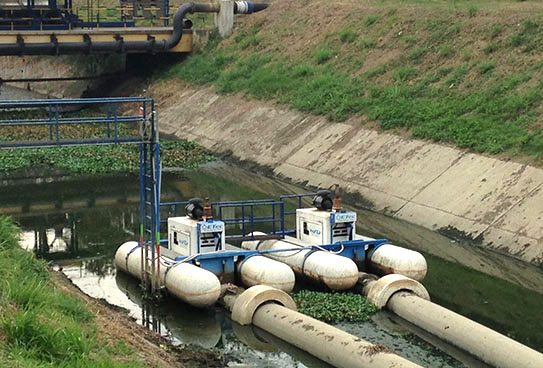

**Problem Statement**
* I have a friend who working in a small team that taking care of water pump of a small area far from big town, there are 7 system failure in last year. Those failure cause huge problem to many people and also lead to some serious living problem of some family. The team can't see any pattern in the data when the system goes down, so they are not sure where to put more attention.
* Since I believe in using data to solve problem, I ask him to provide available sensor data and hope that someone here can help.

## Step #0: Preparation
### Import Libraries

In [1]:
# Libraries for analysis dataset
import pandas as pd
import numpy as np
#Libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as stats
#Libraries for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from feature_engine import imputation as im
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from sklearn.pipeline import Pipeline
# libraries for model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
# ANN, RNN
import tensorflow
from tensorflow.keras.layers import Dense, Dropout,Activation,BatchNormalization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
# score
from sklearn.metrics import ( 
    roc_auc_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    precision_recall_fscore_support,
    classification_report 
)
# alarms
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### Functions for visualization

In [2]:
# let's see diagnostic plots
def diagnostic_plots(df, variable):
    fig = plt.figure()
    plt.figure(figsize = (18, 5))
   # histogram
    plt.subplot(1, 3, 1)
    fig = df[variable].hist(bins = 30,color = "b")
    plt.title('Histogram')
    fig.set_ylabel (variable)
    fig.set_xlabel(variable)
    # probability plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist = 'norm', plot = plt)
    # boxplot
    plt.subplot(1, 3, 3)
    fig = df.boxplot(column = variable,color = "b")
    fig.set_title('Boxplot')
    fig.set_ylabel(variable)
    plt.show()

In [3]:
# visualization
def make_plot(x, x_copy1, x_copy2,x_copy3,x_copy4,variable):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    x[variable].plot(kind='kde', ax=ax)
    x_copy1[variable].plot(kind='kde', ax=ax,color='yellow',label='MeanMedianImputer_mean')
    x_copy2[variable].plot(kind='kde', ax=ax,color='yellow',label='MeanMedianImputer_median')
    x_copy3[variable].plot(kind='kde', ax=ax, color='red', label='KNNImputer')
    x_copy4[variable].plot(kind='kde', ax=ax, color='green', label='IterativeImputer')
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')

# checking for outliers
    plt.figure(figsize=(12,3))
    plt.subplot(1,5,1)
    x[variable].plot.box(title="Original variable")
    plt.subplot(1,5,2)
    x_copy1[variable].plot.box(title="After MeanMImputer")
    plt.subplot(1,5,3)
    x_copy1[variable].plot.box(title="After MMedianImputer")
    plt.subplot(1,5,4)
    x_copy2[variable].plot.box(title="After KNNImputer")
    plt.subplot(1,5,5)
    x_copy2[variable].plot.box(title="After IterativeImputer")

# for variance
    print('Original variance:',x[variable].var()) 
    print('Variance after meanmedian_mean imputation:', x_copy1[variable].var())
    print('Variance after meanmedian_median imputation:', x_copy2[variable].var())
    print('Variance after knn imputation:', x_copy3[variable].var())
    print('Variance after iterative imputation:', x_copy4[variable].var())

In [4]:
# visualization of scaling
def scaling_plot(x, x_copy1, x_copy2,x_copy3,variable,variable1,variable2,variable3):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
    ax1.set_title('Before Scaling')  
    sns.kdeplot(x[variable], ax = ax1, color ='aqua')
    sns.kdeplot(x[variable1], ax = ax1, color ='blue')
    sns.kdeplot(x[variable2], ax = ax1, color ='red')
    sns.kdeplot(x[variable3], ax = ax1, color ='green')

    ax2.set_title('After Standard Scaling')  
    sns.kdeplot(x_copy1[variable], ax = ax2, color ='aqua')
    sns.kdeplot(x_copy1[variable1], ax = ax2, color ='blue')
    sns.kdeplot(x_copy1[variable2], ax = ax2, color ='red')
    sns.kdeplot(x_copy1[variable3], ax = ax2, color ='green')

    ax3.set_title('After Min-Max Scaling')  
    sns.kdeplot(x_copy2[variable], ax = ax3, color ='aqua')
    sns.kdeplot(x_copy2[variable1], ax = ax3, color ='blue')
    sns.kdeplot(x_copy2[variable2], ax = ax3, color ='red')
    sns.kdeplot(x_copy2[variable3], ax = ax3, color ='green')

    ax4.set_title('After Robust Scaling')  
    sns.kdeplot(x_copy3[variable], ax = ax4, color ='aqua')
    sns.kdeplot(x_copy3[variable1], ax = ax4, color ='blue')
    sns.kdeplot(x_copy3[variable2], ax = ax4, color ='red')
    sns.kdeplot(x_copy3[variable3], ax = ax4, color ='green') 
    
# visualization for outliers
def box_plot(x,x_copy1,x_copy2,x_copy3,variable):
    plt.figure(figsize=(12,3))
    plt.subplot(1,4,1)
    x[variable].plot.box(title="Before Scaling")
    plt.subplot(1,4,2)
    x_copy1[variable].plot.box(title="After Standard Scaling")
    plt.subplot(1,4,3)
    x_copy2[variable].plot.box(title="After Min-Max Scaling")
    plt.subplot(1,4,4)
    x_copy3[variable].plot.box(title="After Robust Scaling")

In [5]:
# define function to show the results for classifier
def score_show(y_train, y_test, y_pred_train, y_pred_test):

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3)) 
    
    print('Train: ')
    print('accuracy %s' % accuracy_score(y_train, y_pred_train))
    axes[0].set_title('Train Confusion Matrix')
    cm = confusion_matrix(y_train, y_pred_train)
    sns.heatmap(cm, annot = True, fmt = 'd', ax = axes[0], cmap=plt.cm.PuBu)    
    print(classification_report(y_train, y_pred_train))
    print('------------------------------------------------------')
    print('Test: ')
    print('accuracy %s' % accuracy_score(y_test, y_pred_test))
    axes[1].set_title('Test Confusion Matrix')
    cm_t = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm_t, annot = True, fmt = 'd', ax = axes[1], cmap=plt.cm.PuBu)    
    print(classification_report(y_test, y_pred_test))

In [6]:
# visualize loss and accuracy history
def history_plot(history):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])
    epochs = range(len(history.history['loss']))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    ax1.set_title('Loss', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()
    # plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    ax2.set_title('Accuracy', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend()

## Step #1 : Import dataset

In [7]:
# load the dataset
df = pd.read_csv('sensor_TP.csv')
# show the dataset
df

Unnamed: 0         timestamp  sensor_00  sensor_01  sensor_02  \
0                0  2018-04-01 00:00   2.465394   47.09201  53.211800   
1                1  2018-04-01 00:01   2.465394   47.09201  53.211800   
2                2  2018-04-01 00:02   2.444734   47.35243  53.211800   
3                3  2018-04-01 00:03   2.460474   47.09201  53.168400   
4                4  2018-04-01 00:04   2.445718   47.13541  53.211800   
...            ...               ...        ...        ...        ...   
220315      220315  2018-08-31 23:55   2.407350   47.69965  50.520830   
220316      220316  2018-08-31 23:56   2.400463   47.69965  50.564240   
220317      220317  2018-08-31 23:57   2.396528   47.69965  50.520830   
220318      220318  2018-08-31 23:58   2.406366   47.69965  50.520832   
220319      220319  2018-08-31 23:59   2.396528   47.69965  50.520832   

        sensor_03   sensor_04  sensor_05  sensor_06  sensor_07  ...  \
0       46.310760  634.375000   76.45975   13.41146   16.13136  ...   
1       46.310760  634.375000   76.45975   13.41146   16.13136  ...   
2       46.397570  638.888900   73.54598   13.32465   16.03733  ...   
3       46.397568  628.125000   76.98898   13.31742   16.24711  ...   
4       46.397568  636.458300   76.58897   13.35359   16.21094  ...   
...           ...         ...        ...        ...        ...  ...   
220315  43.142361  634.722229   64.59095   15.11863   16.65220  ...   
220316  43.142361  630.902771   65.83363   15.15480   16.70284  ...   
220317  43.142361  625.925903   67.29445   15.08970   16.70284  ...   
220318  43.142361  635.648100   65.09175   15.11863   16.56539  ...   
220319  43.142361  639.814800   65.45634   15.11863   16.65220  ...   

        sensor_43  sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  \
0        41.92708  39.641200   65.68287   50.92593  38.194440   157.9861   
1        41.92708  39.641200   65.68287   50.92593  38.194440   157.9861   
2        41.66666  39.351852   65.39352   51.21528  38.194443   155.9606   
3        40.88541  39.062500   64.81481   51.21528  38.194440   155.9606   
4        41.40625  38.773150   65.10416   51.79398  38.773150   158.2755   
...           ...        ...        ...        ...        ...        ...   
220315   38.28125  68.287030   52.37268   48.32176  41.087960   212.3843   
220316   38.28125  66.840280   50.63657   48.03241  40.798610   213.8310   
220317   39.06250  65.393520   48.90046   48.03241  40.798610   217.3032   
220318   40.62500  64.236110   47.74306   48.32176  40.509258   222.5116   
220319   41.40625  62.789350   46.29630   48.90046  40.219910   227.4306   

        sensor_49  sensor_50  sensor_51  machine_status  
0        67.70834   243.0556   201.3889          NORMAL  
1        67.70834   243.0556   201.3889          NORMAL  
2        67.12963   241.3194   203.7037          NORMAL  
3        66.84028   240.4514   203.1250          NORMAL  
4        66.55093   242.1875   201.3889          NORMAL  
...           ...        ...        ...             ...  
220315  153.64580        NaN   231.1921          NORMAL  
220316  156.25000        NaN   231.1921          NORMAL  
220317  155.38190        NaN   232.0602          NORMAL  
220318  153.93520        NaN   234.0856          NORMAL  
220319  150.46300        NaN   234.0856          NORMAL  

[220320 rows x 55 columns]

In [8]:
# information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [9]:
# description of dataset
df.describe()

Unnamed: 0      sensor_00      sensor_01      sensor_02  \
count  220320.000000  210112.000000  219951.000000  220301.000000   
mean   110159.500000       2.372221      47.591611      50.867392   
std     63601.049991       0.412227       3.296666       3.666820   
min         0.000000       0.000000       0.000000      33.159720   
25%     55079.750000       2.438831      46.310760      50.390620   
50%    110159.500000       2.456539      48.133678      51.649300   
75%    165239.250000       2.499826      49.479160      52.777770   
max    220319.000000       2.549016      56.727430      56.032990   

           sensor_03      sensor_04      sensor_05      sensor_06  \
count  220301.000000  220301.000000  220301.000000  215522.000000   
mean       43.752481     590.673936      73.396414      13.501537   
std         2.418887     144.023912      17.298247       2.163736   
min        31.640620       2.798032       0.000000       0.014468   
25%        42.838539     626.620400      69.976260      13.346350   
50%        44.227428     632.638916      75.576790      13.642940   
75%        45.312500     637.615723      80.912150      14.539930   
max        48.220490     800.000000      99.999880      22.251160   

           sensor_07      sensor_08  ...      sensor_42      sensor_43  \
count  214869.000000  215213.000000  ...  220293.000000  220293.000000   
mean       15.843152      15.200721  ...      35.453455      43.879591   
std         2.201155       2.037390  ...      10.259521      11.044404   
min         0.000000       0.028935  ...      22.135416      24.479166   
25%        15.907120      15.183740  ...      32.812500      39.583330   
50%        16.167530      15.494790  ...      35.156250      42.968750   
75%        16.427950      15.697340  ...      36.979164      46.614580   
max        23.596640      24.348960  ...     374.218800     408.593700   

           sensor_44      sensor_45      sensor_46      sensor_47  \
count  220293.000000  220293.000000  220293.000000  220293.000000   
mean       42.656877      43.094984      48.018585      44.340903   
std        11.576355      12.837520      15.641284      10.442437   
min        25.752316      26.331018      26.331018      27.199070   
25%        36.747684      36.747684      40.509258      39.062500   
50%        40.509260      40.219910      44.849540      42.534720   
75%        45.138890      44.849540      51.215280      46.585650   
max      1000.000000     320.312500     370.370400     303.530100   

           sensor_48      sensor_49      sensor_50      sensor_51  
count  220293.000000  220293.000000  143303.000000  204937.000000  
mean      150.889044      57.119968     183.049260     202.699667  
std        82.244957      19.143598      65.258650     109.588607  
min        26.331018      26.620370      27.488426      27.777779  
25%        83.912030      47.743060     167.534700     179.108800  
50%       138.020800      52.662040     193.865700     197.338000  
75%       208.333300      60.763890     219.907400     216.724500  
max       561.632000     464.409700    1000.000000    1000.000000  

[8 rows x 53 columns]

# Step #2 : Analysis 
## Step #2.1: Exploratory data analysis

In [10]:
# look at the count of missing values
df.isnull().sum().sort_values(ascending=False)

sensor_15         220320
sensor_50          77017
sensor_51          15383
sensor_00          10208
sensor_07           5451
sensor_08           5107
sensor_06           4798
sensor_09           4595
sensor_01            369
sensor_30            261
sensor_29             72
sensor_32             68
sensor_18             46
sensor_17             46
sensor_22             41
sensor_25             36
sensor_16             31
sensor_40             27
sensor_41             27
sensor_43             27
sensor_44             27
sensor_39             27
sensor_38             27
sensor_45             27
sensor_46             27
sensor_47             27
sensor_48             27
sensor_42             27
sensor_49             27
sensor_14             21
sensor_26             20
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_27             16


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


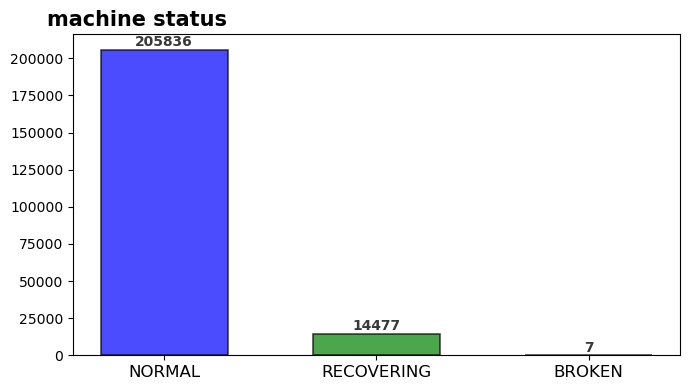

In [11]:
# look at the machine_status variable
label = df['machine_status'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(7,4))
color_map = ['g' for _ in range(len(df['machine_status'].value_counts()))]
color_map[0] = 'b'
ax.bar(label.index, label, alpha=0.7, color=color_map, width=0.6, edgecolor='black', linewidth=1.2)
ax.set_title('machine status', fontsize=15, fontweight='bold', fontfamily='NanumGothic', position=(0.105, 1.0))
for i in label.index:
    ax.annotate(f"{label[i]}",
                xy=(i, label[i] + 5000),
                va='center', ha='center', fontweight='bold', color='#383838')
ax.set_xticklabels(label.index, fontsize=12, fontfamily='NanumGothic', rotation=0)
plt.tight_layout()
plt.show()

Distribution is imbalanced. In total 7 are broken, 14477 are recovering  and 205836 are normal.

In [12]:
# recoded the variable into 3 variables to better analyze each class in it
df.rename(columns={df.columns[0]: 'Samplenr'},inplace=True)
df['machine_status'] = df['machine_status'] 
df_machine_NORMAL = df[df['machine_status'] == 'NORMAL']
df_machine_RECOVERING = df[df['machine_status'] == 'RECOVERING']
df_machine_BROKEN = df[df['machine_status']=='BROKEN']

df_machine_BROKEN

Samplenr         timestamp  sensor_00  sensor_01  sensor_02  \
17155      17155  2018-04-12 21:55   0.000000  53.342010  52.821180   
24510      24510  2018-04-18 00:30   1.093982  42.534720  47.699650   
69318      69318  2018-05-19 03:18   2.258796  47.265630  52.734370   
77790      77790  2018-05-25 00:30   2.321759  47.482640  51.475693   
128040    128040  2018-06-28 22:00   0.364005  40.190970  45.225690   
141131    141131  2018-07-08 00:11   0.001968  45.138890  52.907990   
166440    166440  2018-07-25 14:00   2.318808  45.833332  52.994790   

        sensor_03   sensor_04  sensor_05  sensor_06  sensor_07  ...  \
17155   43.402775  202.526031   49.79289   3.219039  16.890910  ...   
24510   41.449650  206.038757   60.30106  12.304690  15.154800  ...   
69318   43.446178  200.115738   66.14643  13.592300  15.914350  ...   
77790   42.795136  612.152800   67.30158  14.062500  16.608800  ...   
128040  40.190971  201.368622    0.00000  11.335360  15.270540  ...   
141131  45.355900  500.000000    1.40131   0.028935   0.036169  ...   
166440  43.880210  420.503448   72.52040  14.185470  16.247110  ...   

        sensor_43  sensor_44  sensor_45   sensor_46   sensor_47   sensor_48  \
17155    50.78125   50.92593  51.215280   50.636570   46.006940  409.143500   
24510    42.70833   34.72222  31.539350   34.432870   33.275460   59.895830   
69318    39.06250   35.01157  37.905090   39.062500   45.428240  144.675900   
77790   202.34370   65.68287  57.870370  127.893500  153.935200  155.381900   
128040   32.29166   28.06713  28.067129   29.513889   29.224537   29.224537   
141131   36.19791   37.32639  35.300930   38.194440   43.402780   99.537030   
166440   51.30208   52.10200  52.662040   67.129630   43.981480  230.324100   

         sensor_49   sensor_50  sensor_51  machine_status  
17155   121.527800  401.909700   324.6528          BROKEN  
24510    44.560180  177.662000   183.7384          BROKEN  
69318    49.768520  246.238400   257.5231          BROKEN  
77790    65.682870  220.196800   267.3611          BROKEN  
128040   29.513889   32.407406        NaN          BROKEN  
141131   44.849540  192.129600   174.7685          BROKEN  
166440   69.733800         NaN   205.7292          BROKEN  

[7 rows x 55 columns]

In [13]:
# calculate how much time it took for each class
row_numbers_machine_BROKEN = list(df_machine_BROKEN['Samplenr'].values)

recovering_times_hours=[]

for i in row_numbers_machine_BROKEN:
    print('\nMachine is status BROKEN in row: {}'.format(i))
    go_futher = True
    j=i
    while go_futher:
        j+=1
        machine_status_in_row_j = df.iloc[j]['machine_status']
        if machine_status_in_row_j != 'RECOVERING':
            go_futher = False
    print('Machine went back to status {0} in row {1}'.format(machine_status_in_row_j, j - i))

    recovering_hours = (j-i) / 60
    recovering_days = recovering_hours / 24
    print('Machine was in RECOVERING state for {0:.1f} hours / {1:.1f} days'.format(recovering_hours, recovering_days))

    recovering_times_hours.append(recovering_hours)


Machine is status BROKEN in row: 17155
Machine went back to status NORMAL in row 945
Machine was in RECOVERING state for 15.8 hours / 0.7 days

Machine is status BROKEN in row: 24510
Machine went back to status NORMAL in row 3111
Machine was in RECOVERING state for 51.9 hours / 2.2 days

Machine is status BROKEN in row: 69318
Machine went back to status NORMAL in row 1313
Machine was in RECOVERING state for 21.9 hours / 0.9 days

Machine is status BROKEN in row: 77790
Machine went back to status NORMAL in row 606
Machine was in RECOVERING state for 10.1 hours / 0.4 days

Machine is status BROKEN in row: 128040
Machine went back to status NORMAL in row 8391
Machine was in RECOVERING state for 139.8 hours / 5.8 days

Machine is status BROKEN in row: 141131
Machine went back to status NORMAL in row 42
Machine was in RECOVERING state for 0.7 hours / 0.0 days

Machine is status BROKEN in row: 166440
Machine went back to status NORMAL in row 76
Machine was in RECOVERING state for 1.3 hours 

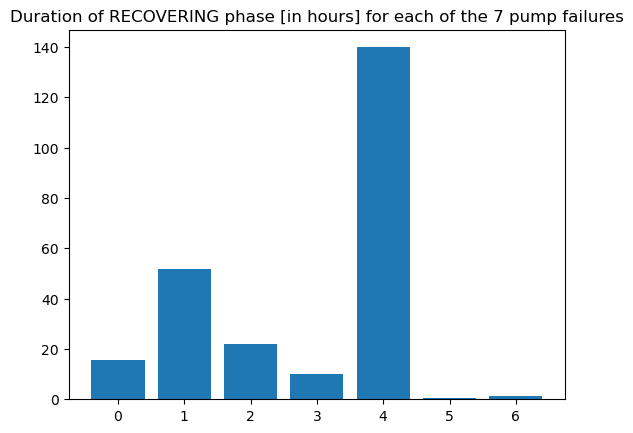

In [14]:
# vizualize recovering time
xpos = np.arange(len(recovering_times_hours))

fig, ax = plt.subplots()
ax.bar(xpos, recovering_times_hours)
ax.set_xticks(xpos)
ax.set_xticklabels(xpos)
ax.set_title('Duration of RECOVERING phase [in hours] for each of the 7 pump failures')
plt.show()

The 4th pump failure had the longest recovery time with a duration of 139.8 hours.

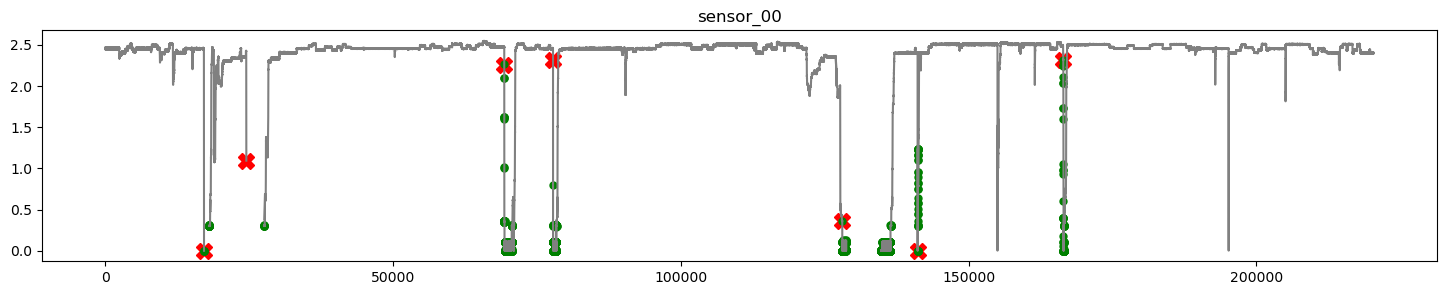

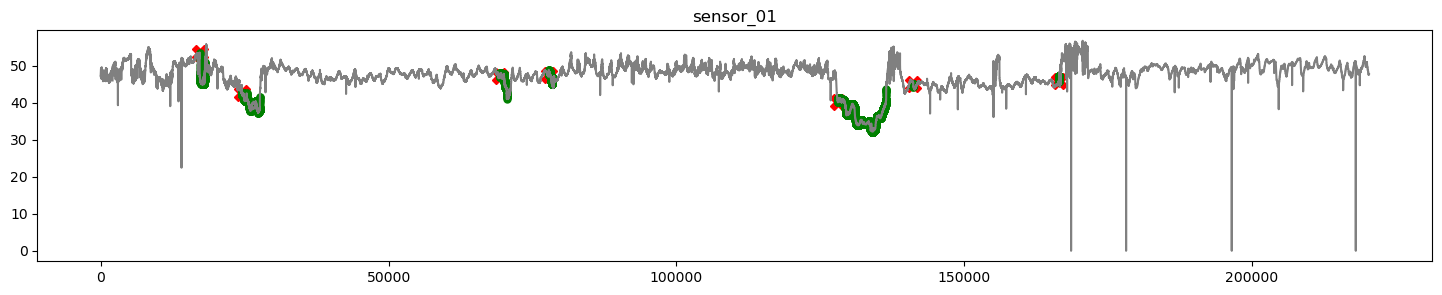

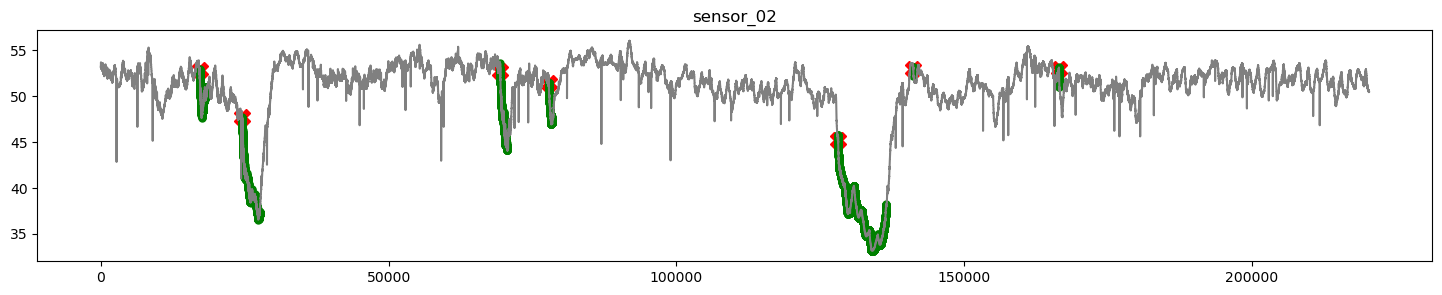

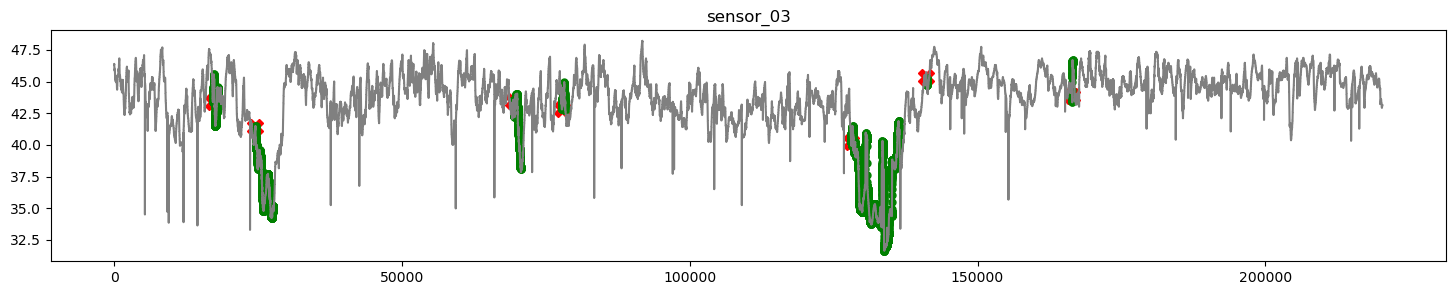

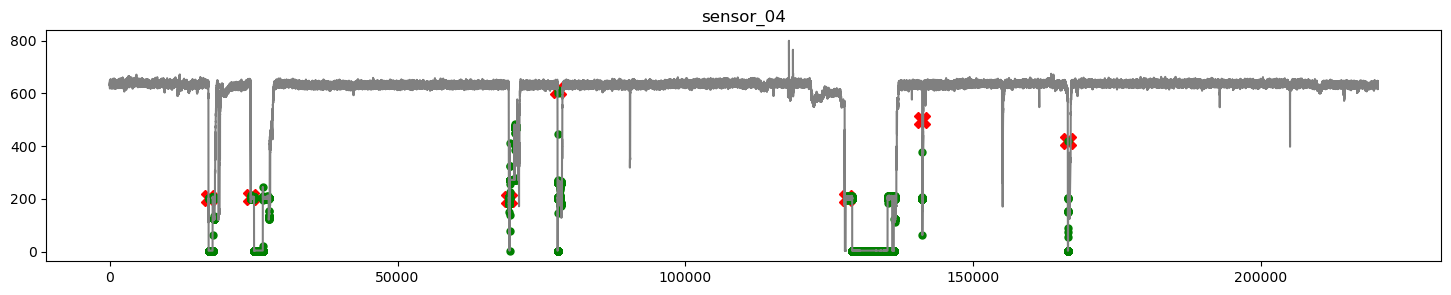

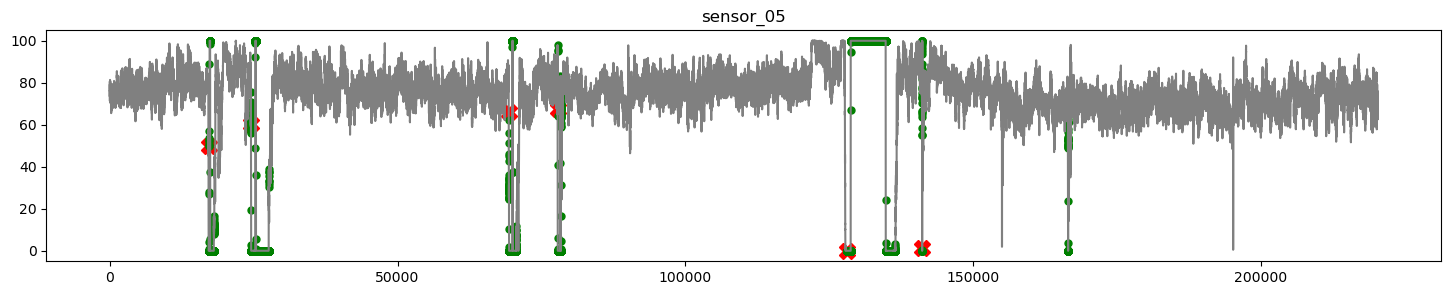

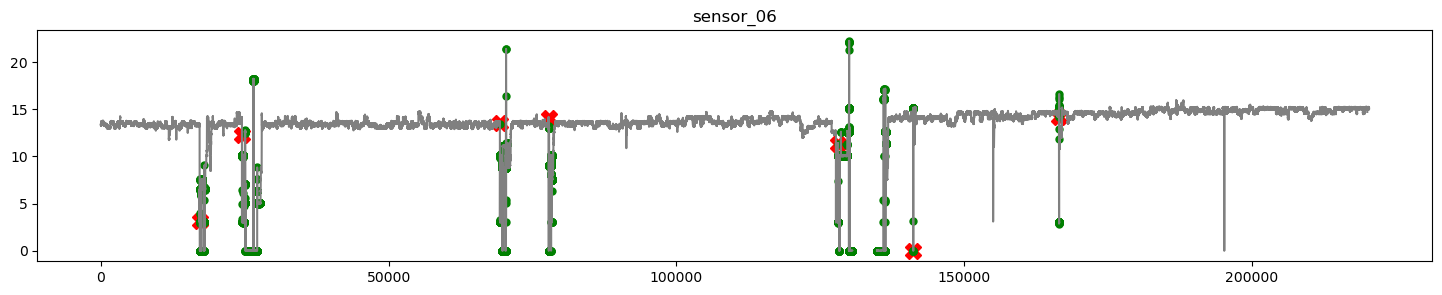

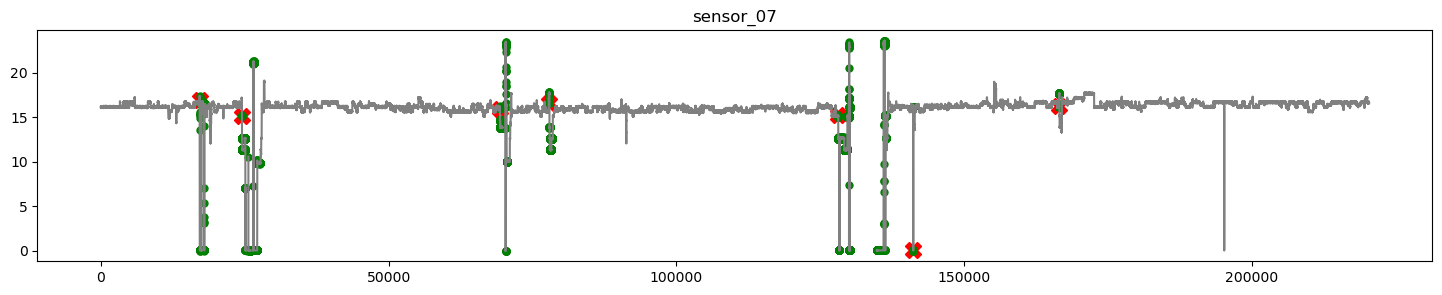

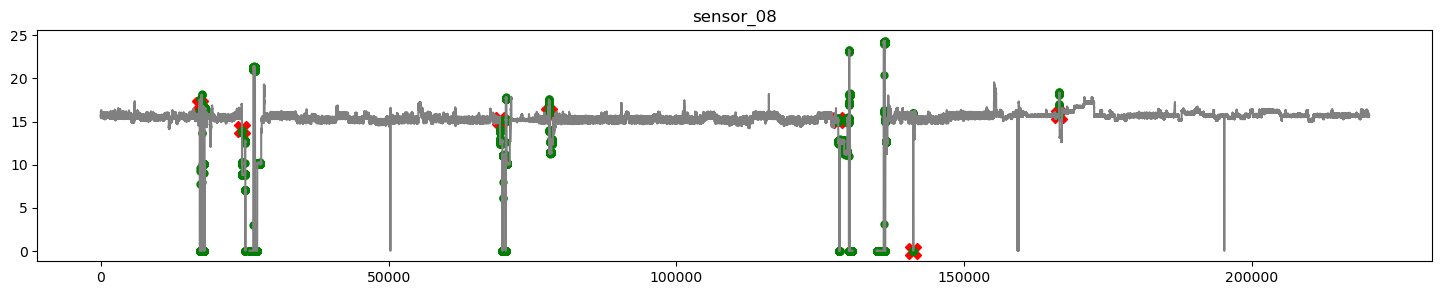

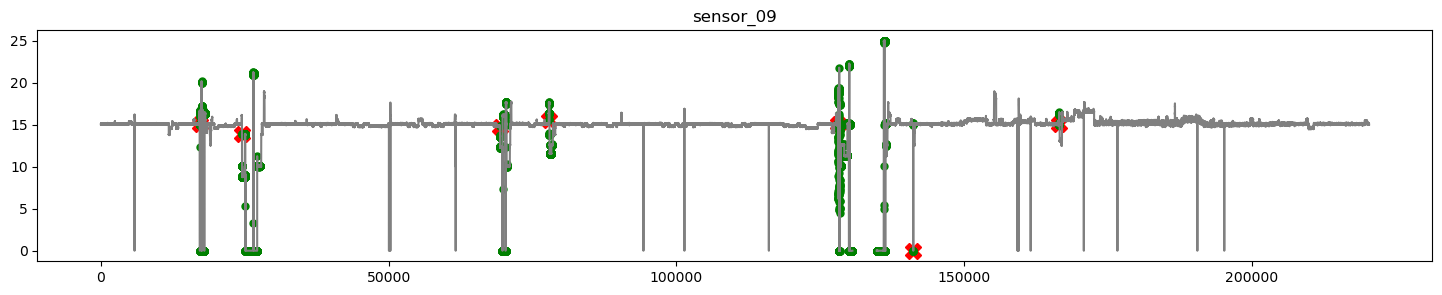

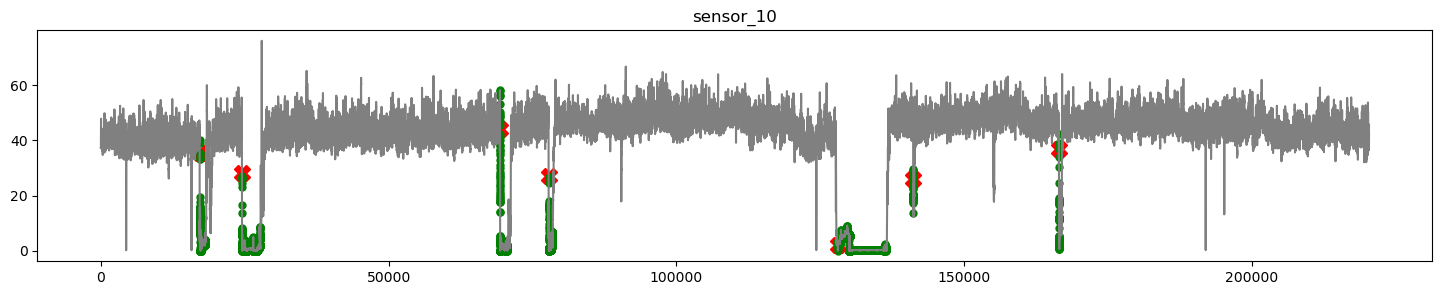

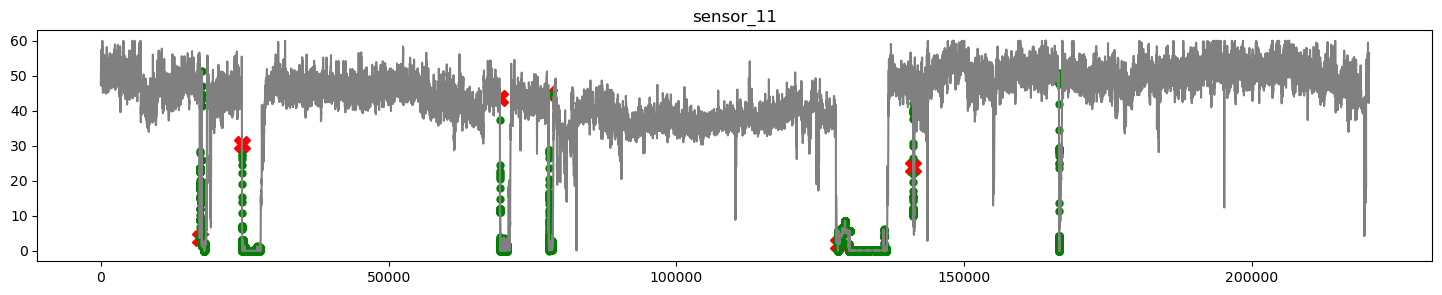

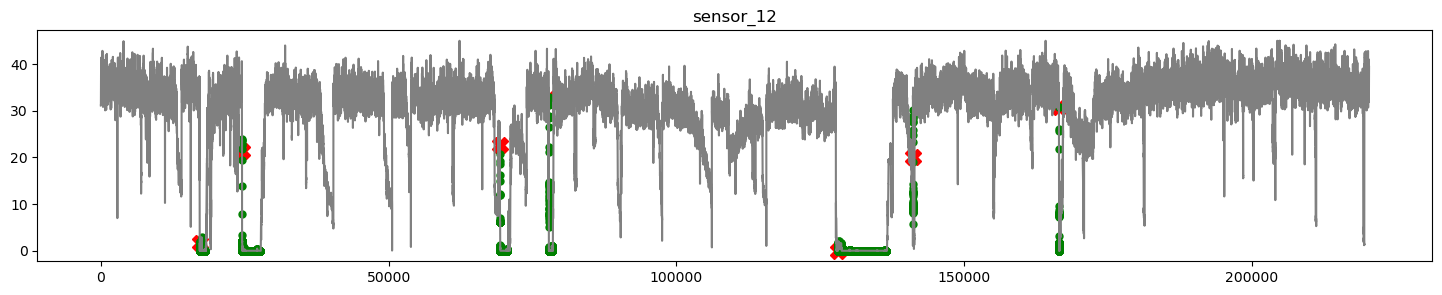

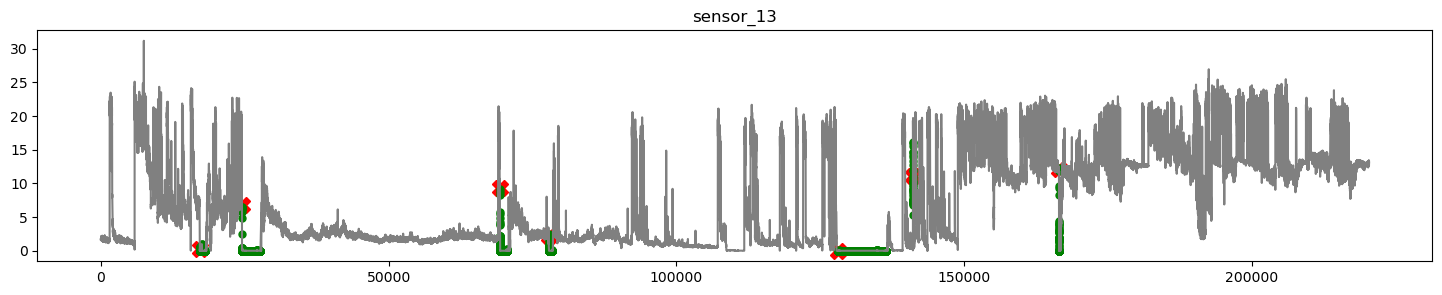

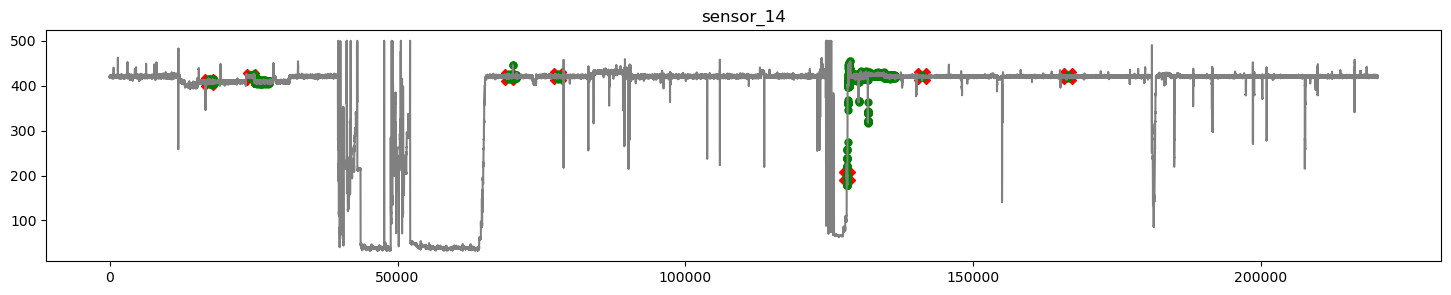

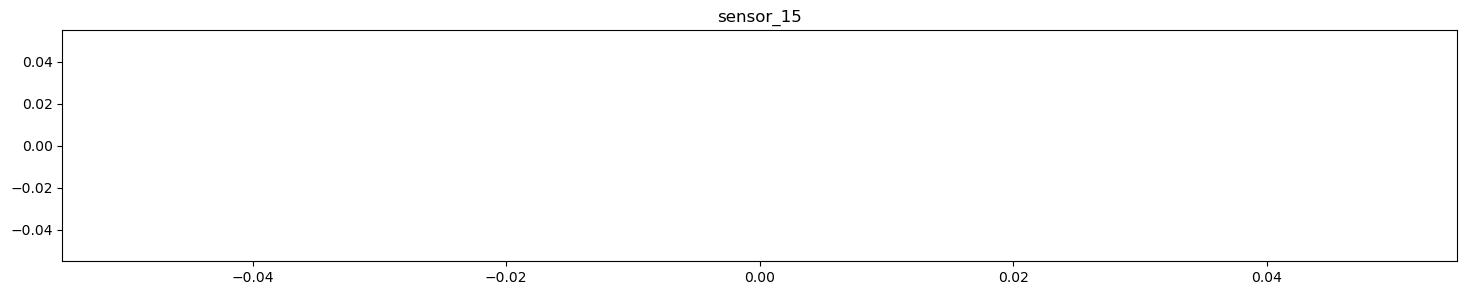

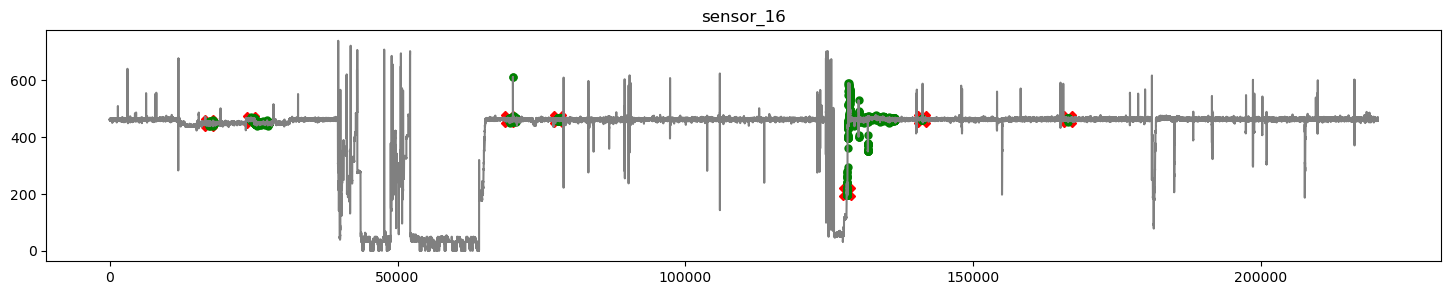

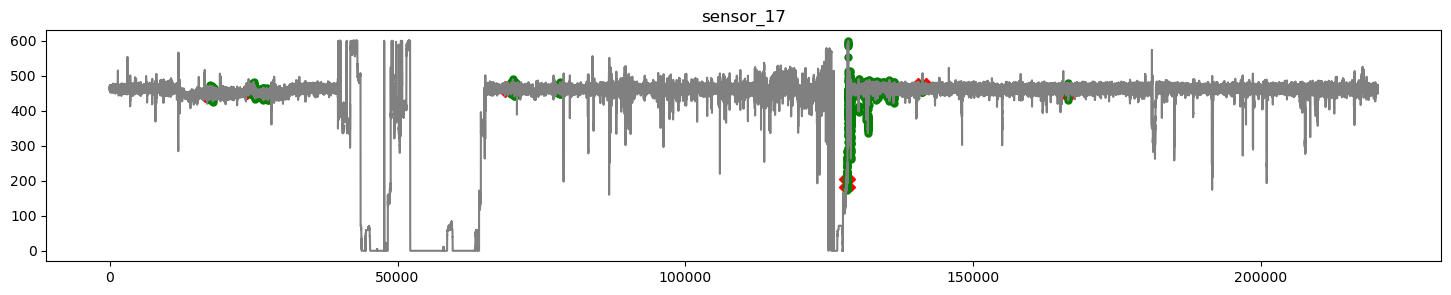

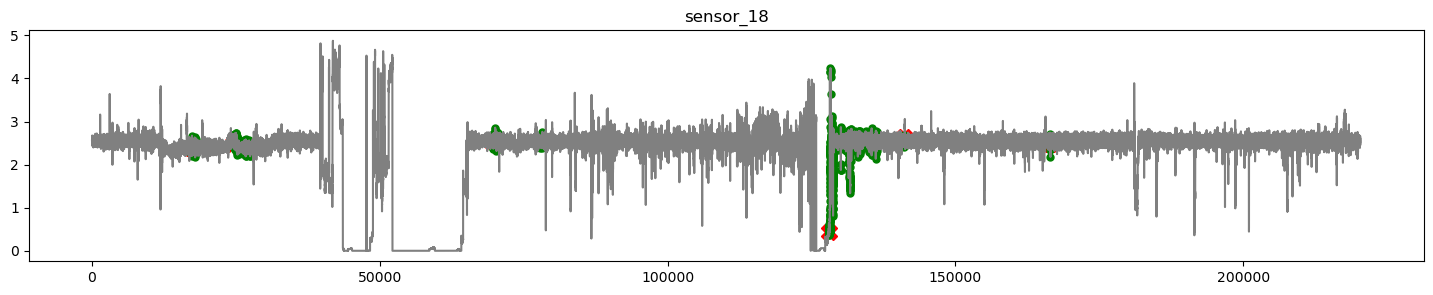

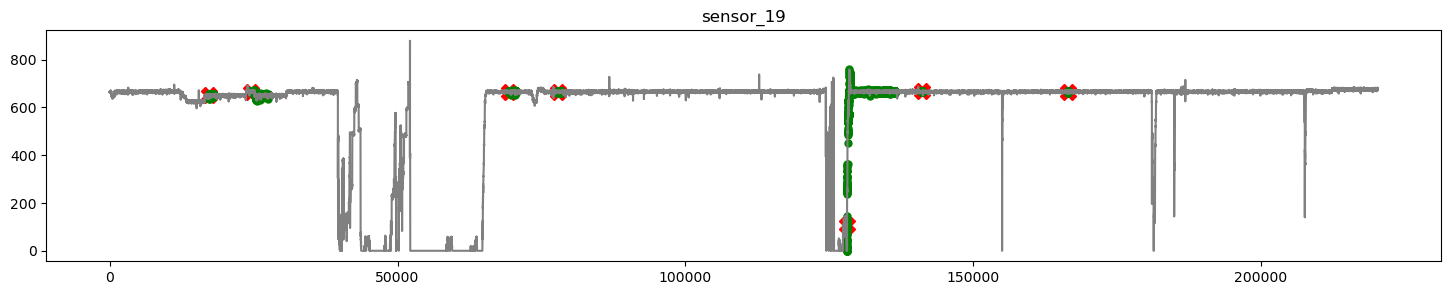

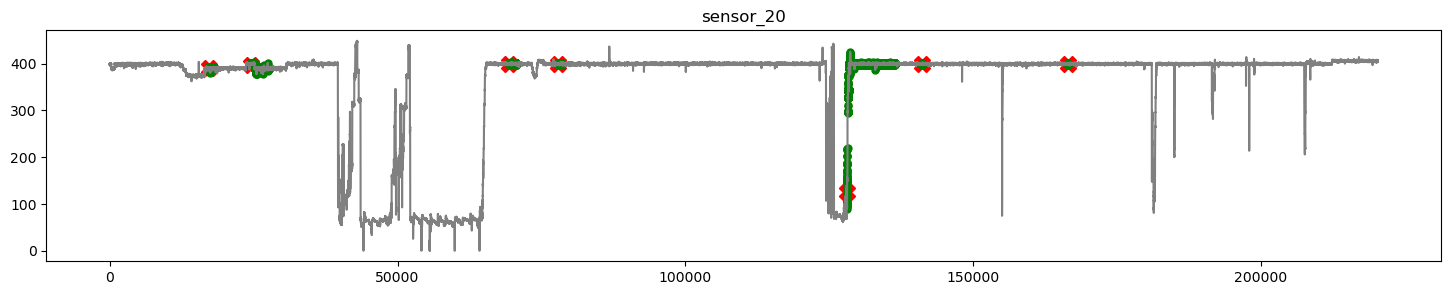

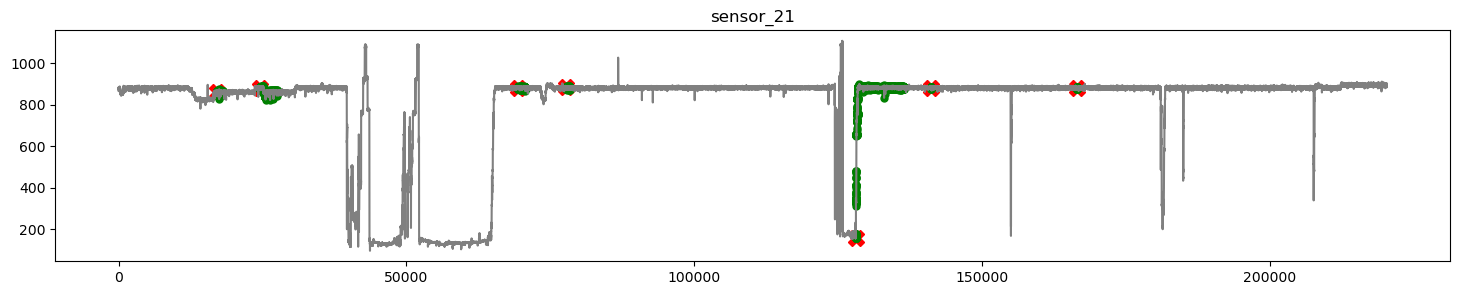

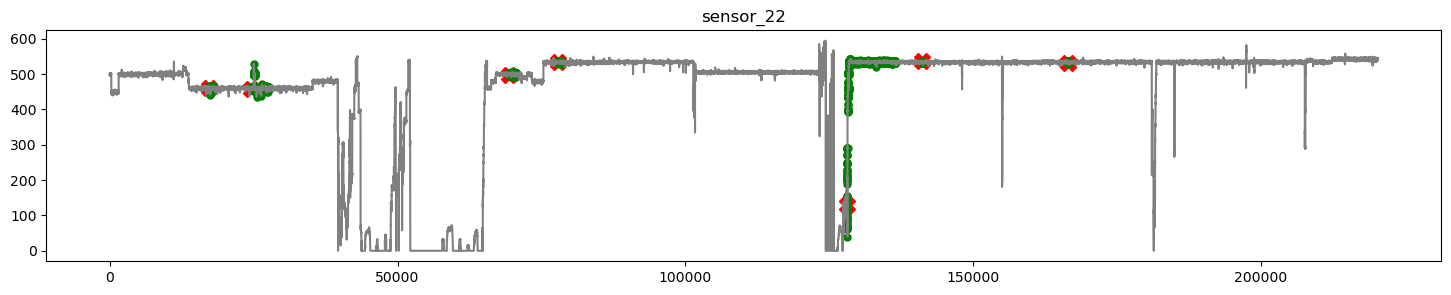

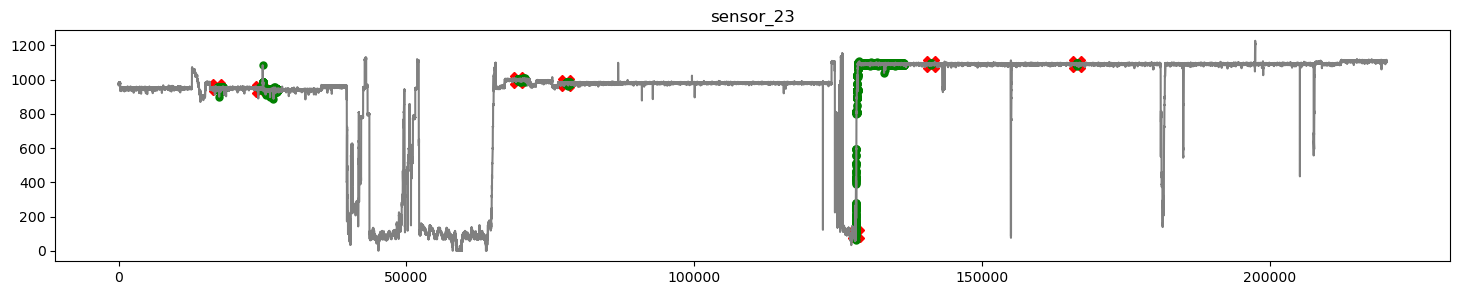

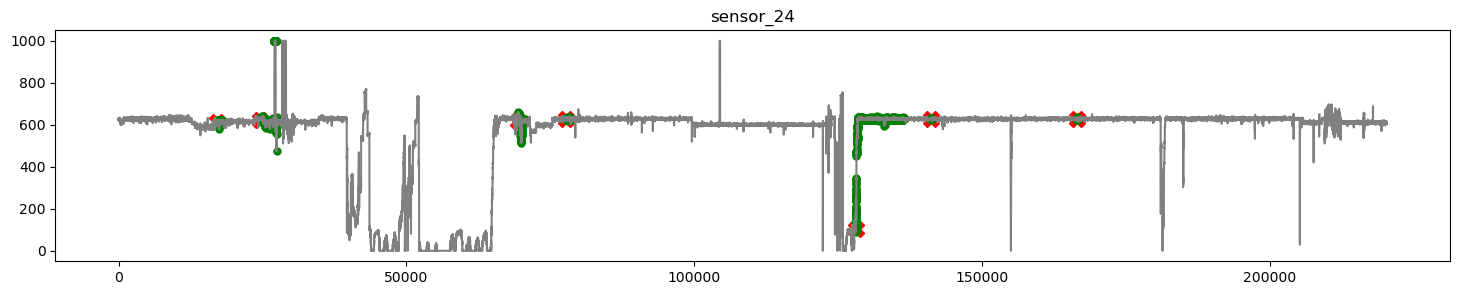

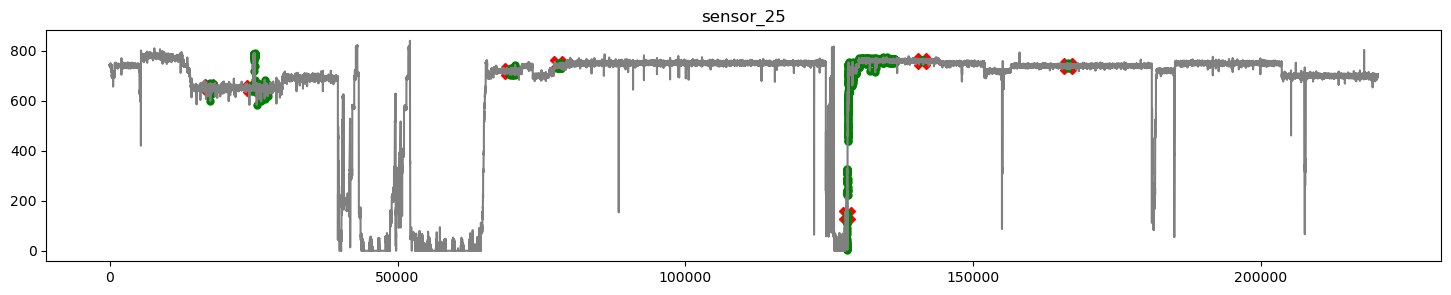

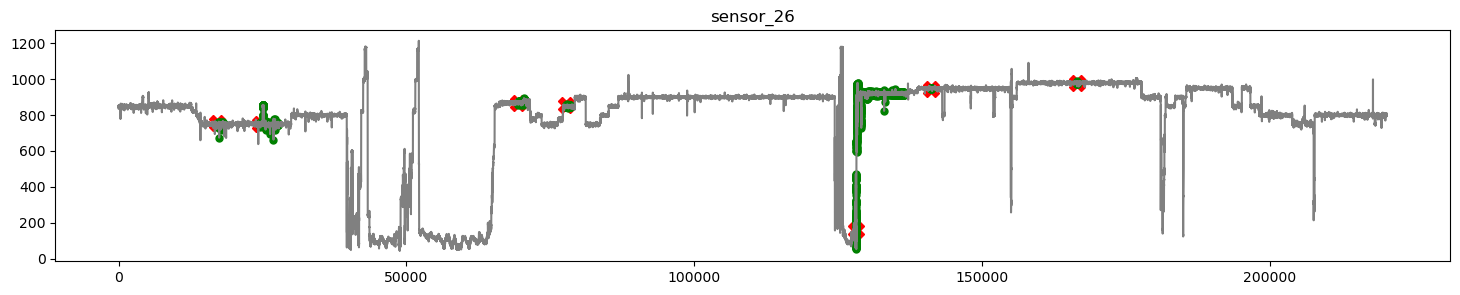

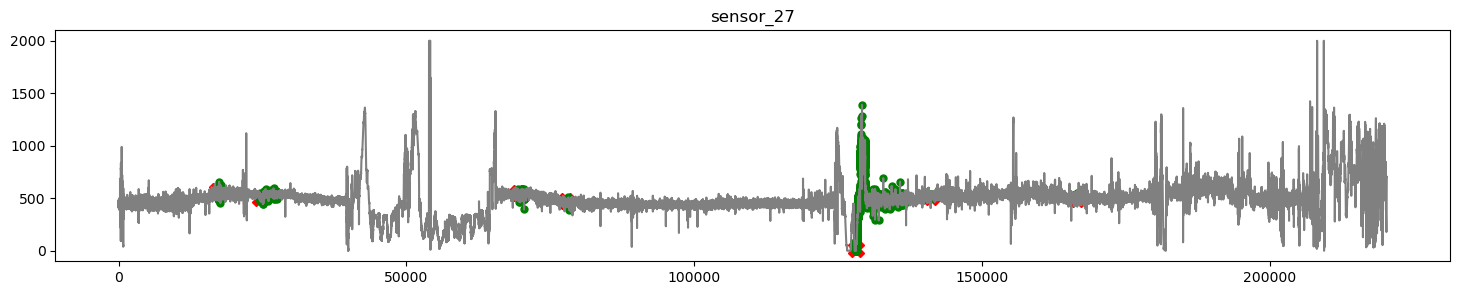

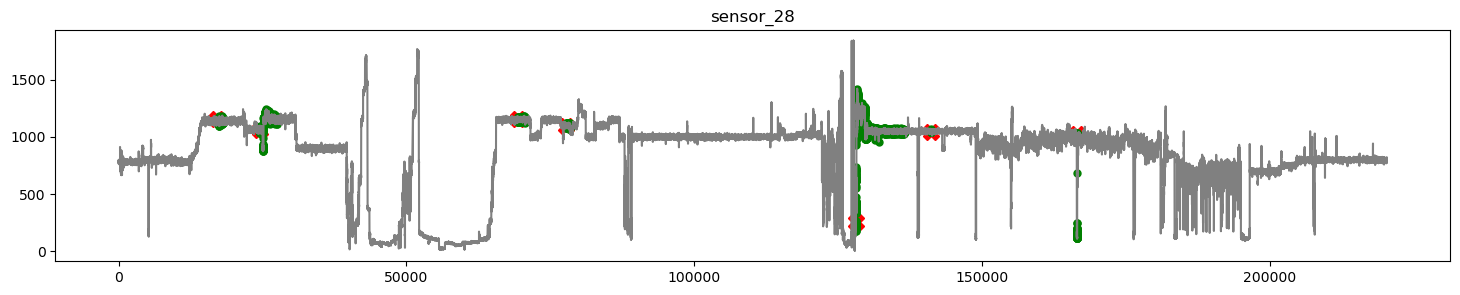

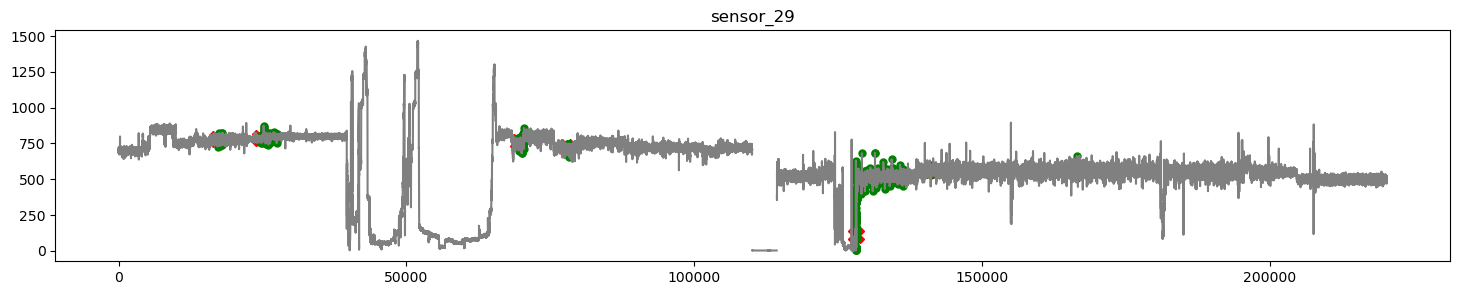

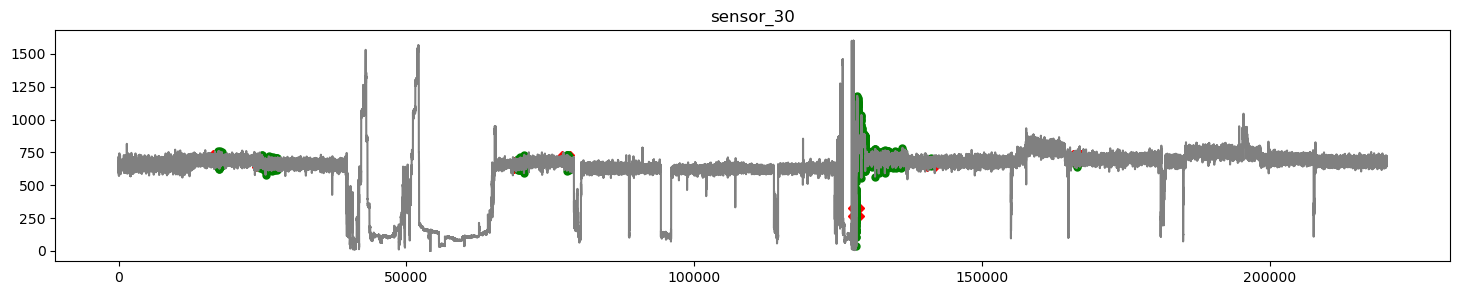

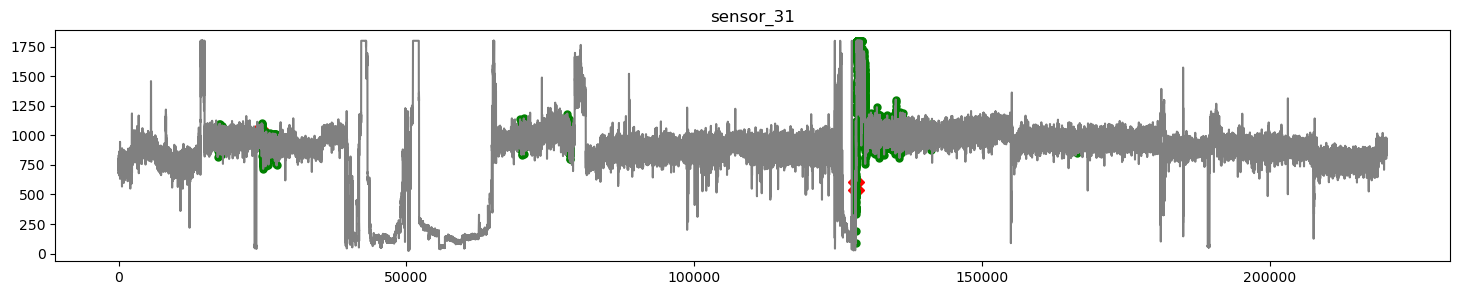

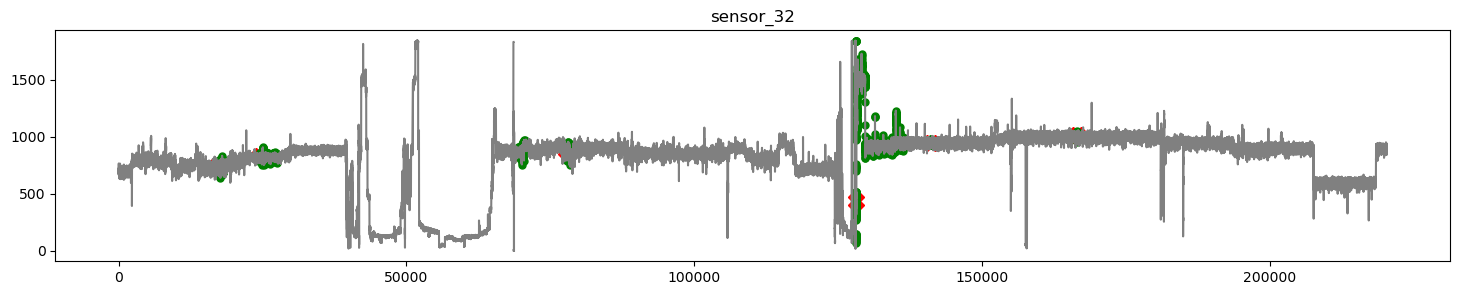

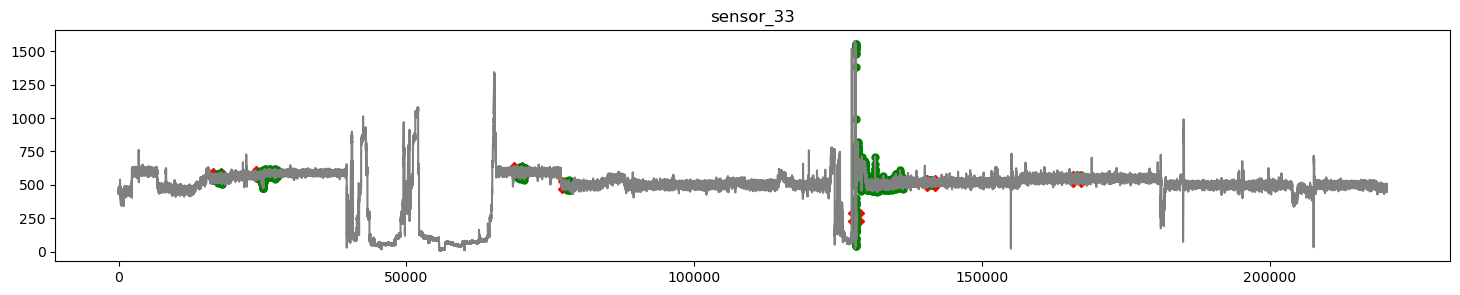

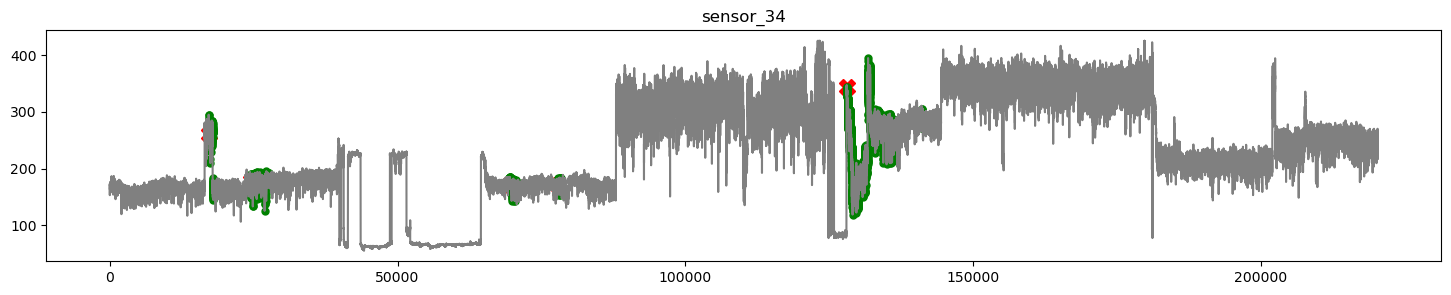

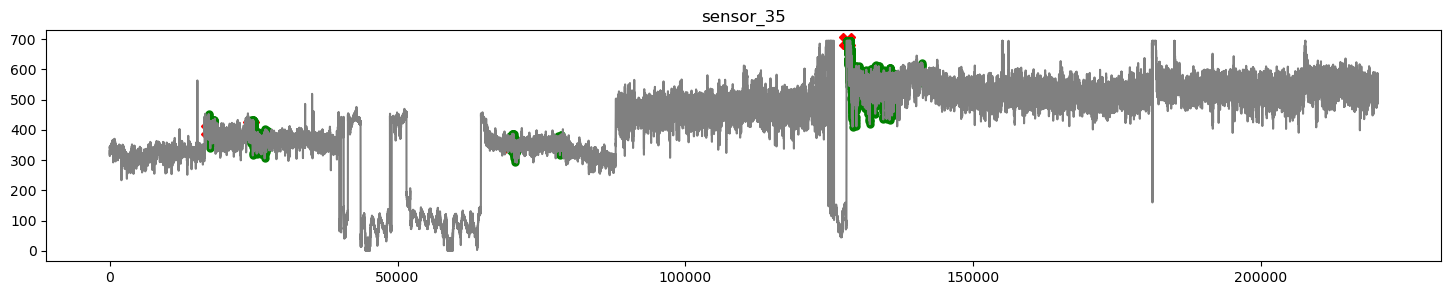

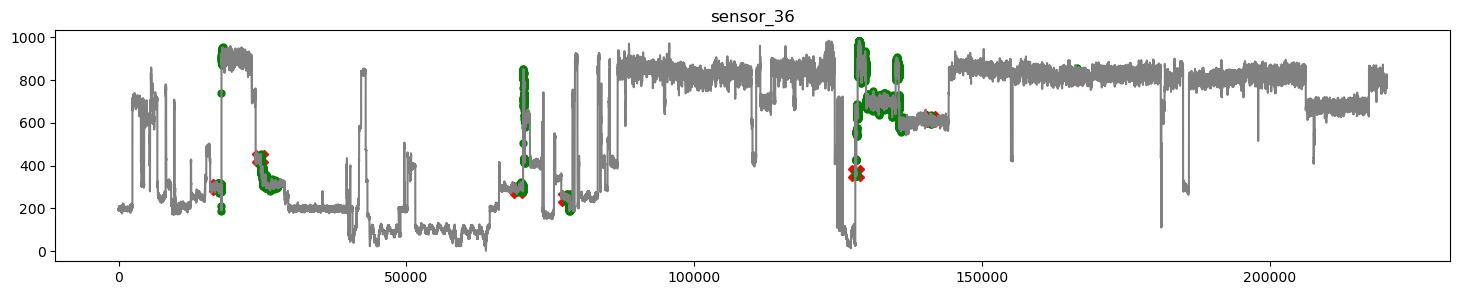

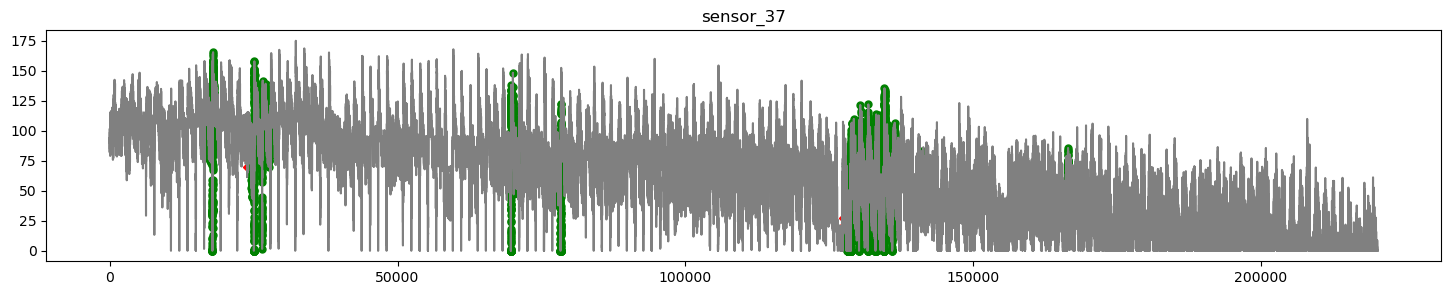

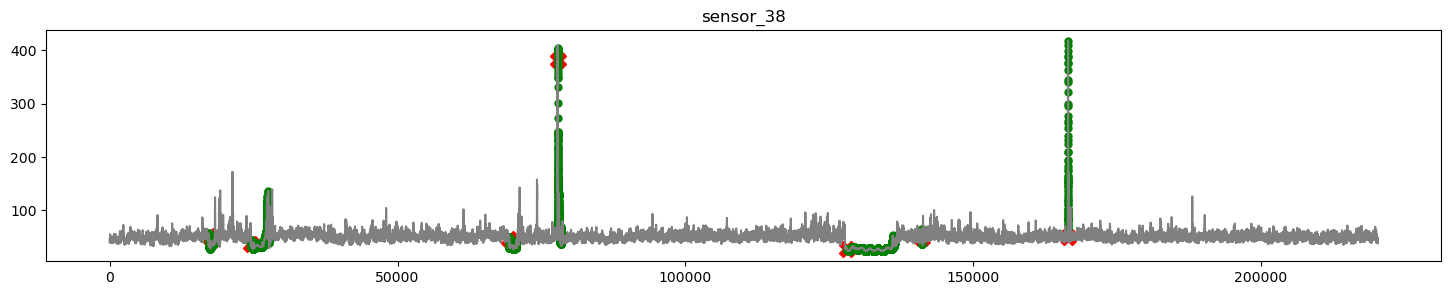

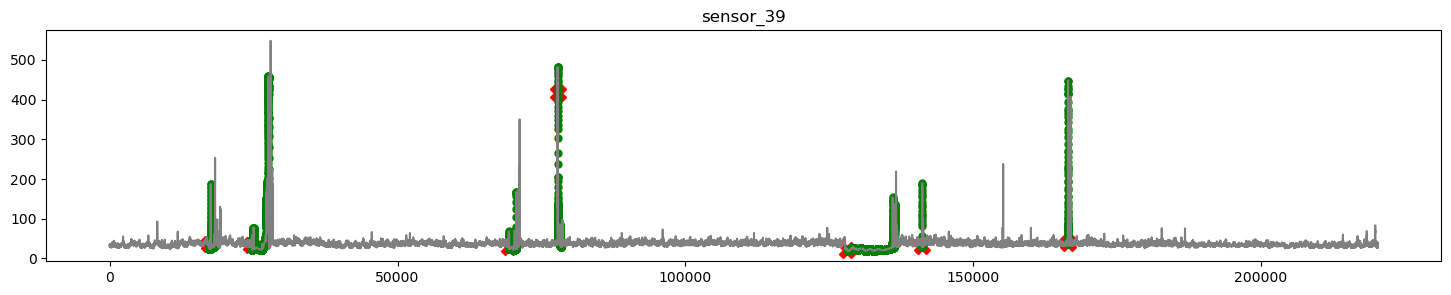

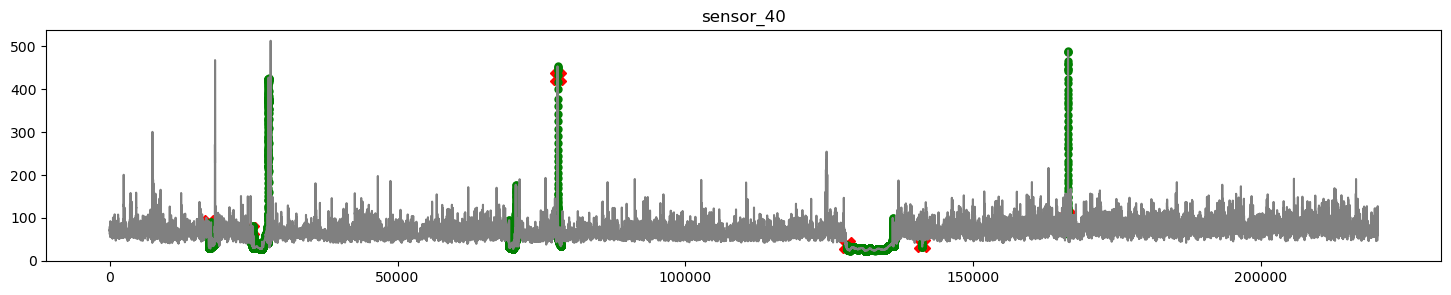

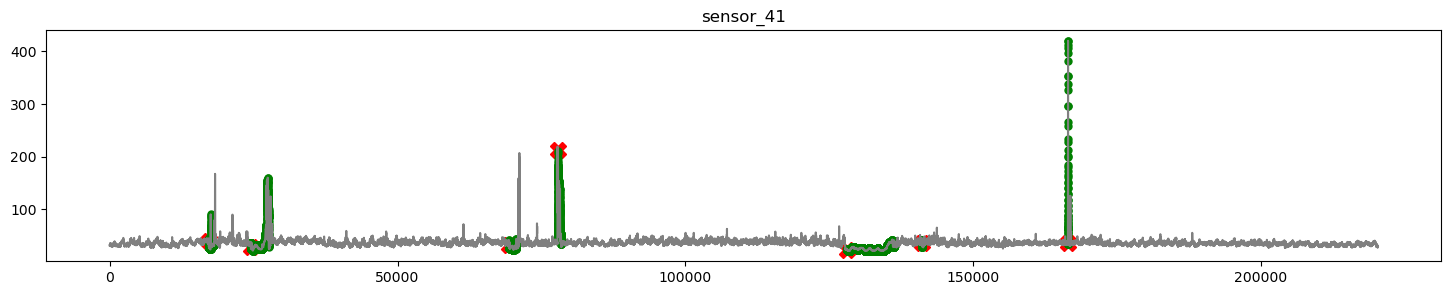

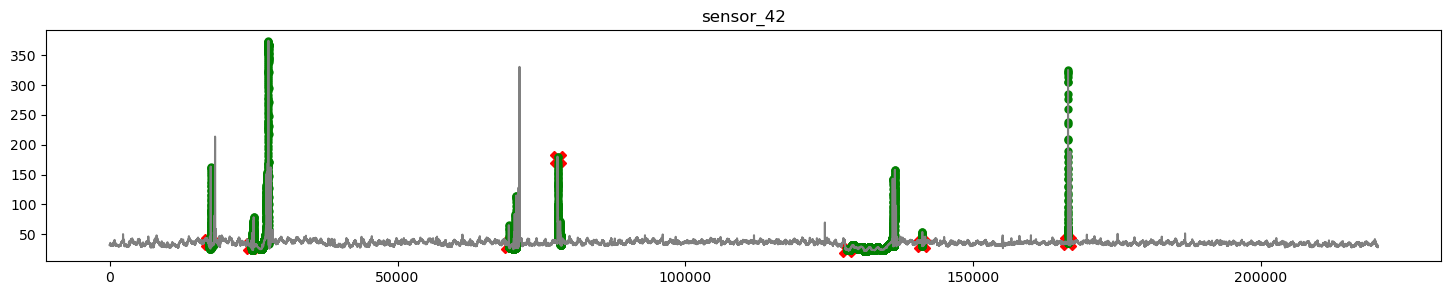

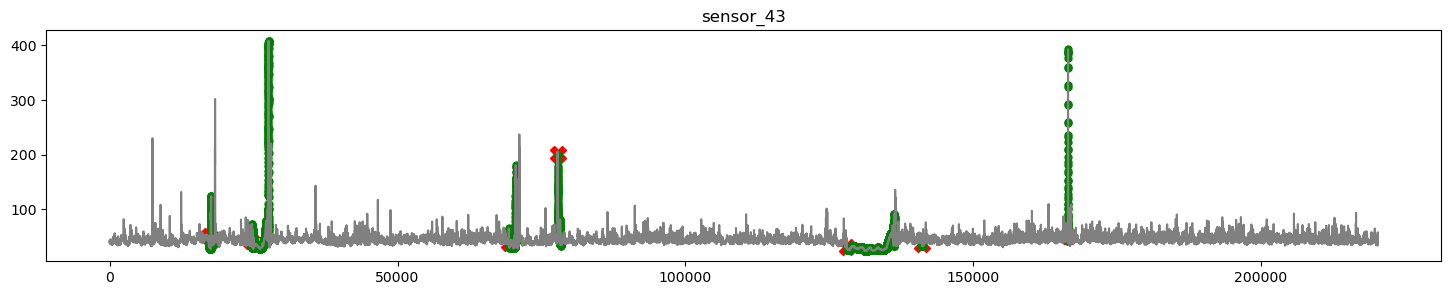

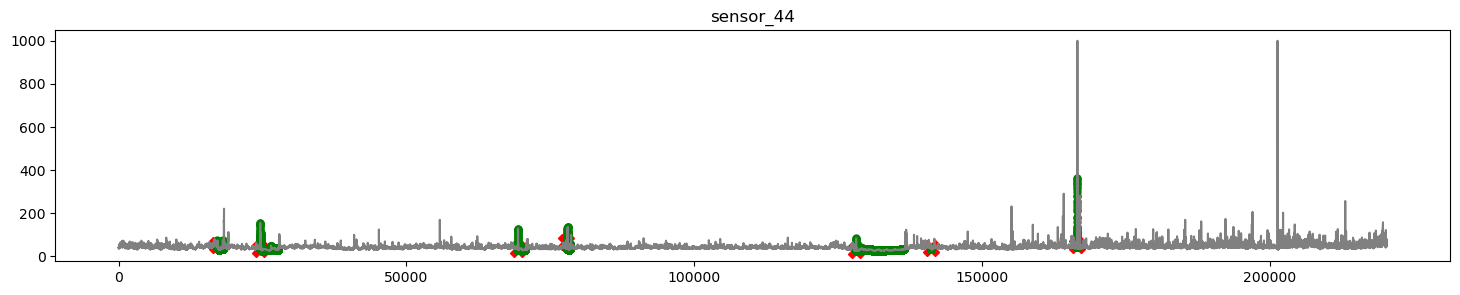

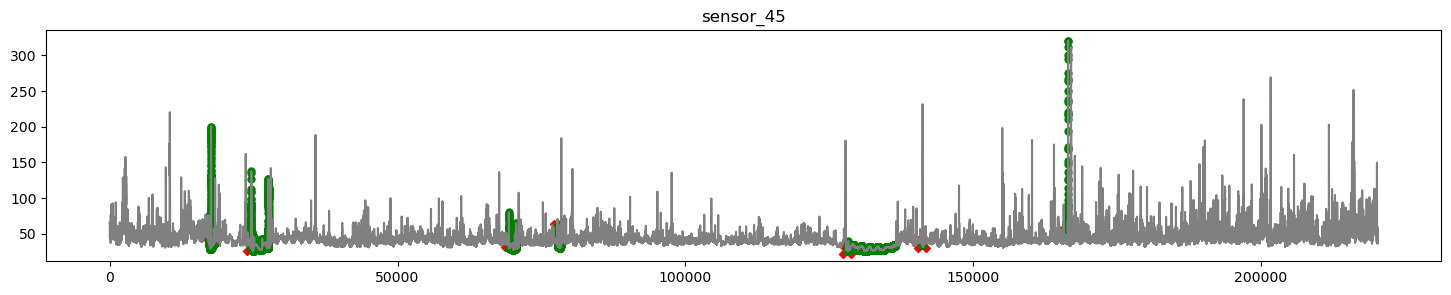

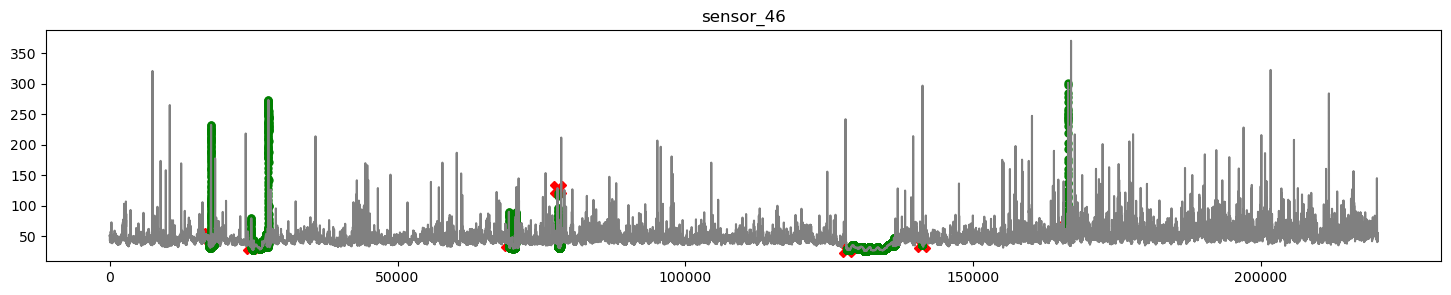

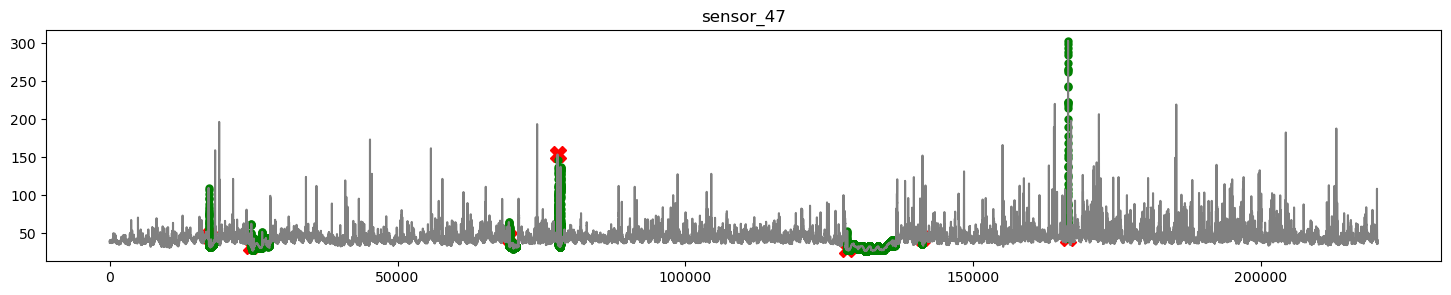

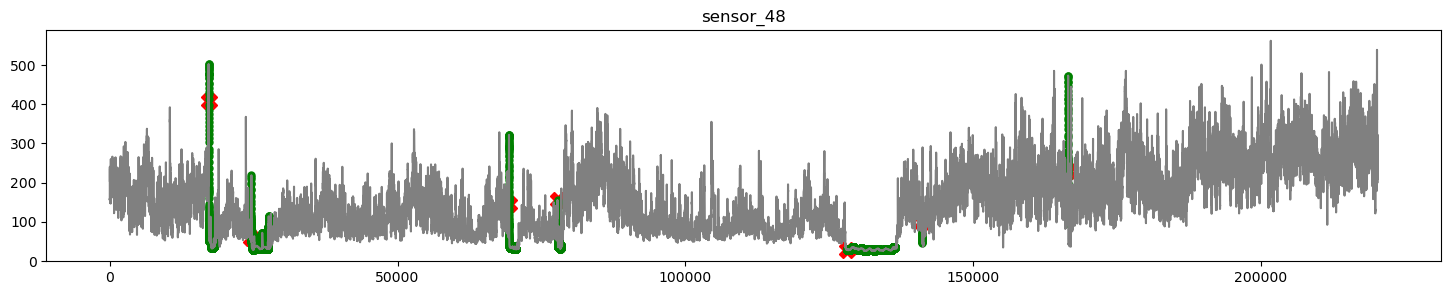

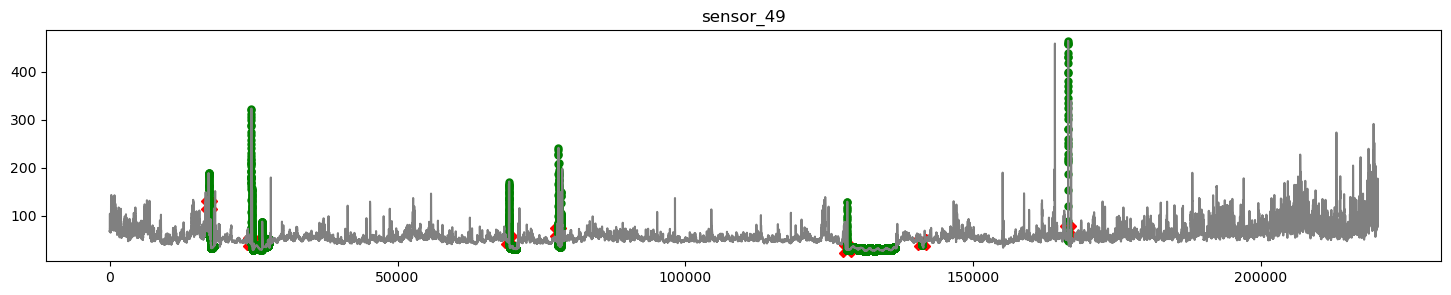

In [15]:
# vizualize each sensor
df_sensor = df.iloc[:, 2:52]
for sensor in df_sensor:
    plot = plt.figure(figsize=(18,3))
    plot = plt.plot(df_machine_BROKEN[sensor], linestyle='none', marker='X', color='red', markersize=12)
    plot = plt.plot(df_machine_RECOVERING[sensor], linestyle='none', marker='o', color='g', markersize=5)
    plot = plt.plot(df[sensor], color='grey')
    plot = plt.title(sensor)
    plt.show()

Let's take a closer look at each sensor. The graph shows how the work of the recovery and broken sensors fall.

<Figure size 640x480 with 0 Axes>

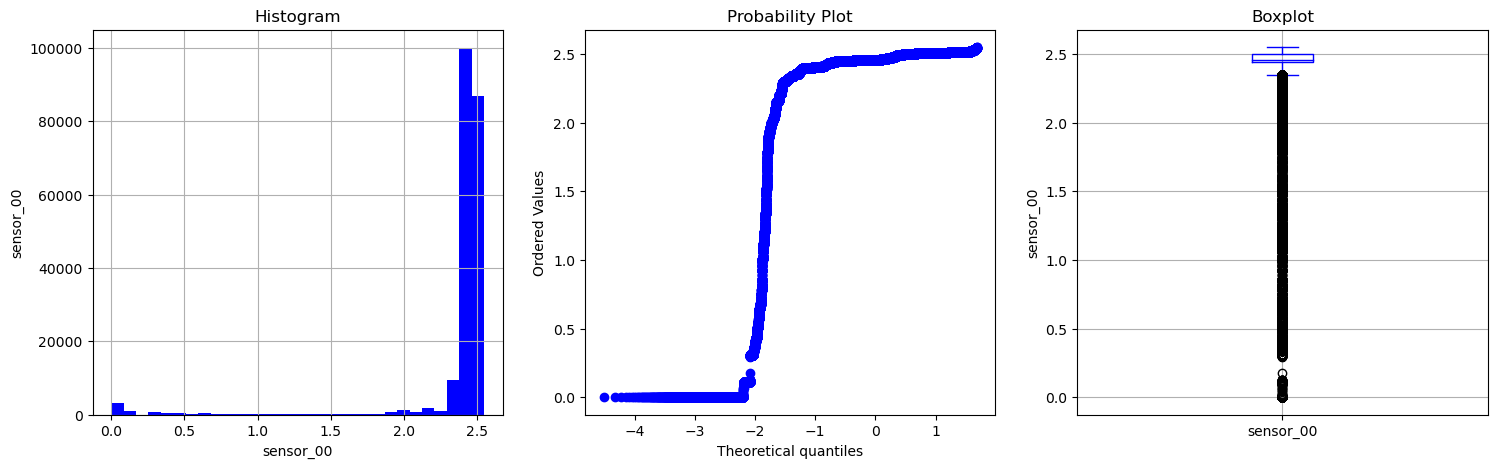

<Figure size 640x480 with 0 Axes>

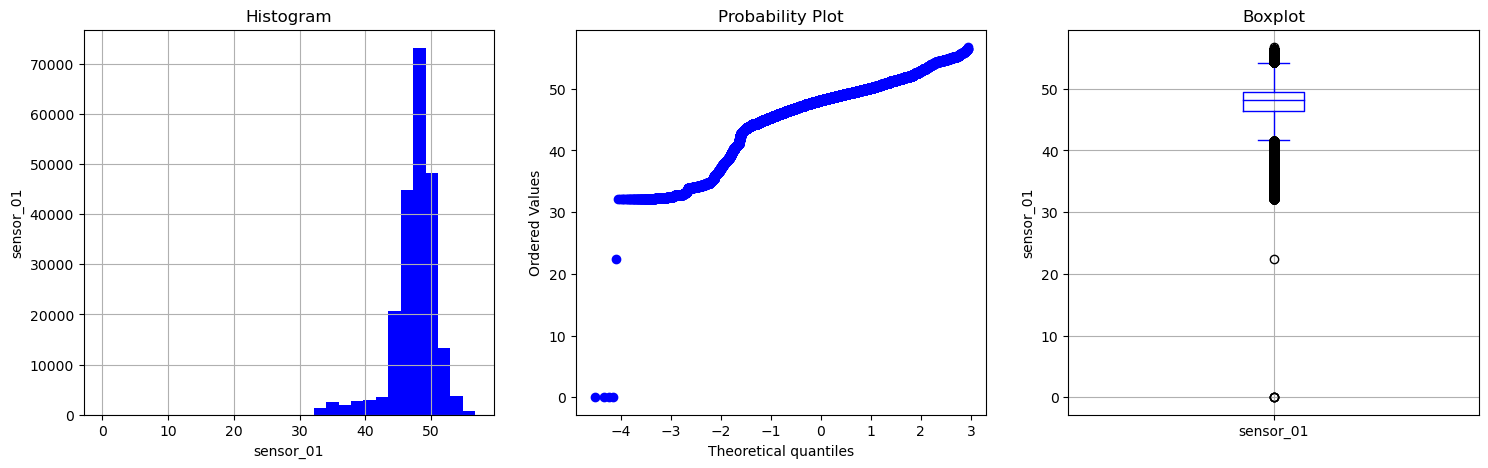

<Figure size 640x480 with 0 Axes>

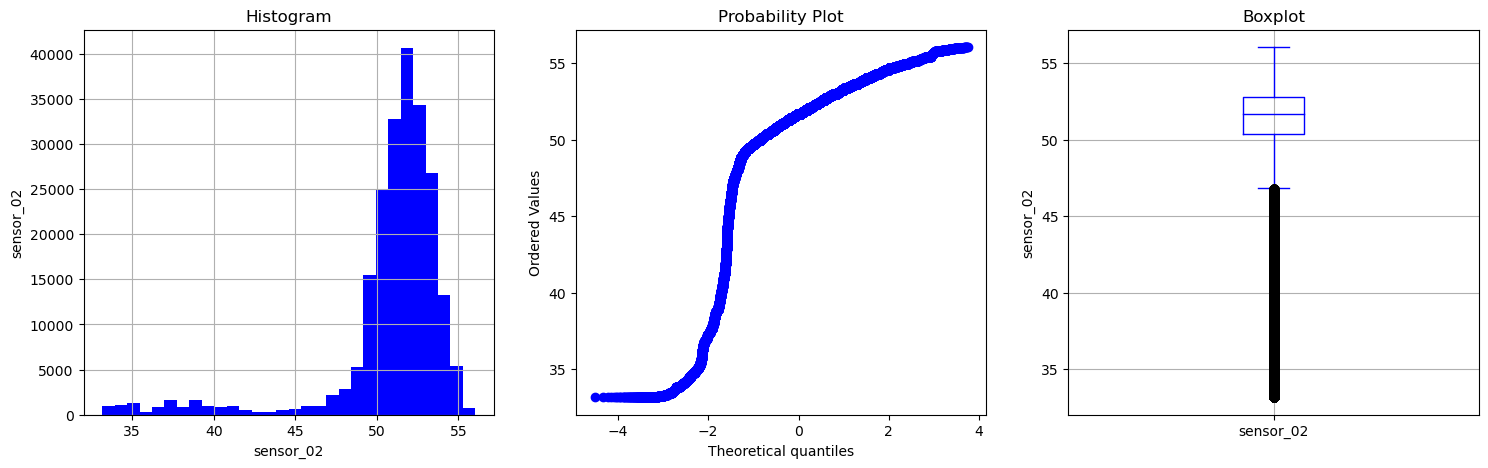

<Figure size 640x480 with 0 Axes>

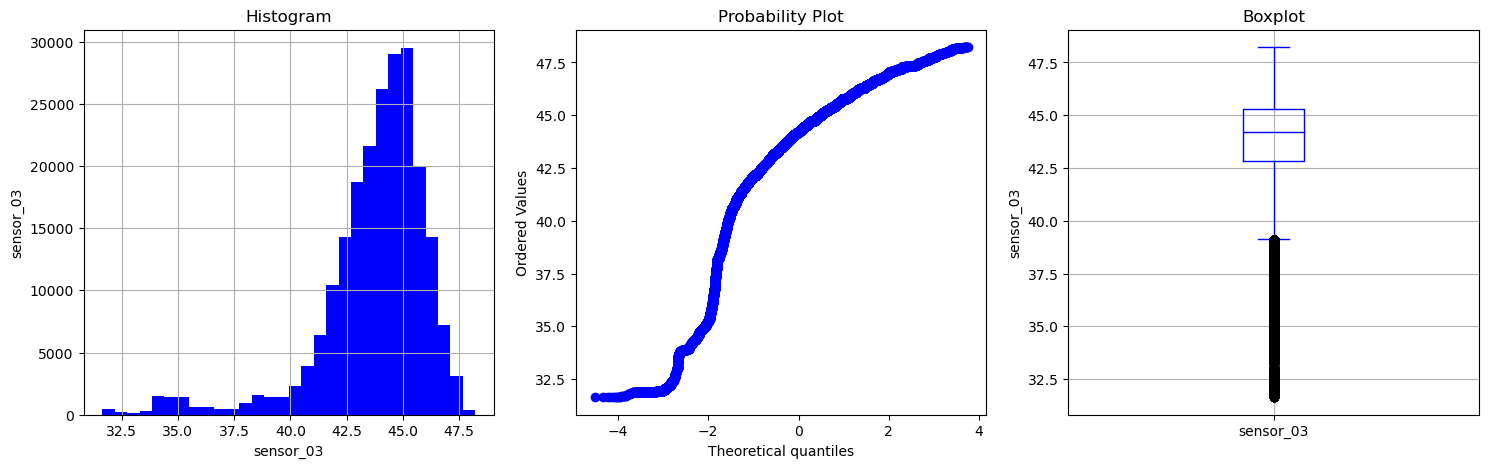

<Figure size 640x480 with 0 Axes>

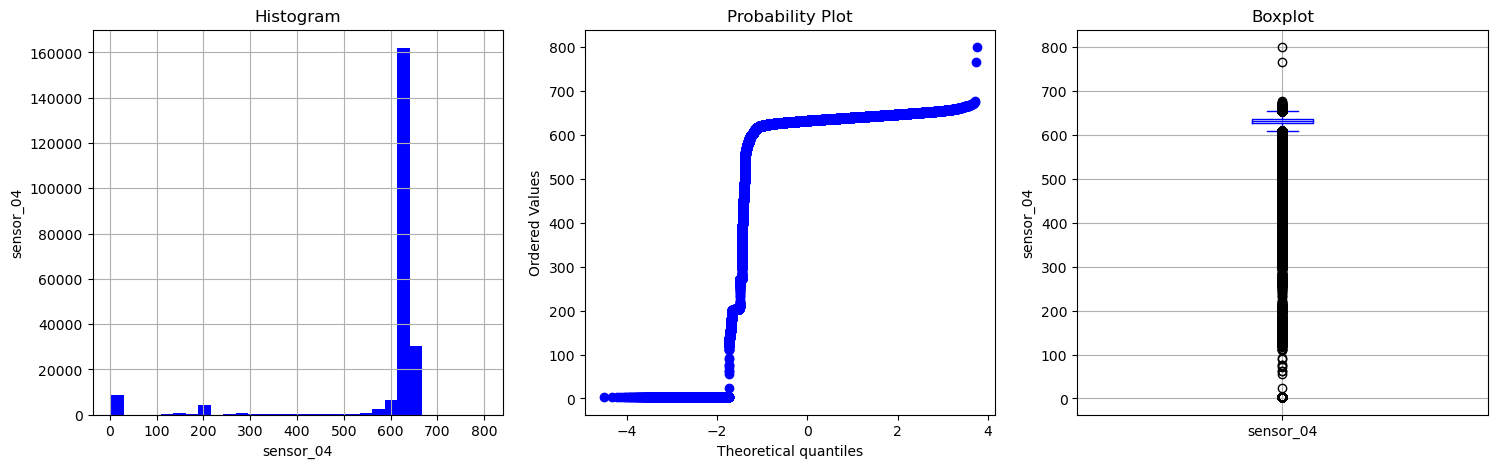

<Figure size 640x480 with 0 Axes>

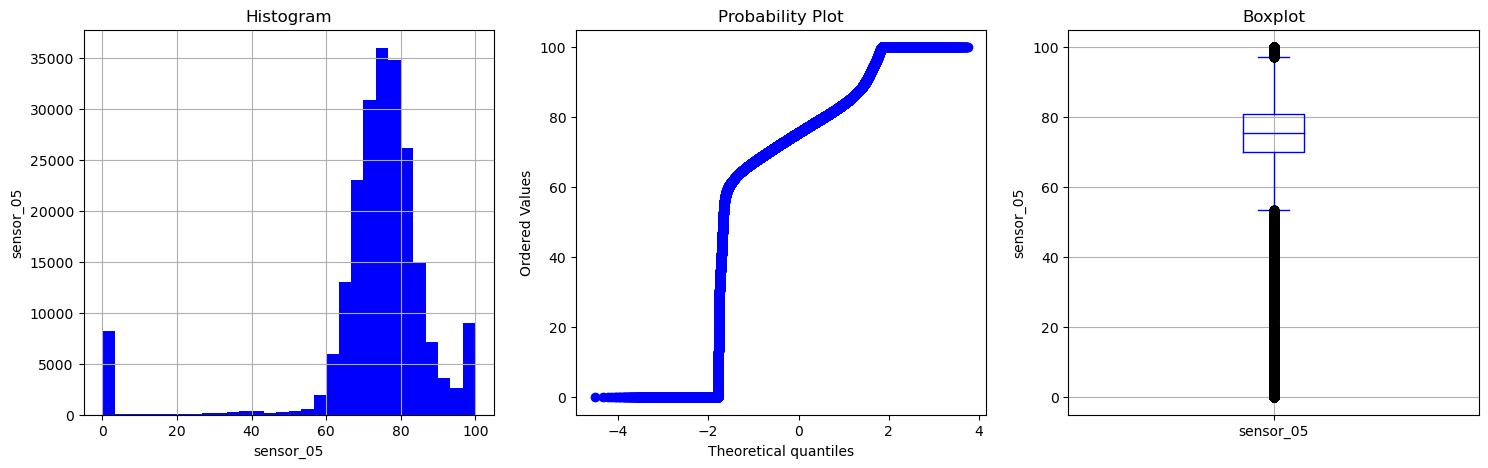

<Figure size 640x480 with 0 Axes>

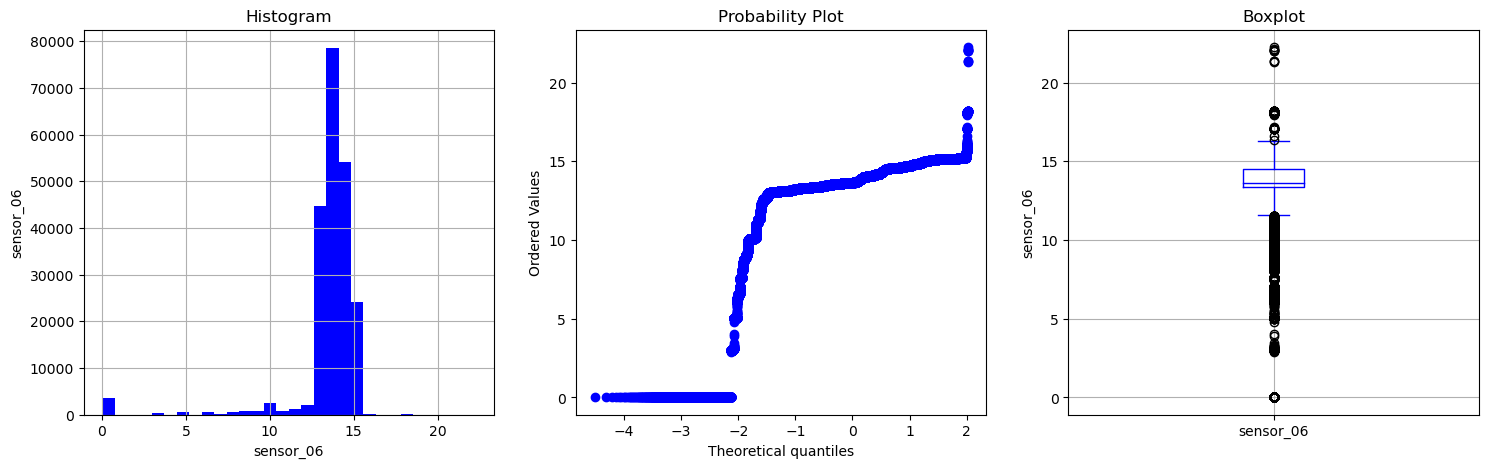

<Figure size 640x480 with 0 Axes>

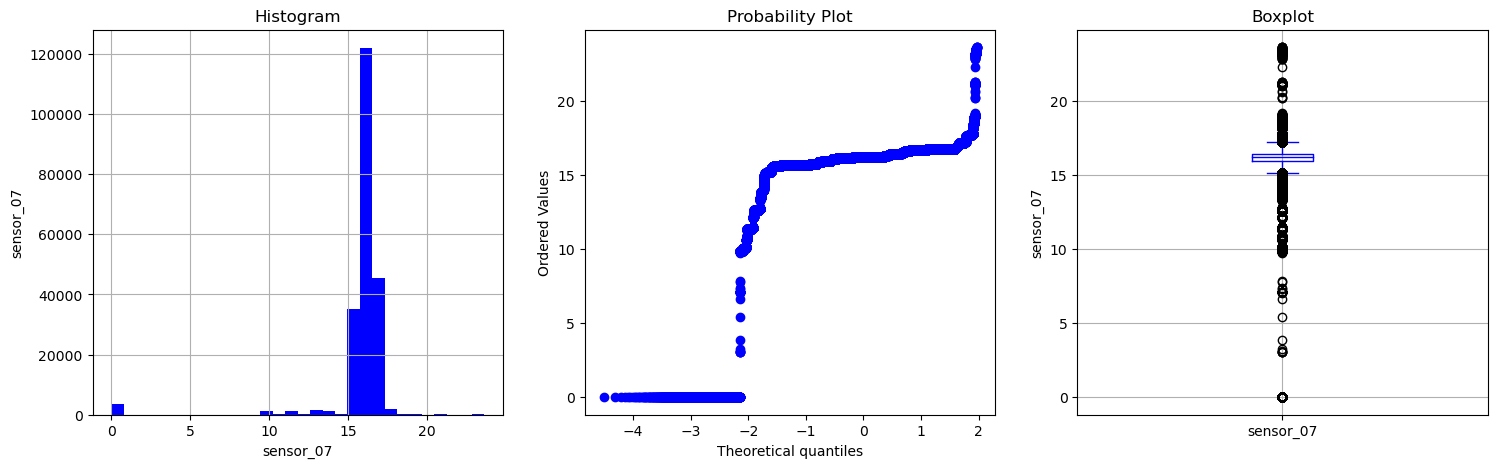

<Figure size 640x480 with 0 Axes>

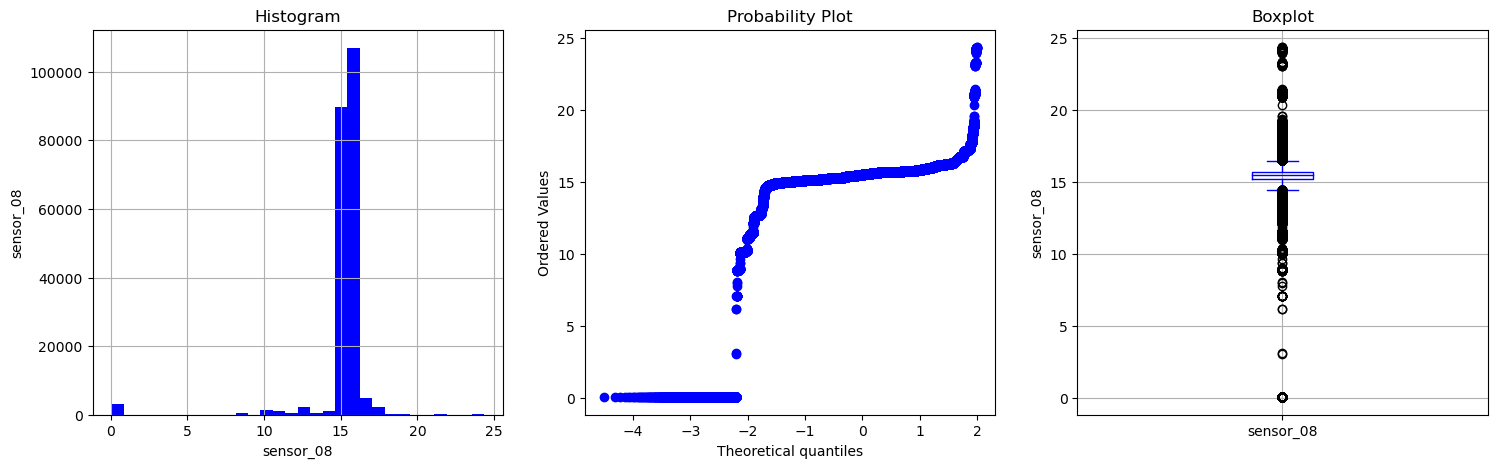

<Figure size 640x480 with 0 Axes>

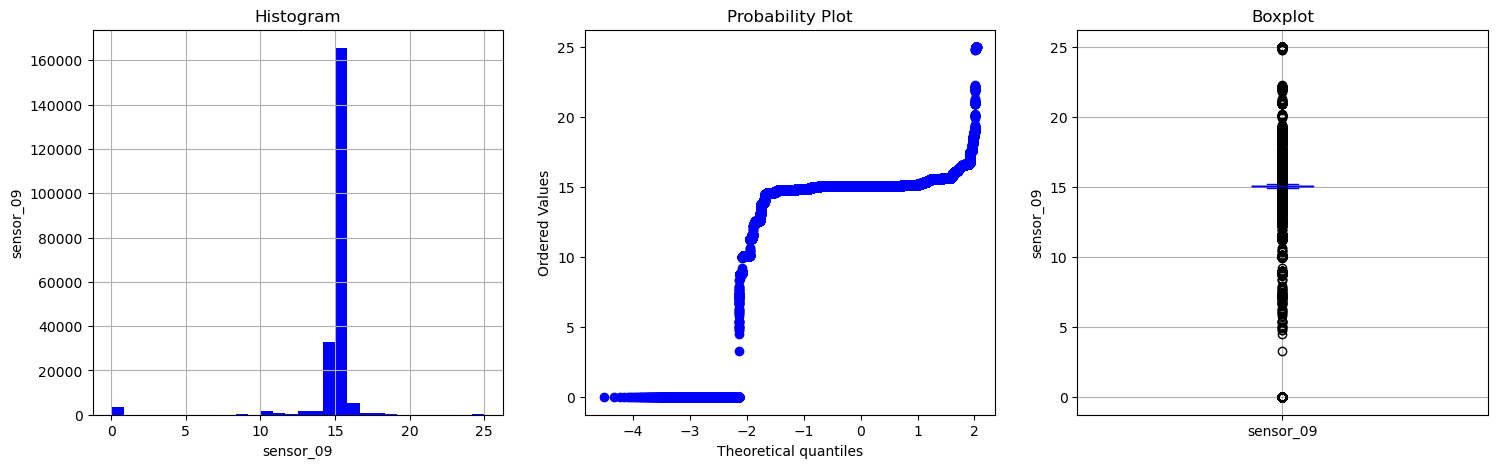

<Figure size 640x480 with 0 Axes>

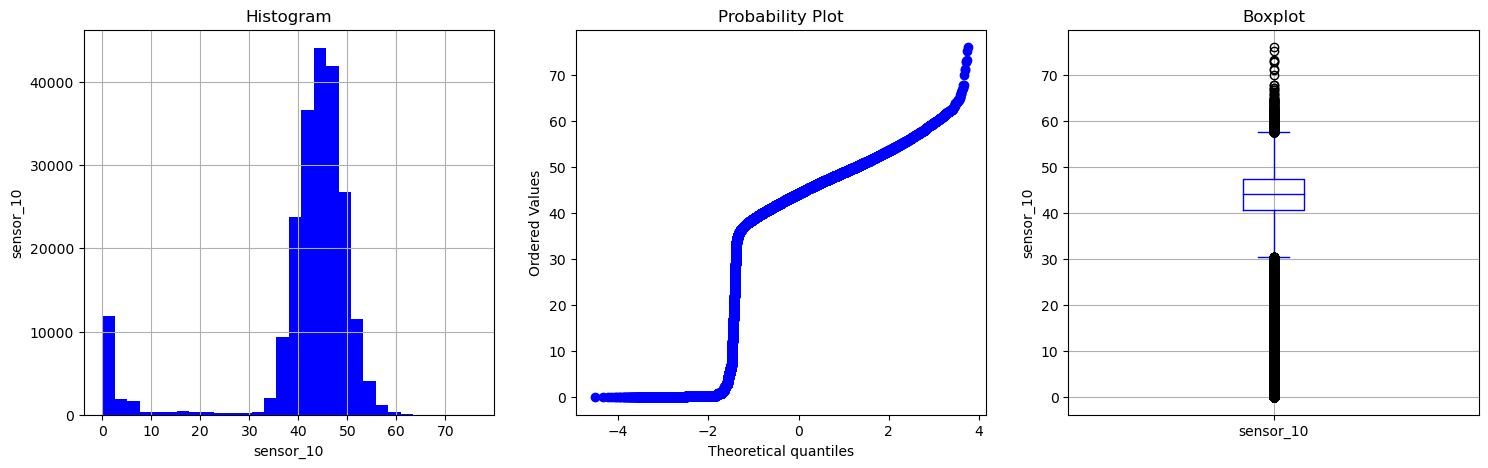

<Figure size 640x480 with 0 Axes>

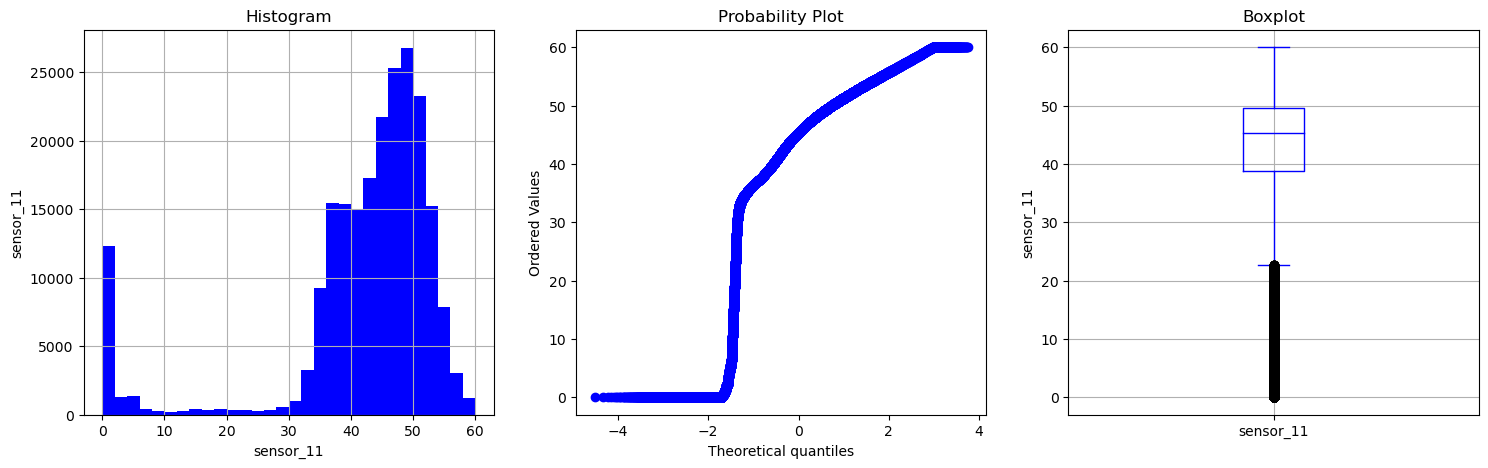

<Figure size 640x480 with 0 Axes>

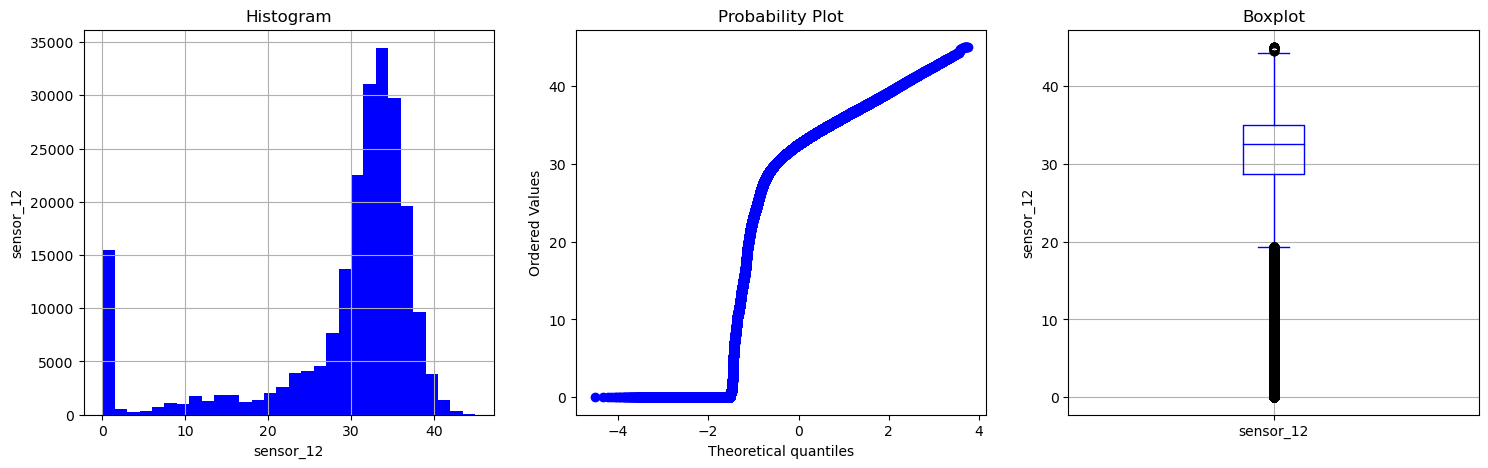

<Figure size 640x480 with 0 Axes>

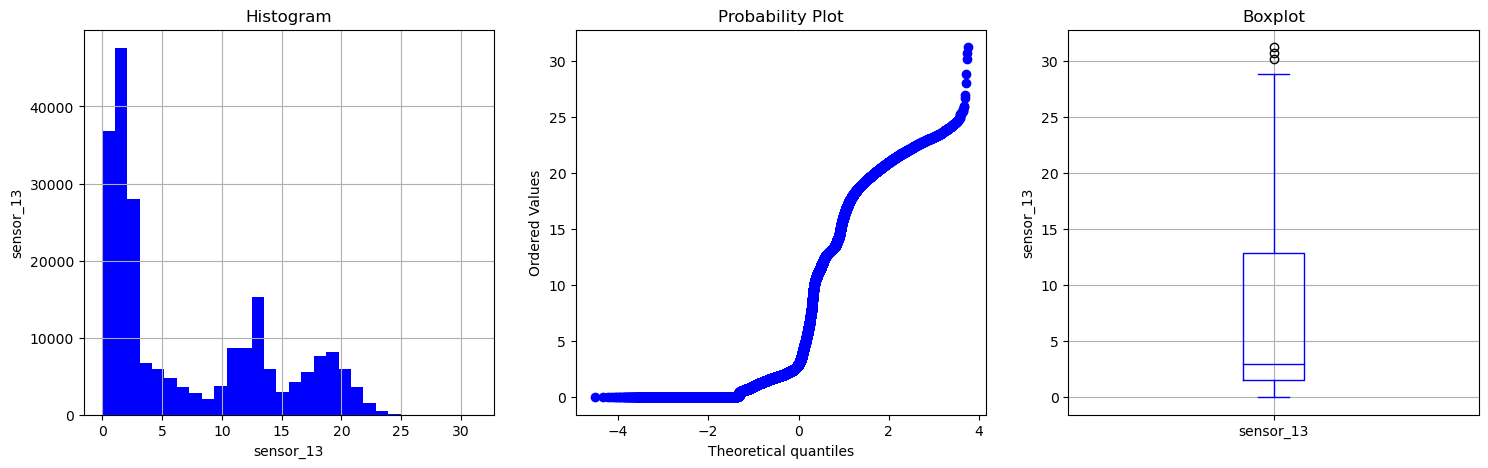

<Figure size 640x480 with 0 Axes>

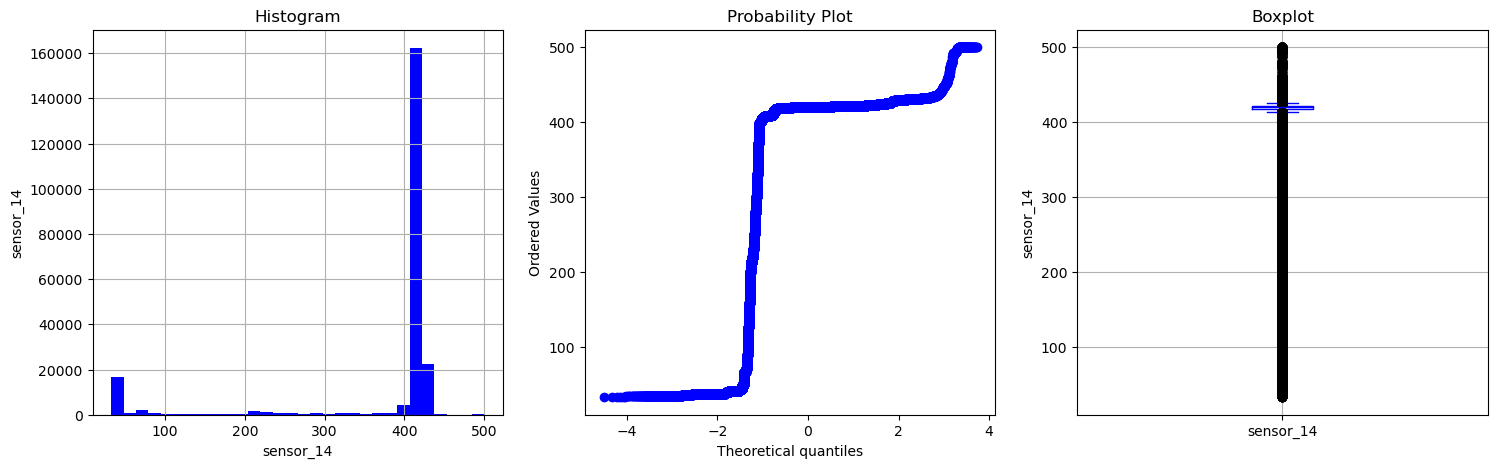

<Figure size 640x480 with 0 Axes>

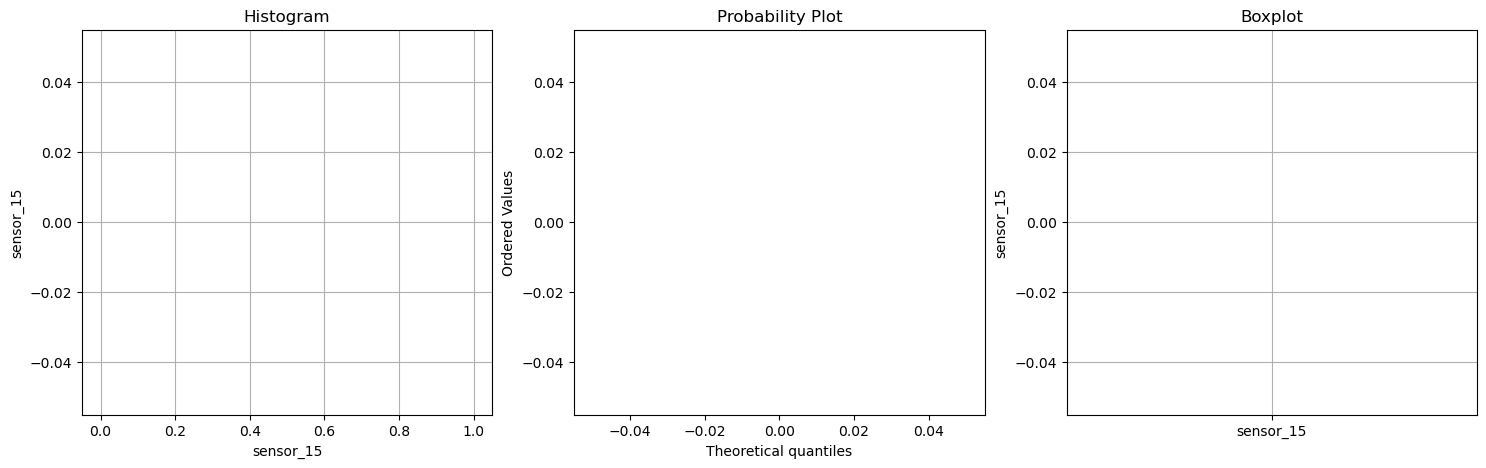

<Figure size 640x480 with 0 Axes>

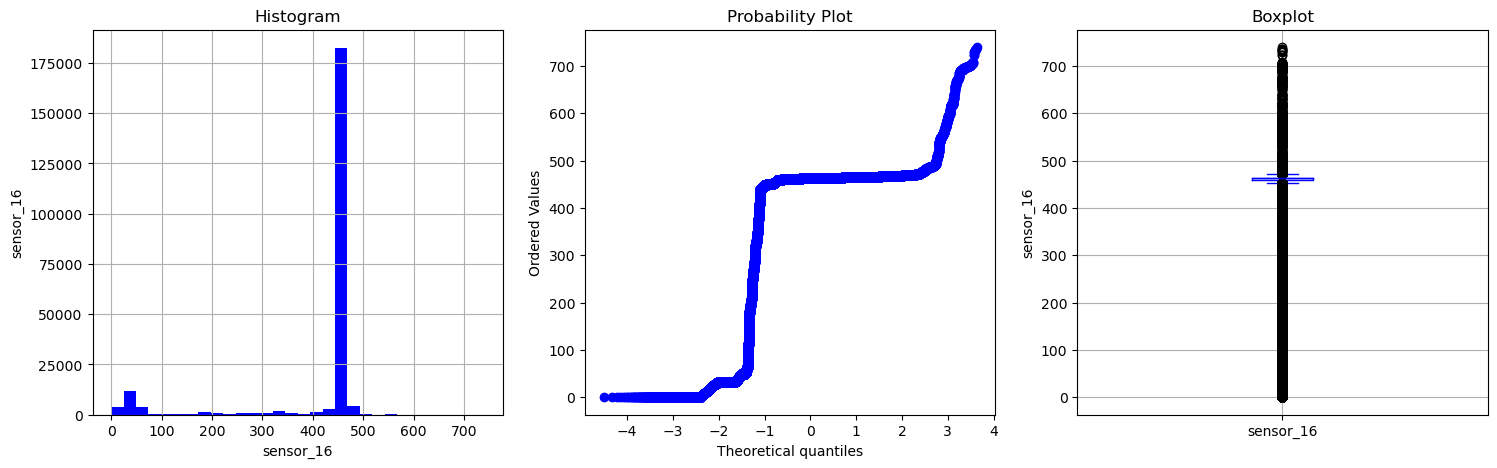

<Figure size 640x480 with 0 Axes>

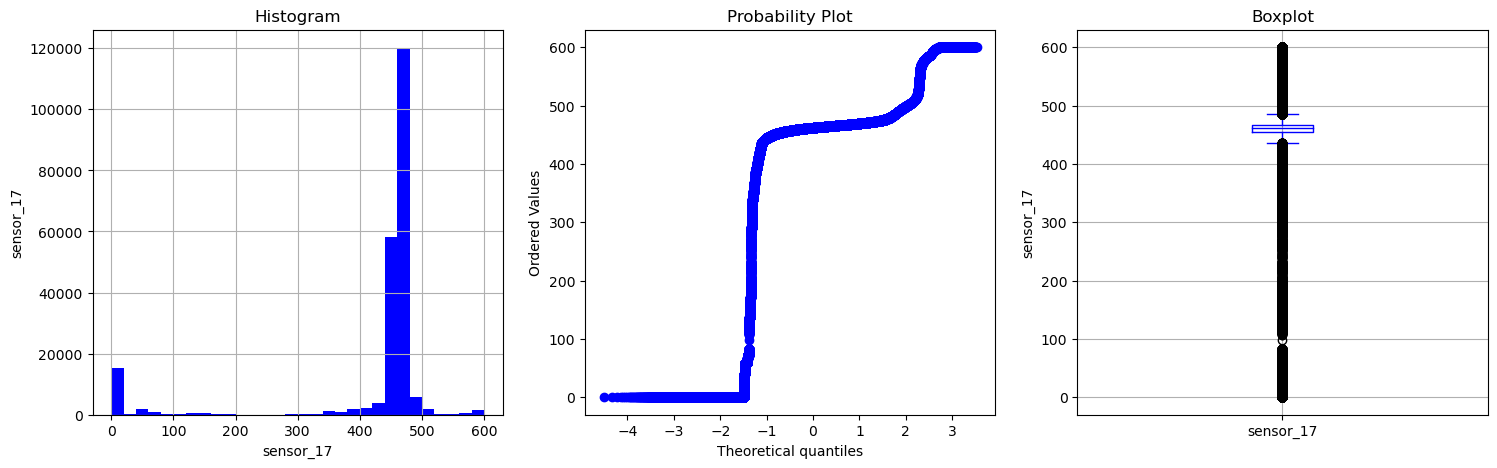

<Figure size 640x480 with 0 Axes>

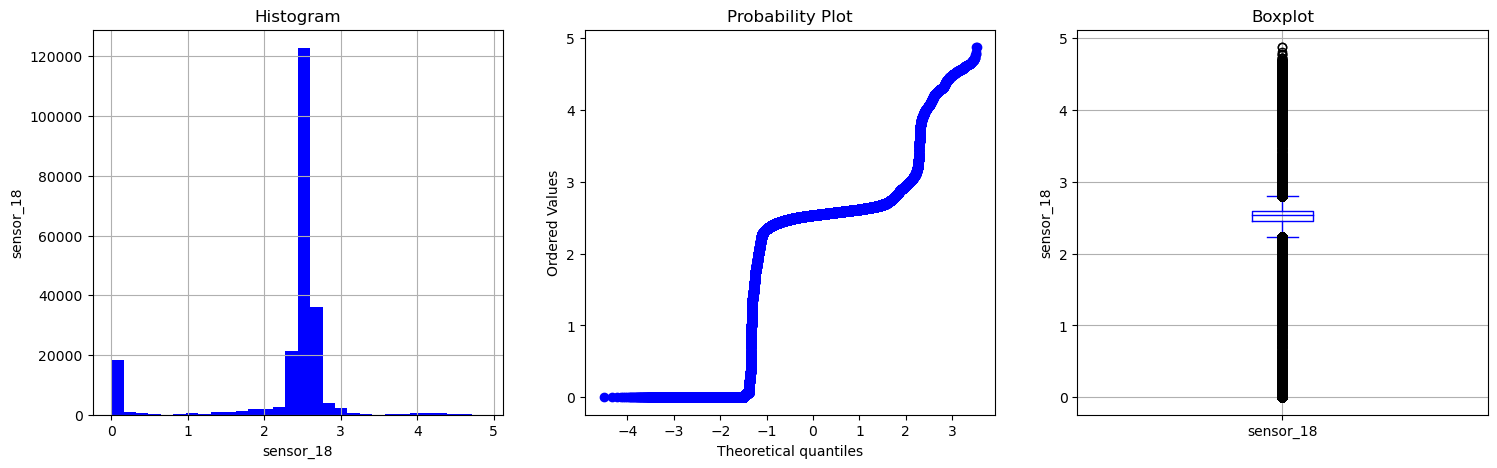

<Figure size 640x480 with 0 Axes>

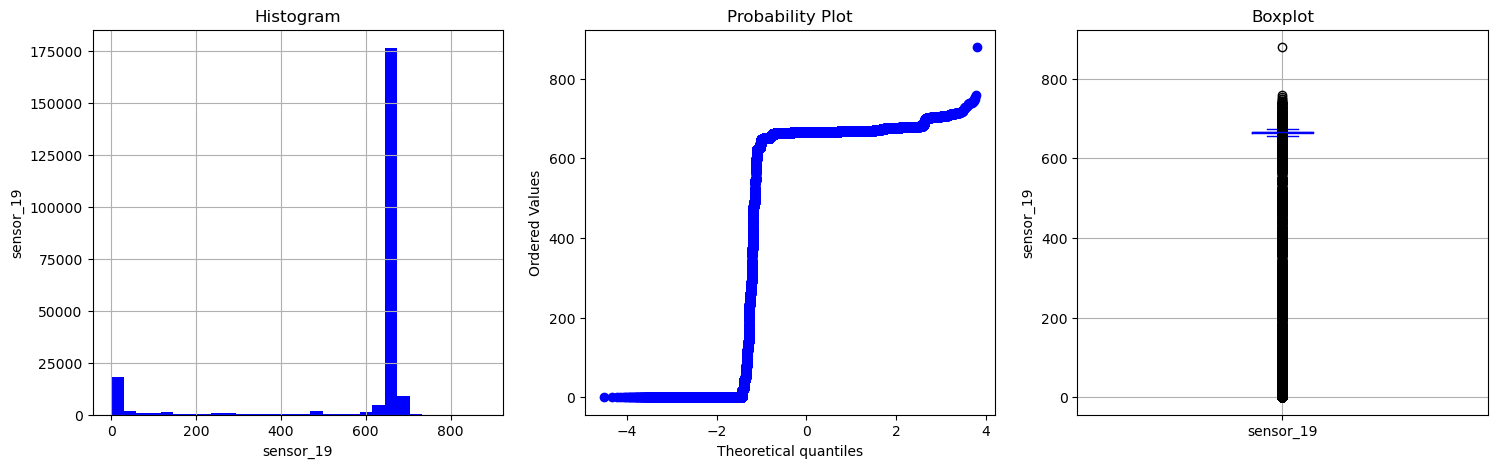

<Figure size 640x480 with 0 Axes>

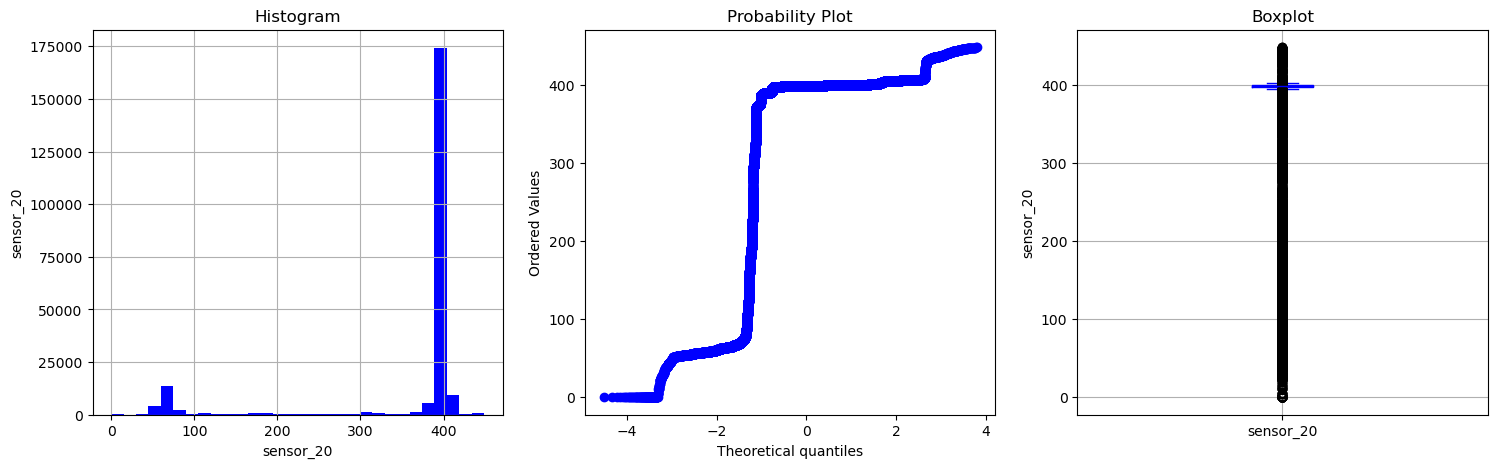

<Figure size 640x480 with 0 Axes>

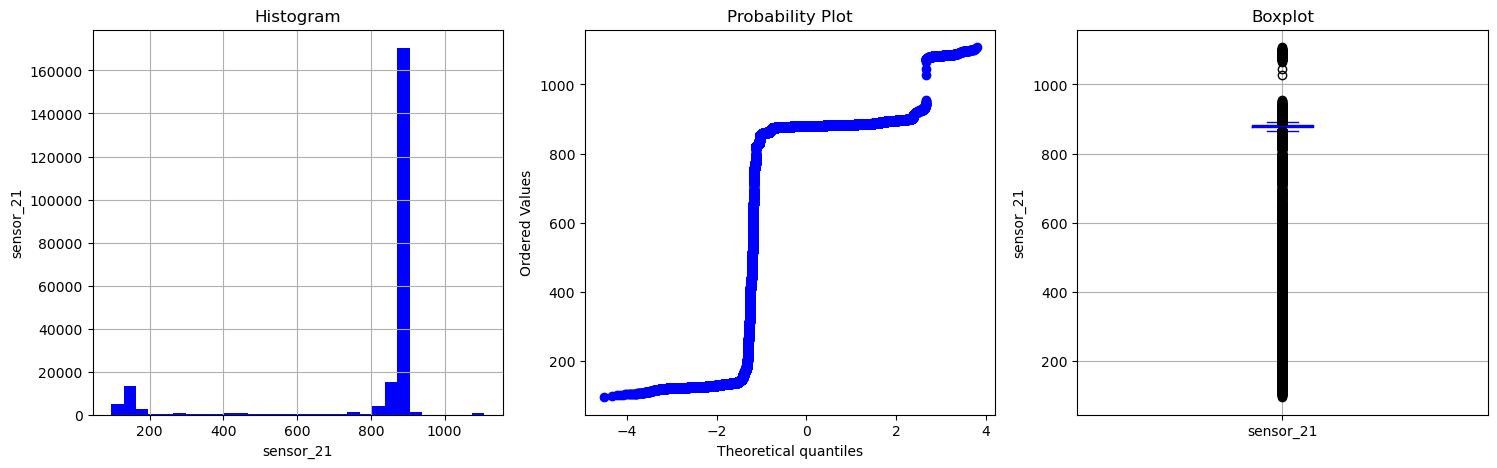

<Figure size 640x480 with 0 Axes>

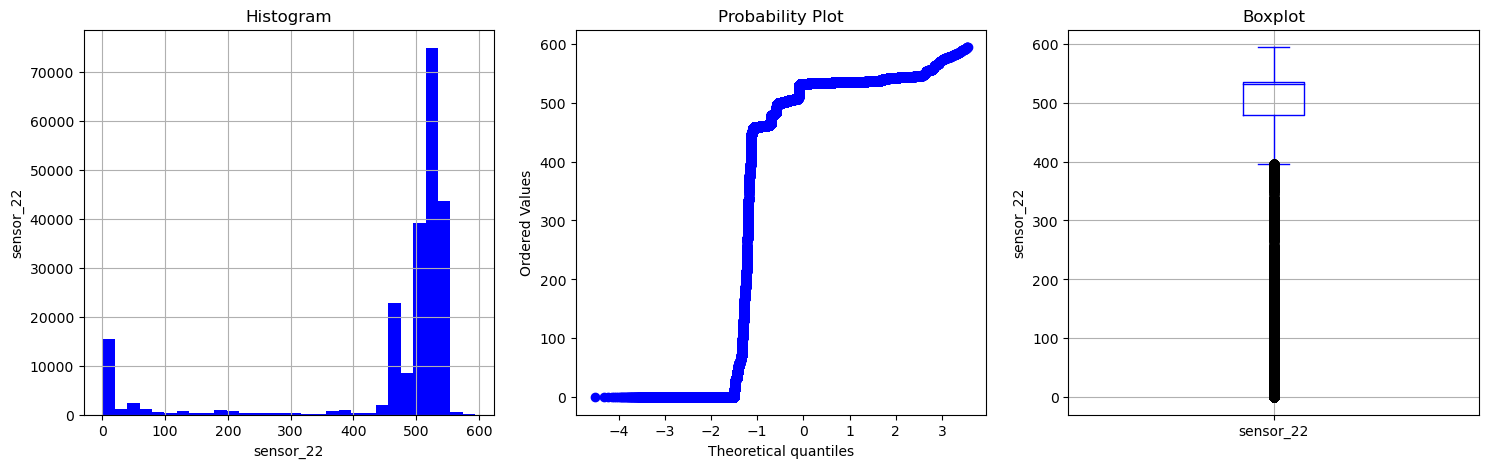

<Figure size 640x480 with 0 Axes>

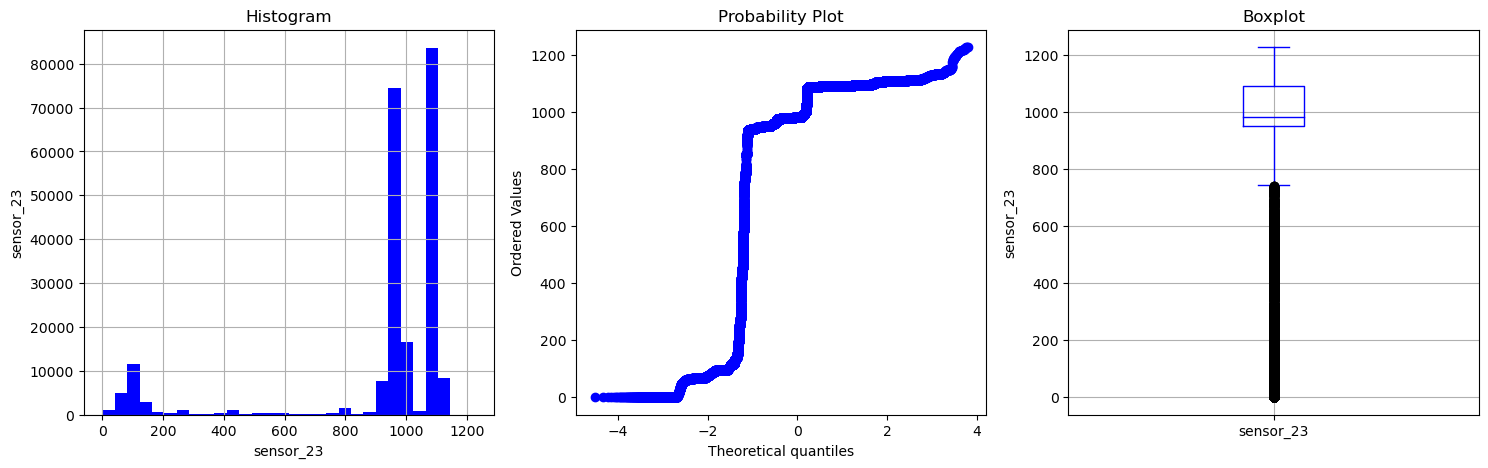

<Figure size 640x480 with 0 Axes>

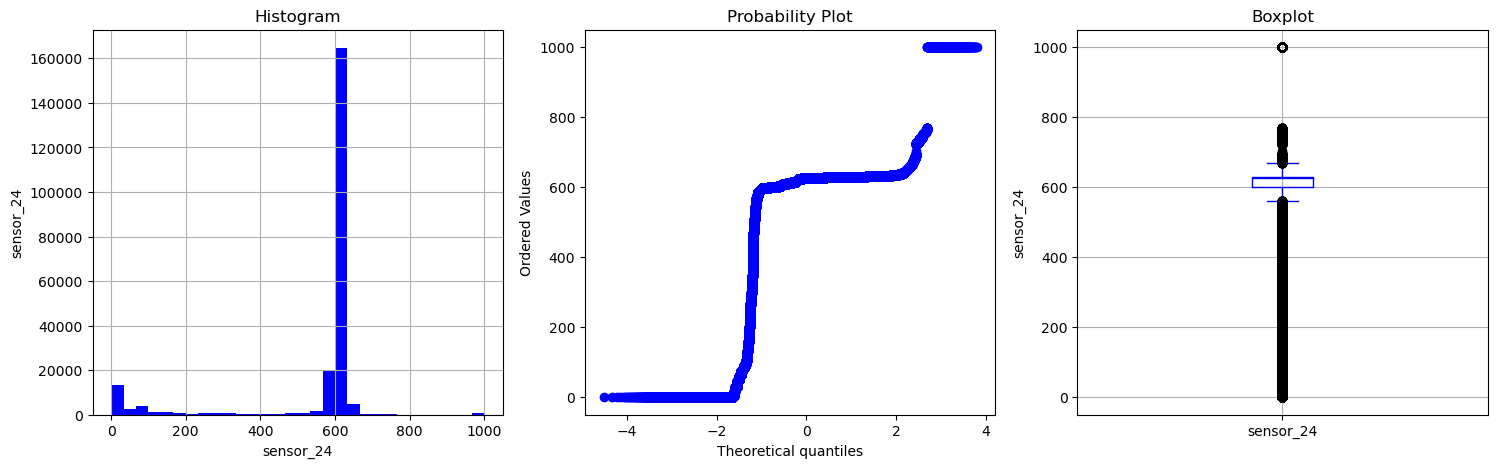

<Figure size 640x480 with 0 Axes>

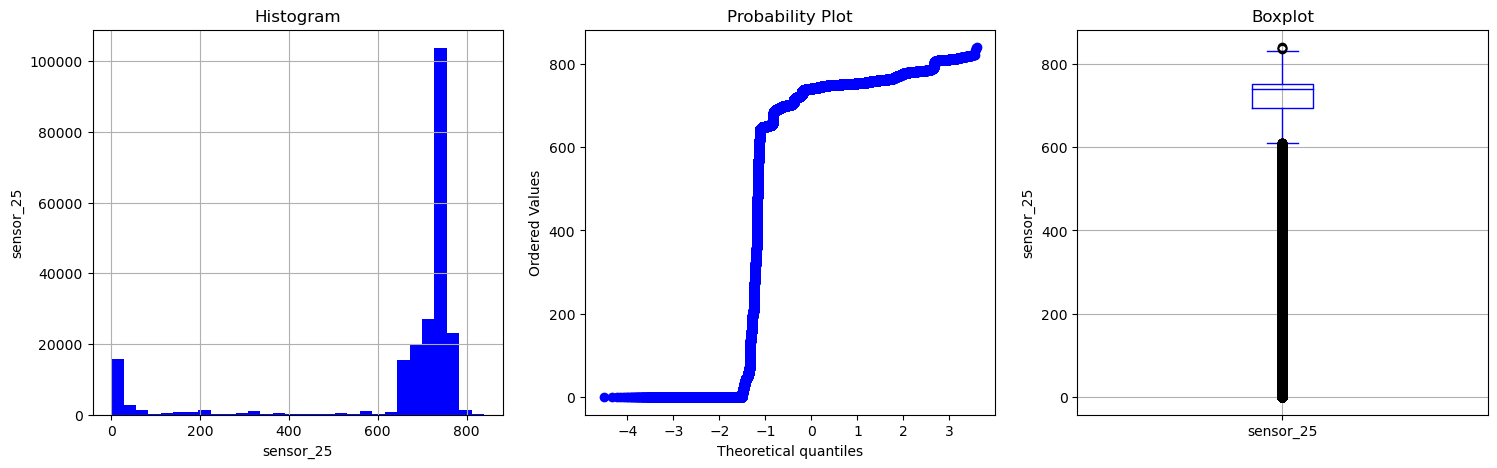

<Figure size 640x480 with 0 Axes>

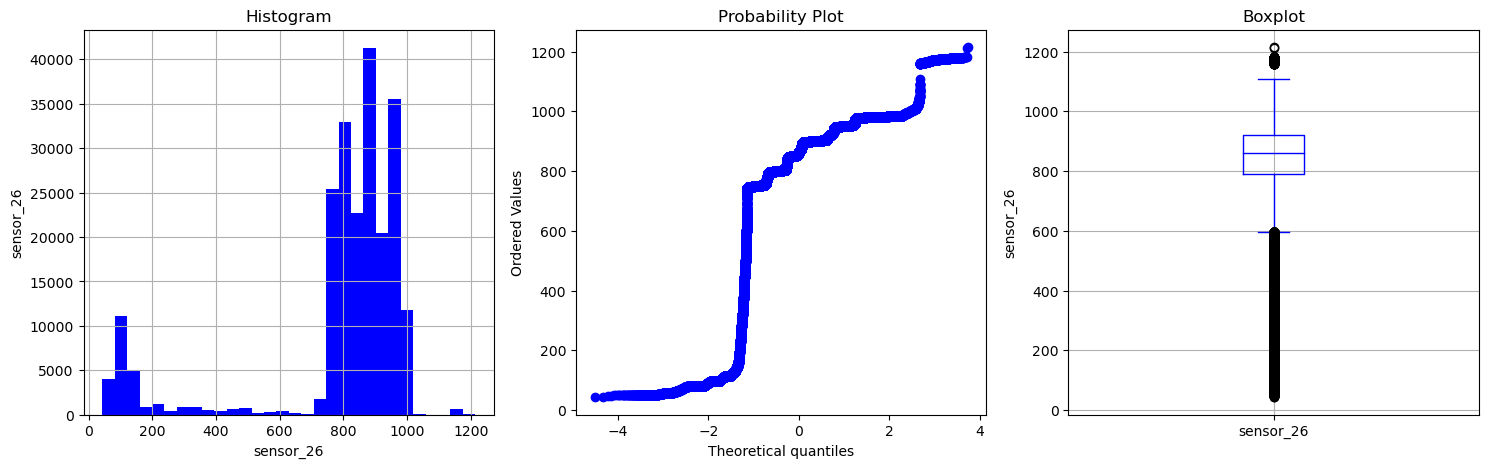

<Figure size 640x480 with 0 Axes>

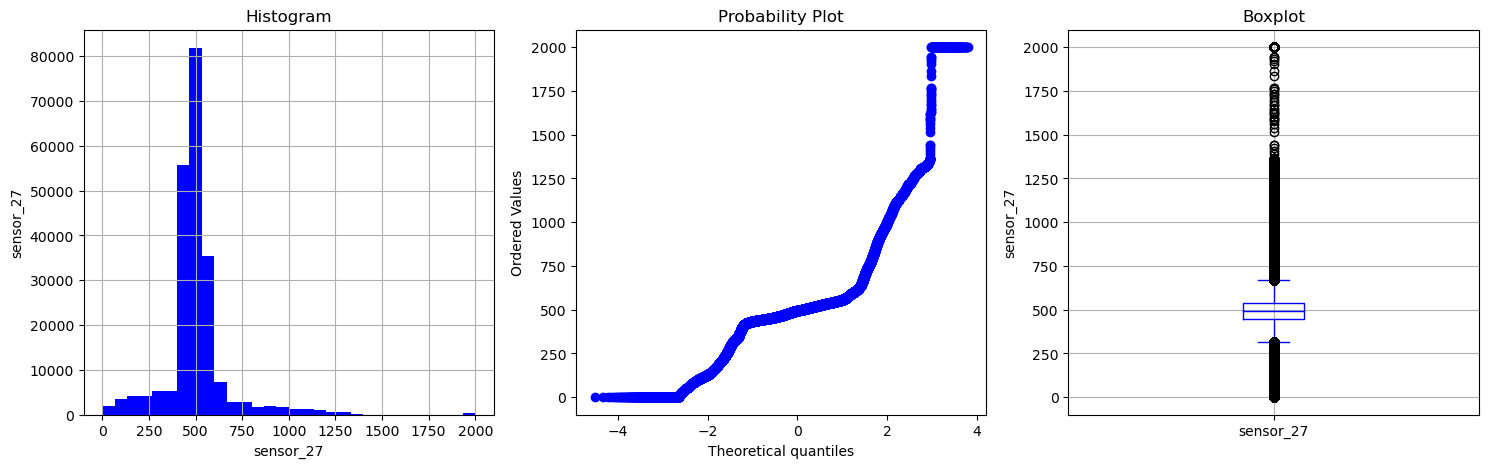

<Figure size 640x480 with 0 Axes>

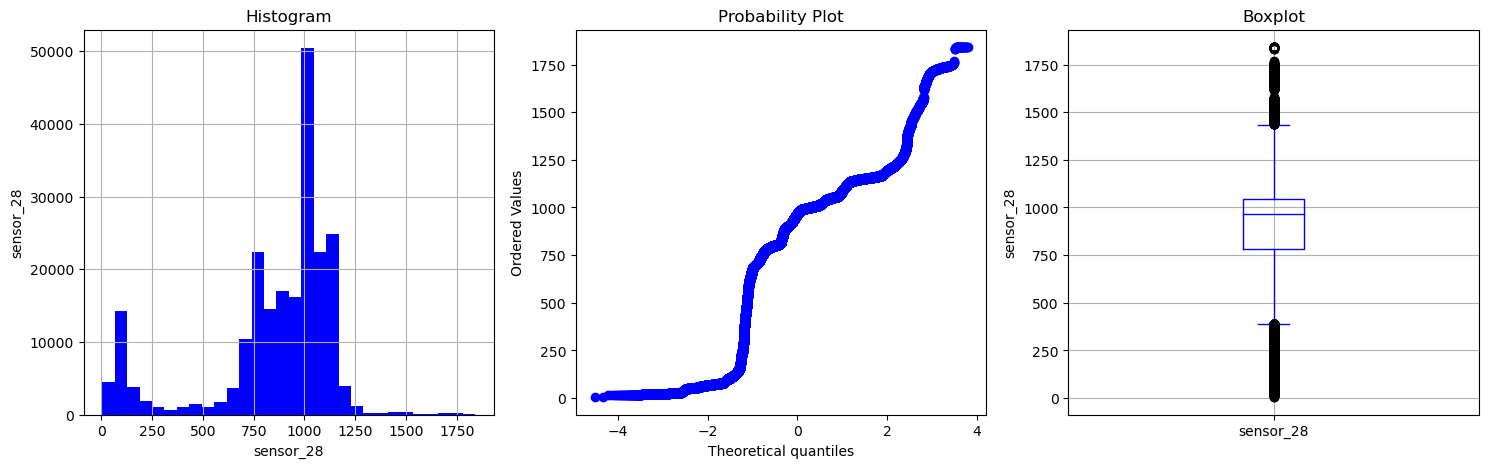

<Figure size 640x480 with 0 Axes>

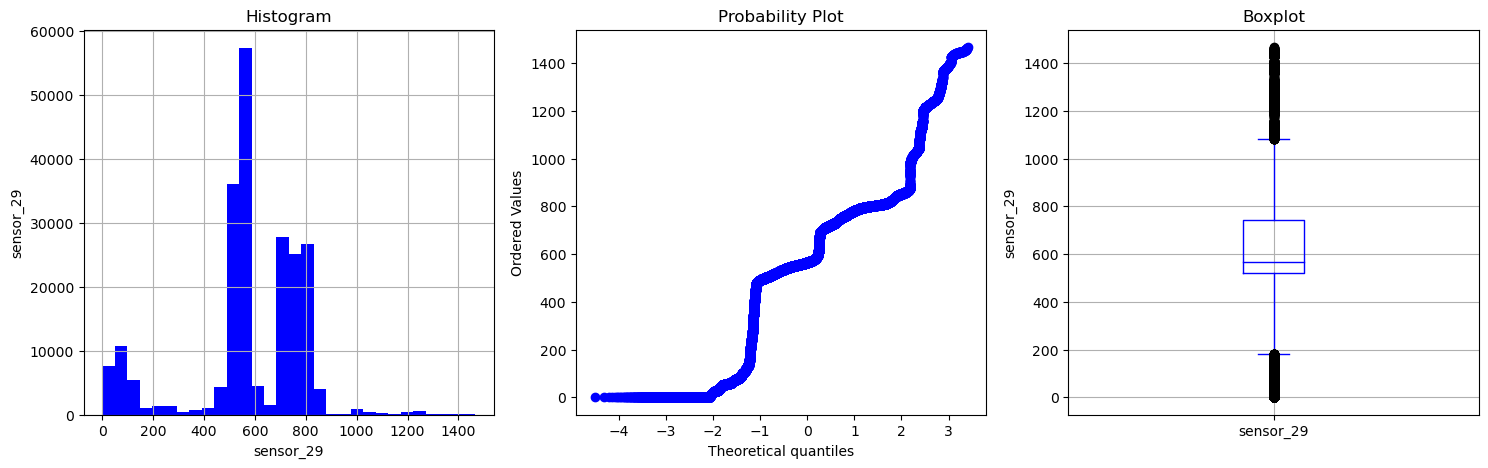

<Figure size 640x480 with 0 Axes>

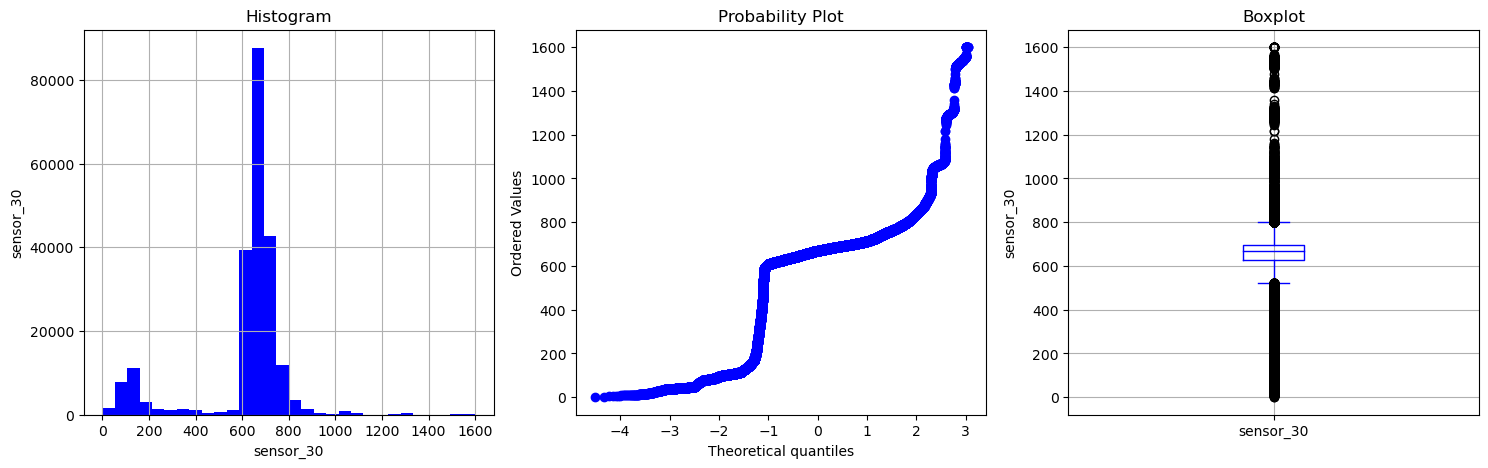

<Figure size 640x480 with 0 Axes>

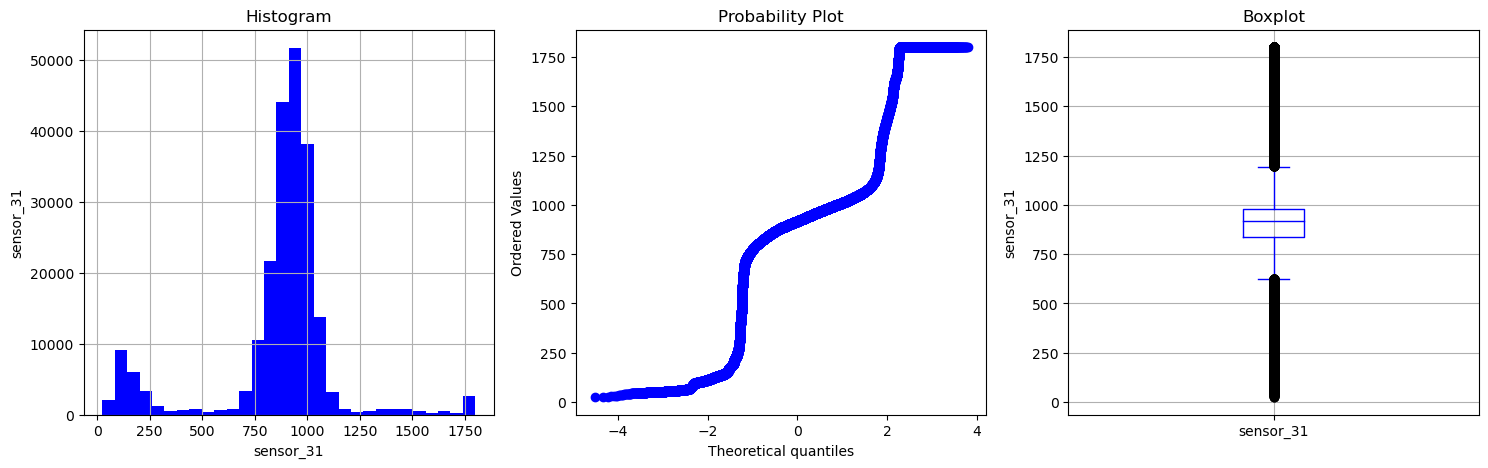

<Figure size 640x480 with 0 Axes>

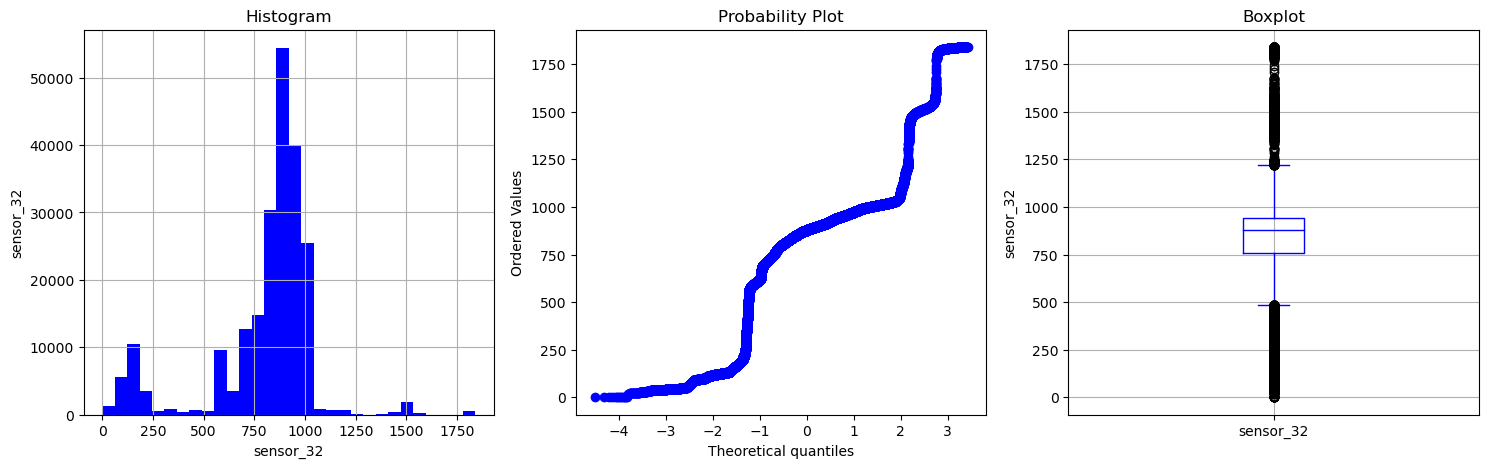

<Figure size 640x480 with 0 Axes>

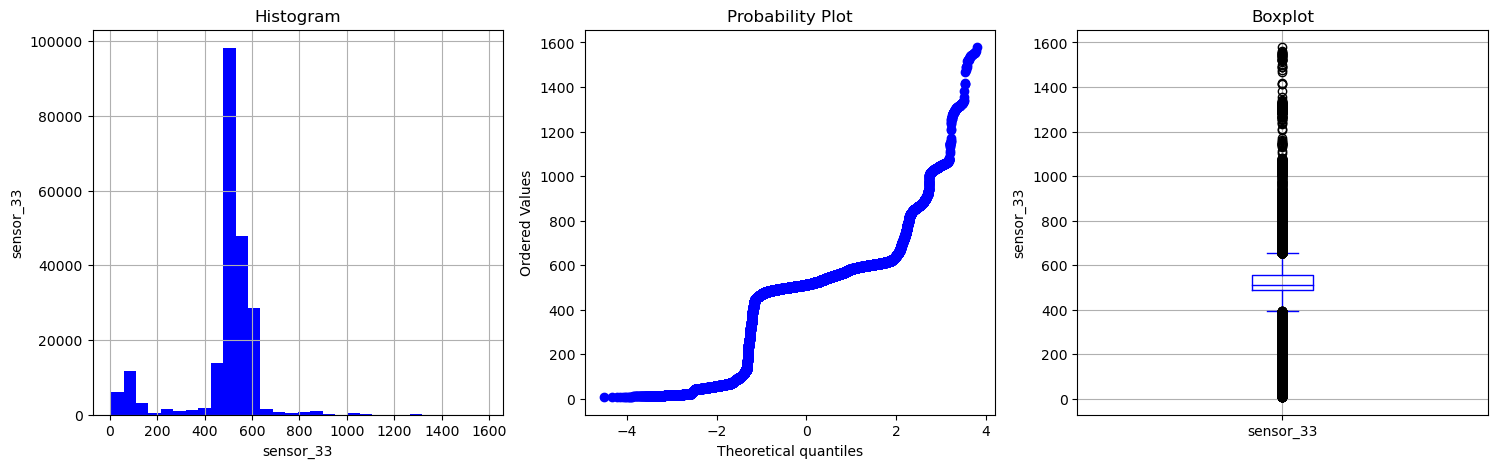

<Figure size 640x480 with 0 Axes>

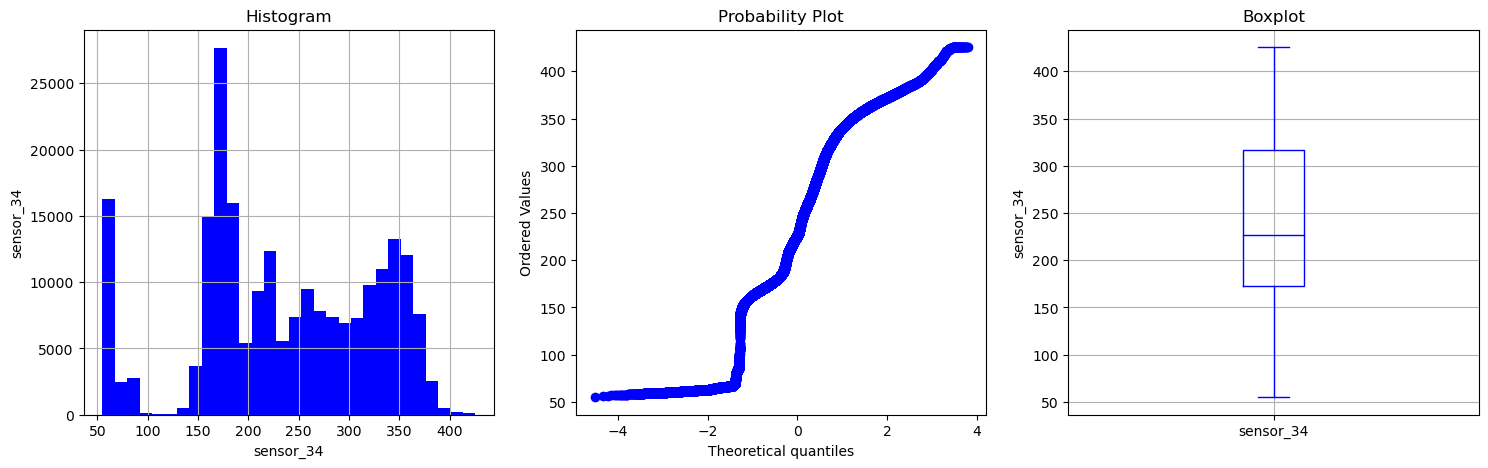

<Figure size 640x480 with 0 Axes>

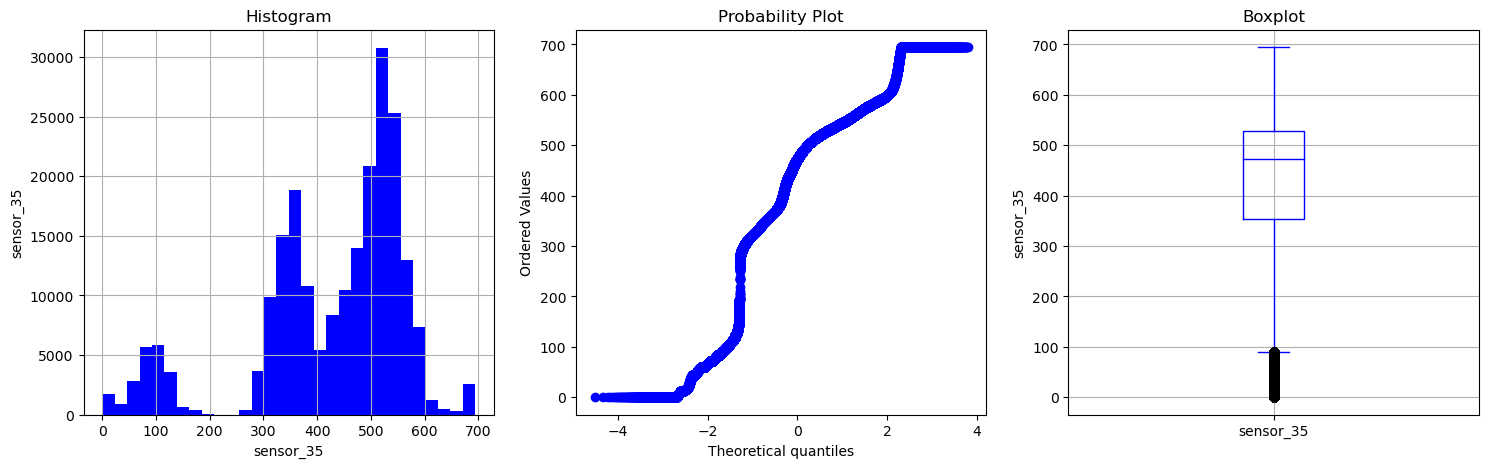

<Figure size 640x480 with 0 Axes>

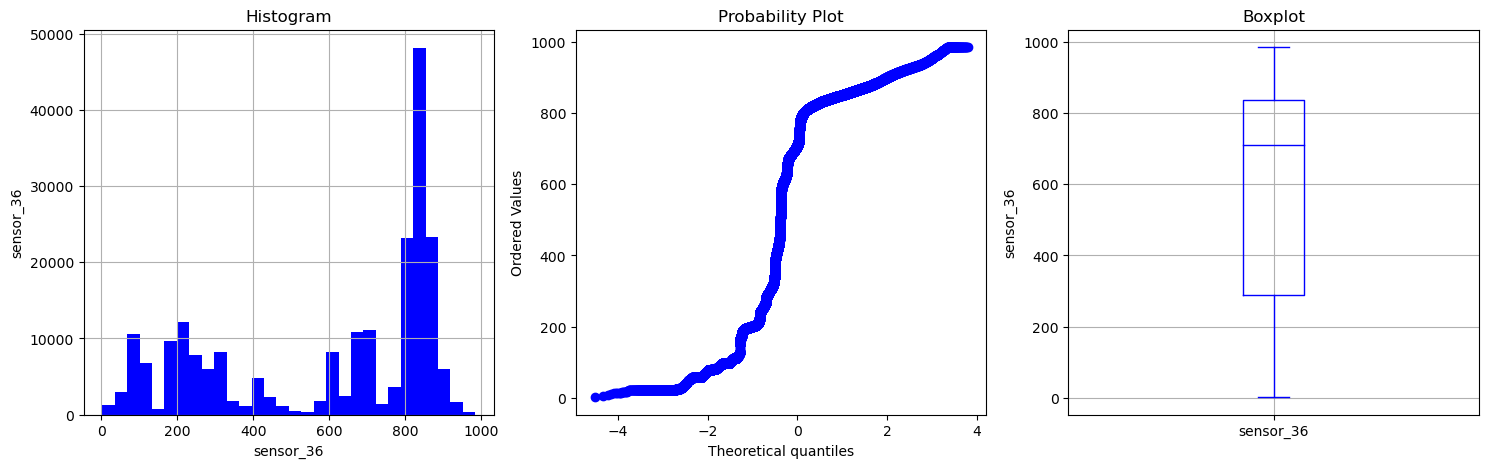

<Figure size 640x480 with 0 Axes>

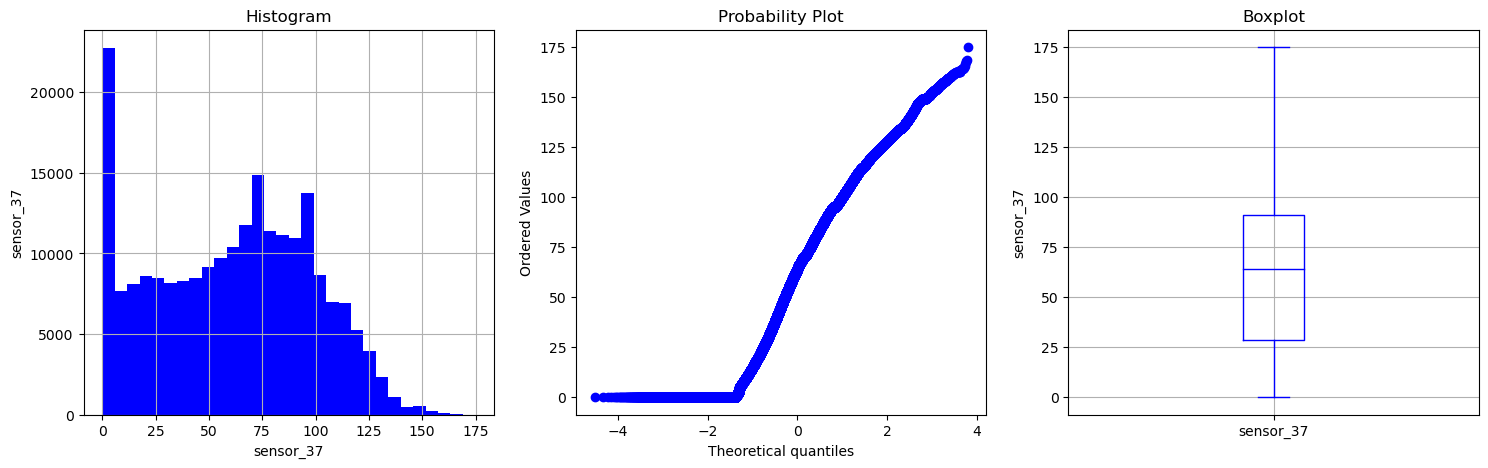

<Figure size 640x480 with 0 Axes>

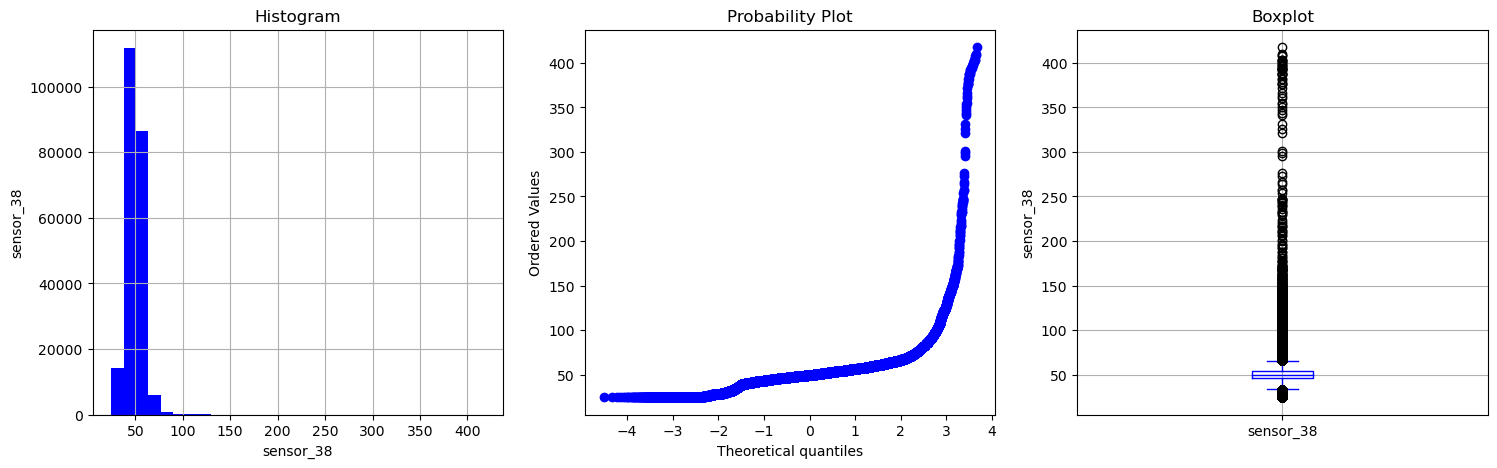

<Figure size 640x480 with 0 Axes>

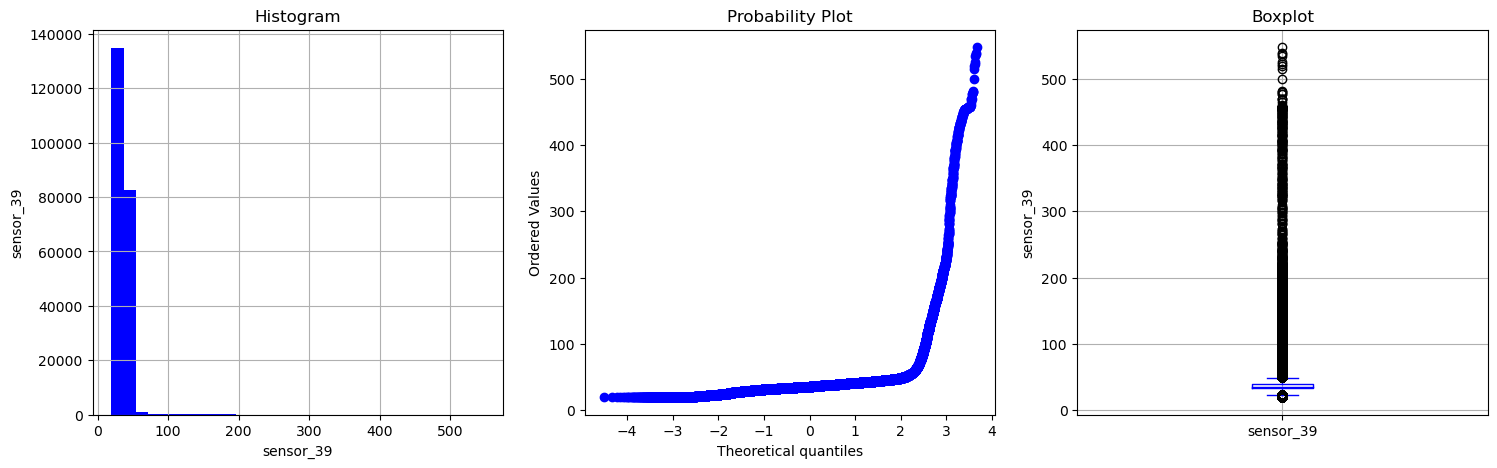

<Figure size 640x480 with 0 Axes>

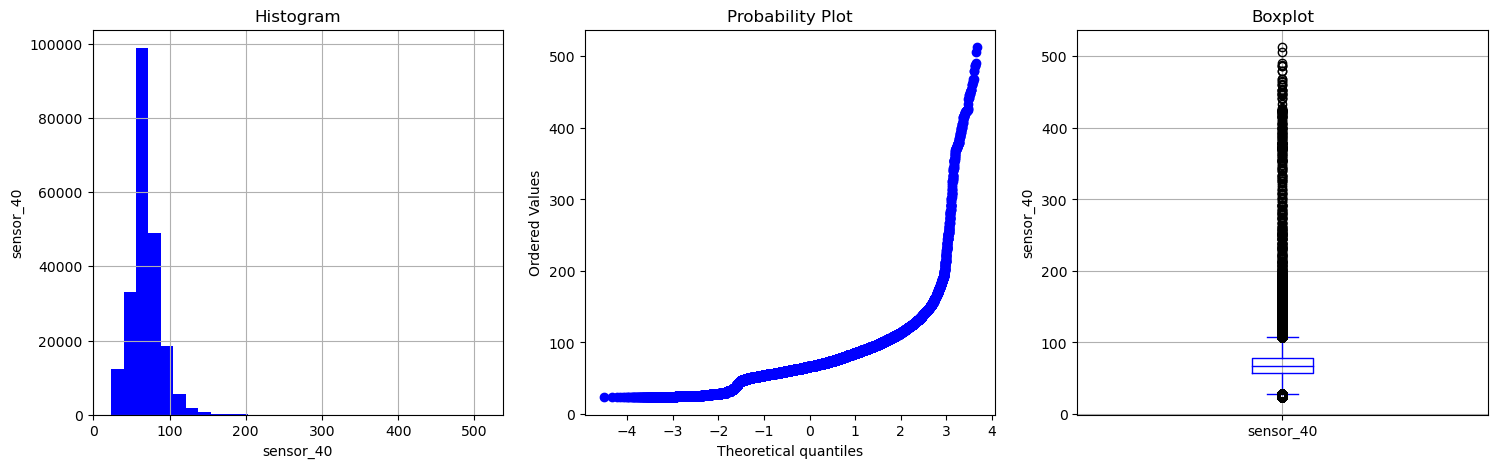

<Figure size 640x480 with 0 Axes>

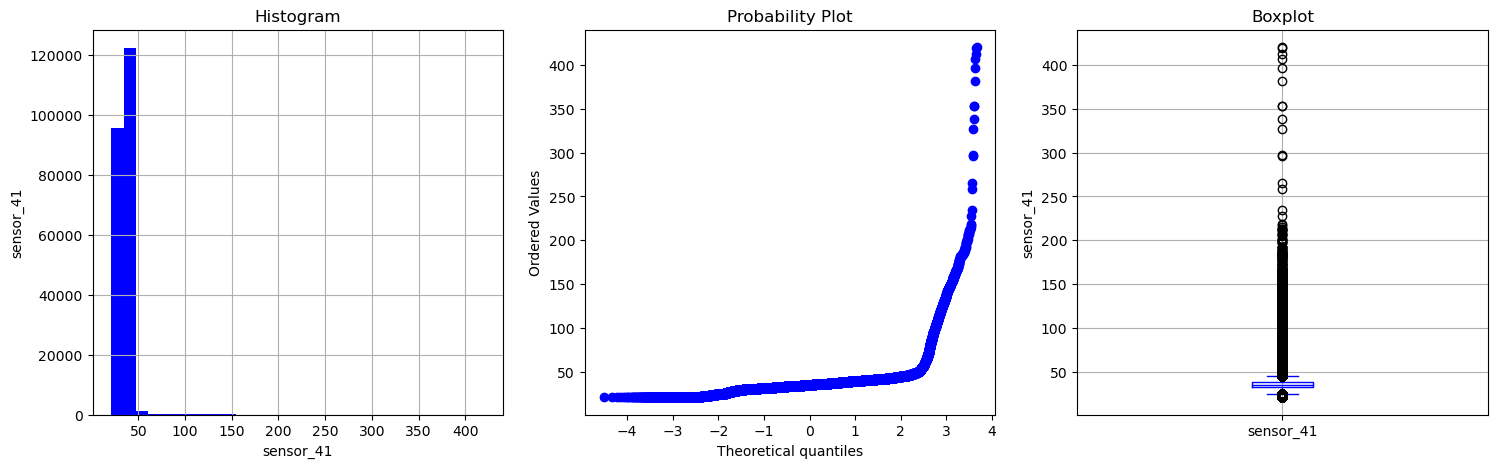

<Figure size 640x480 with 0 Axes>

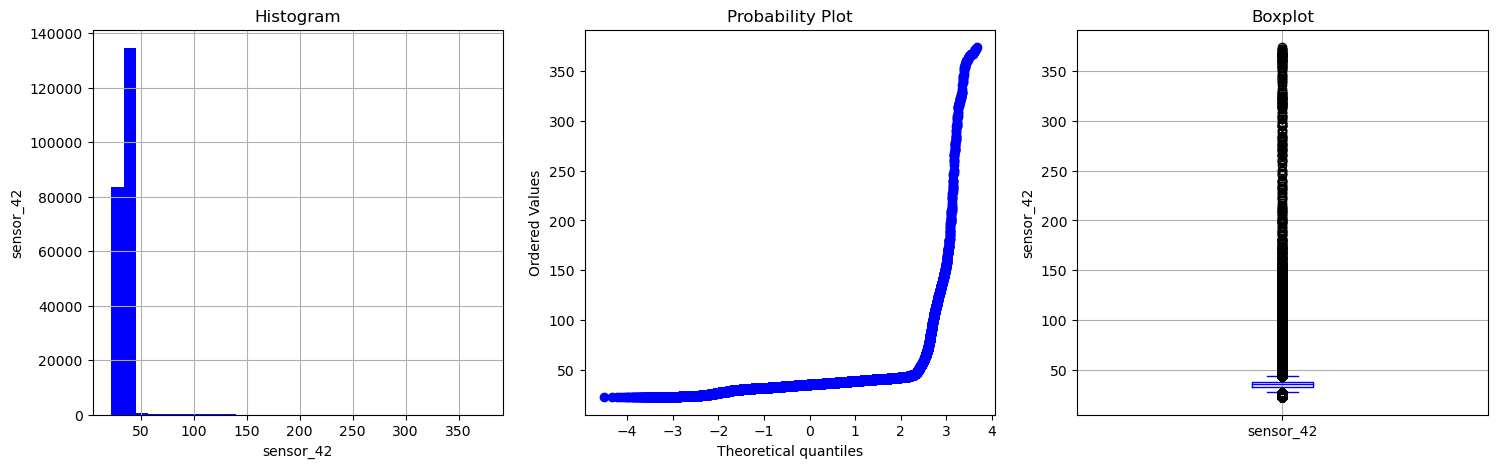

<Figure size 640x480 with 0 Axes>

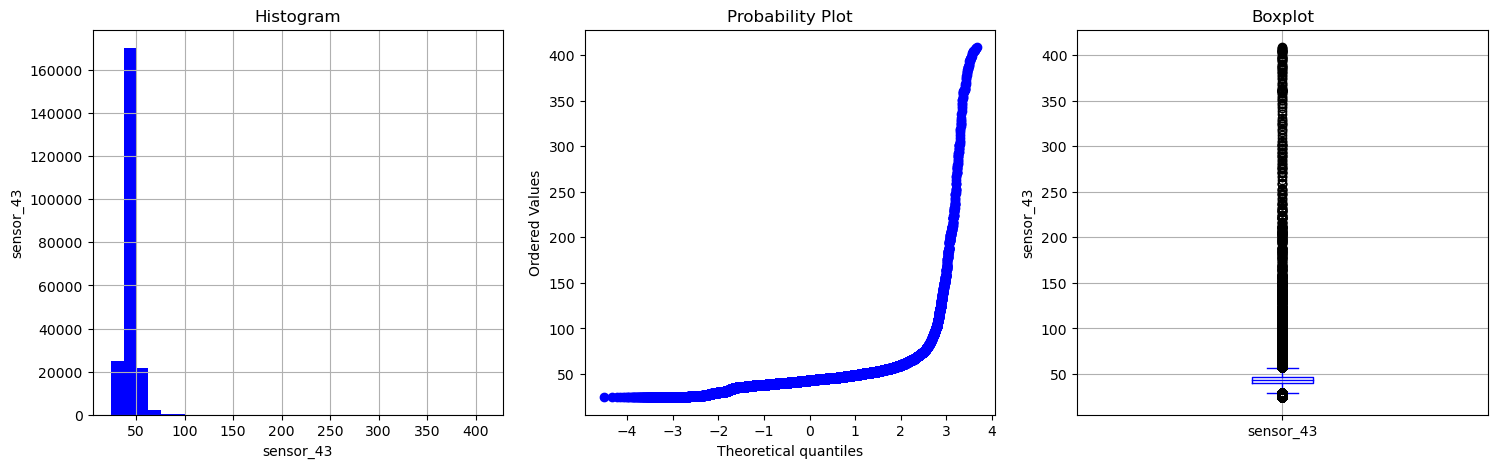

<Figure size 640x480 with 0 Axes>

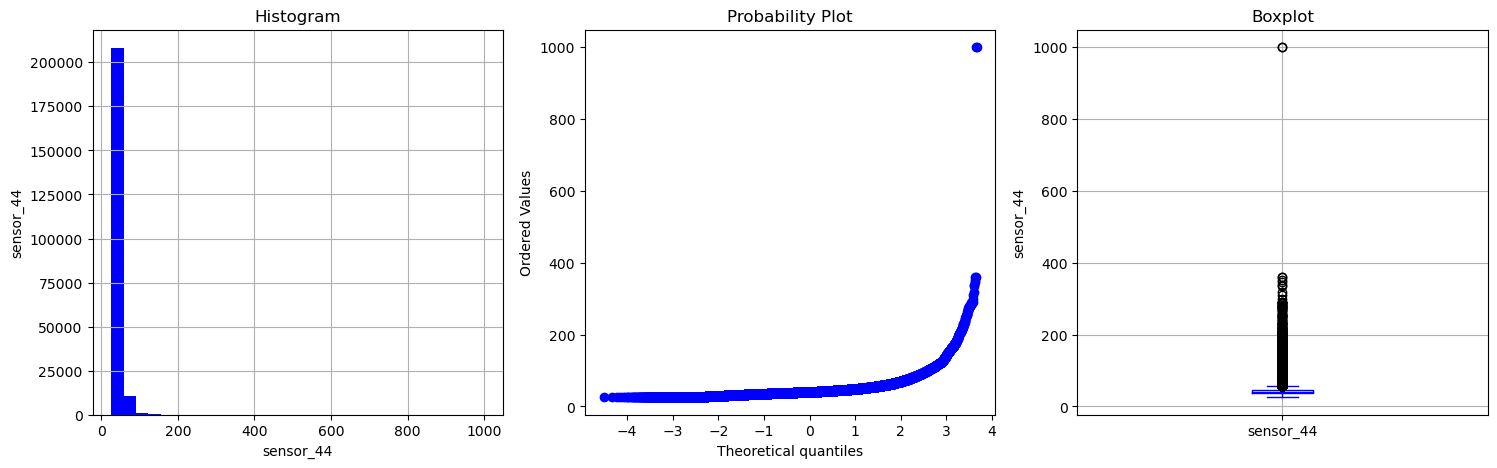

<Figure size 640x480 with 0 Axes>

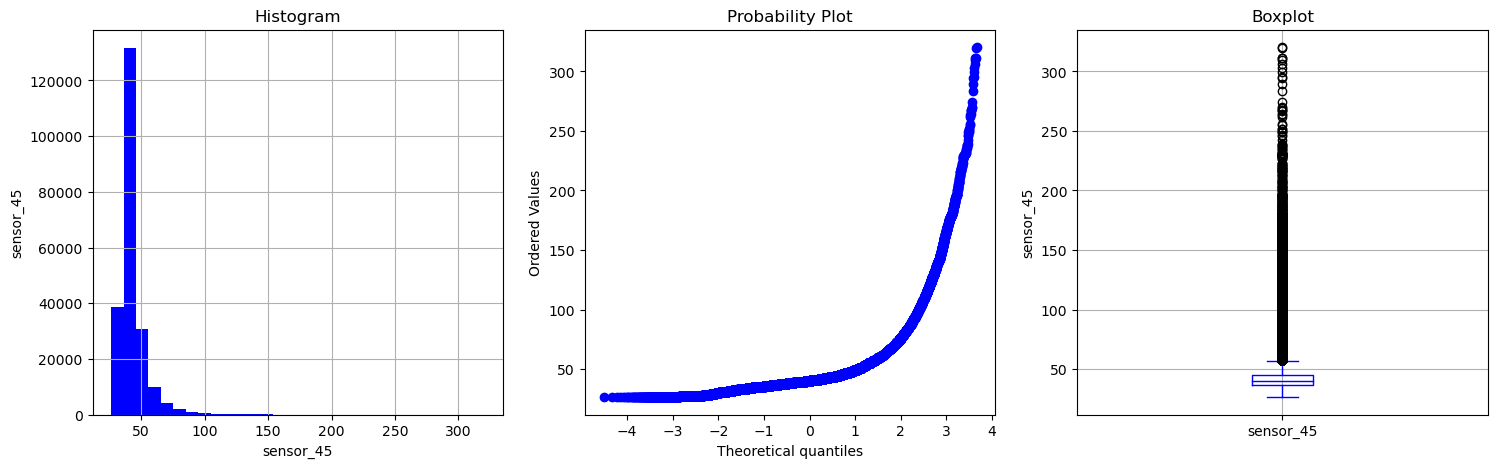

<Figure size 640x480 with 0 Axes>

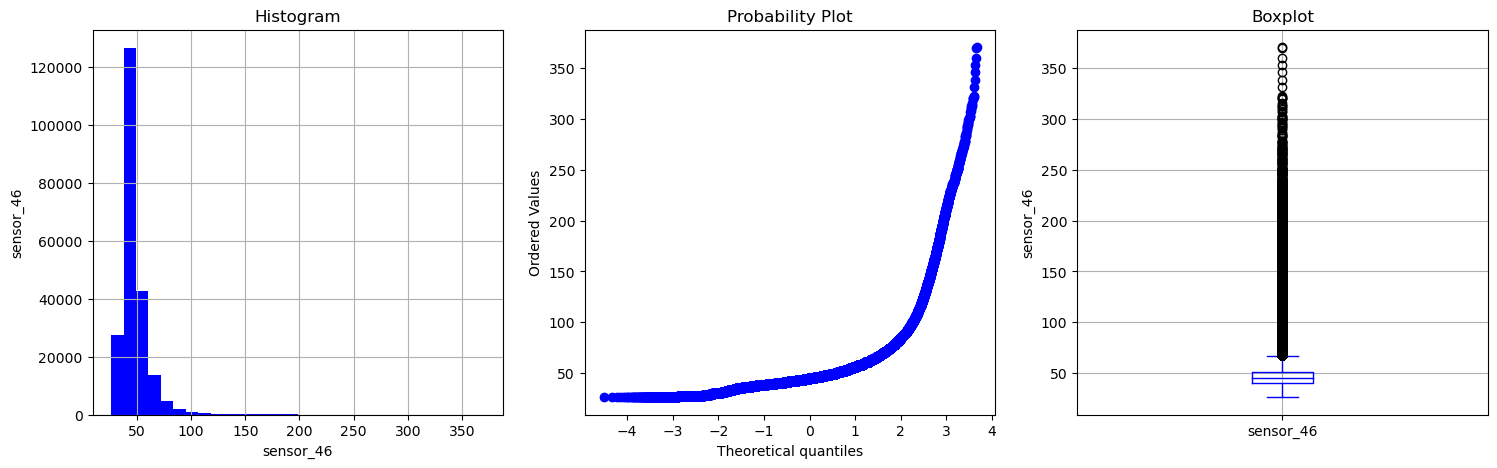

<Figure size 640x480 with 0 Axes>

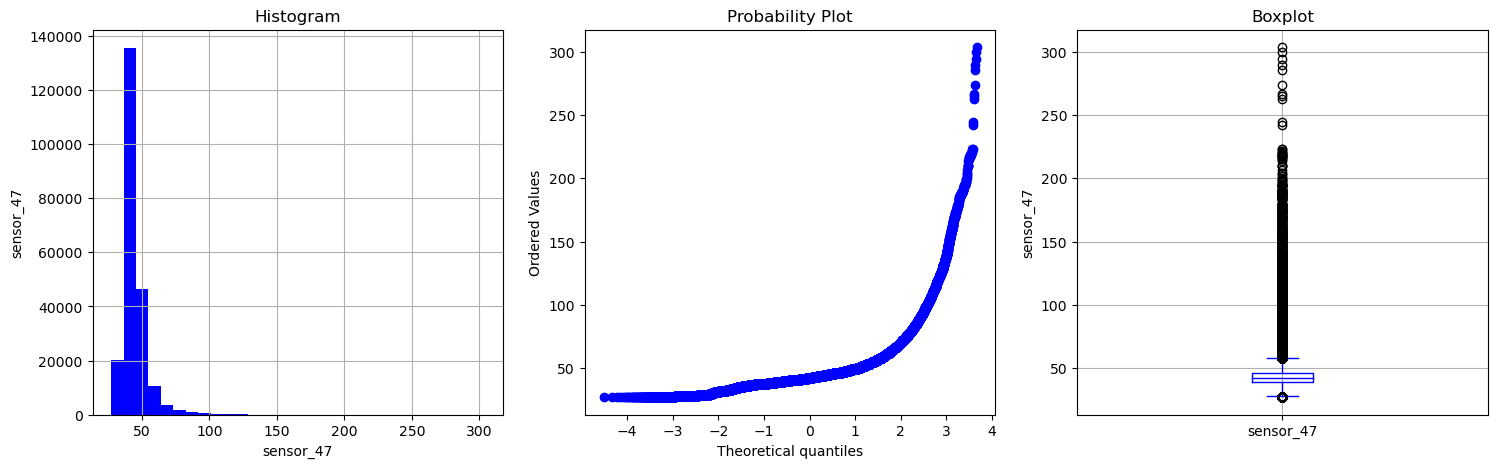

<Figure size 640x480 with 0 Axes>

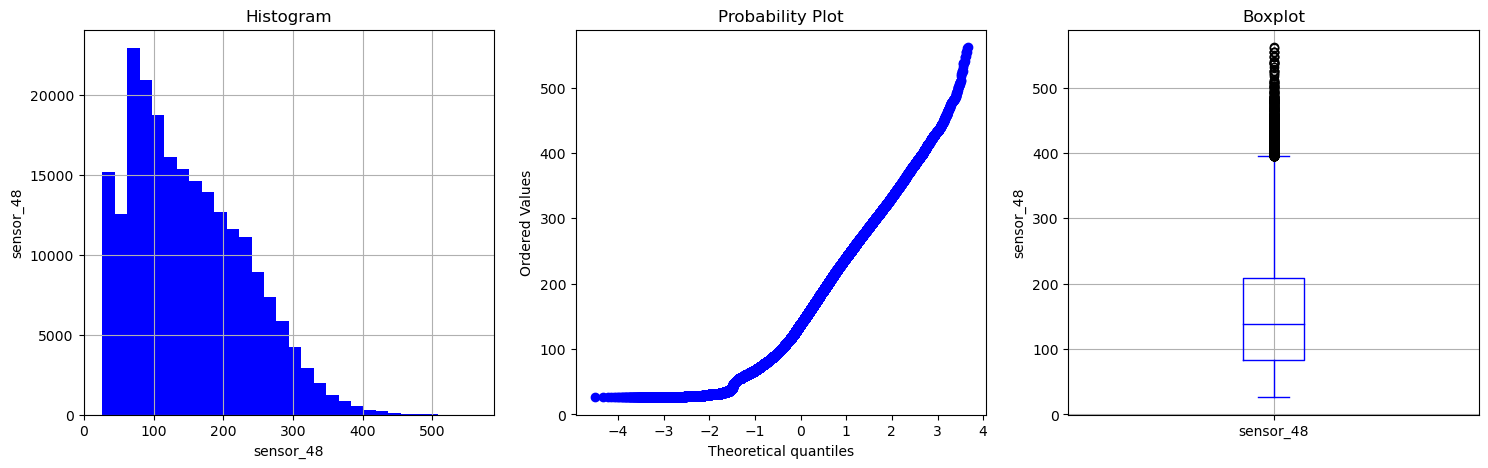

<Figure size 640x480 with 0 Axes>

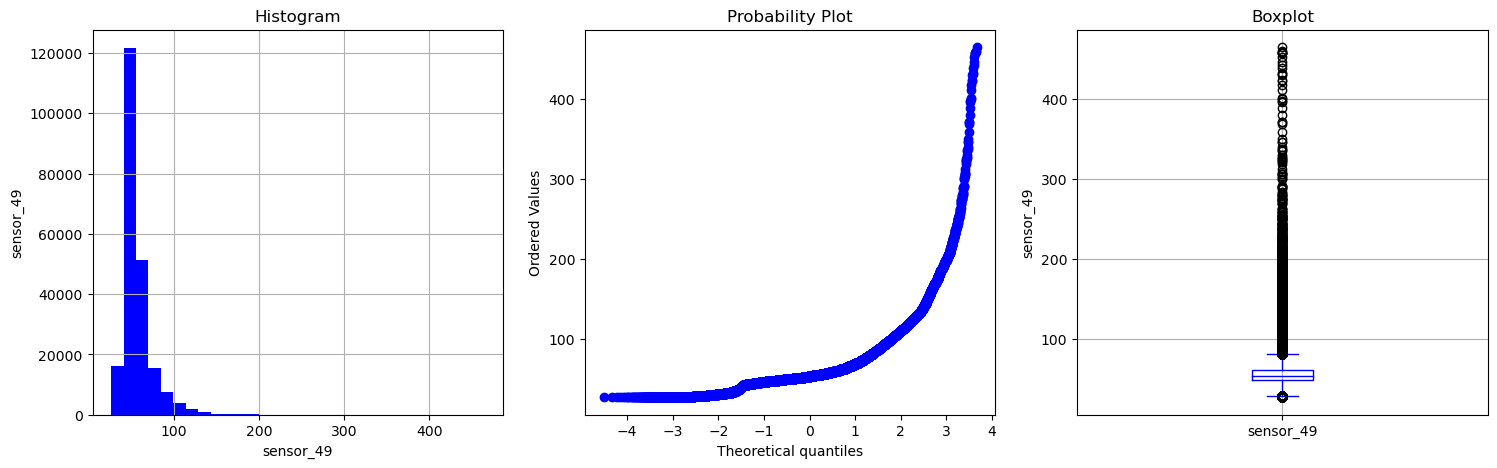

<Figure size 640x480 with 0 Axes>

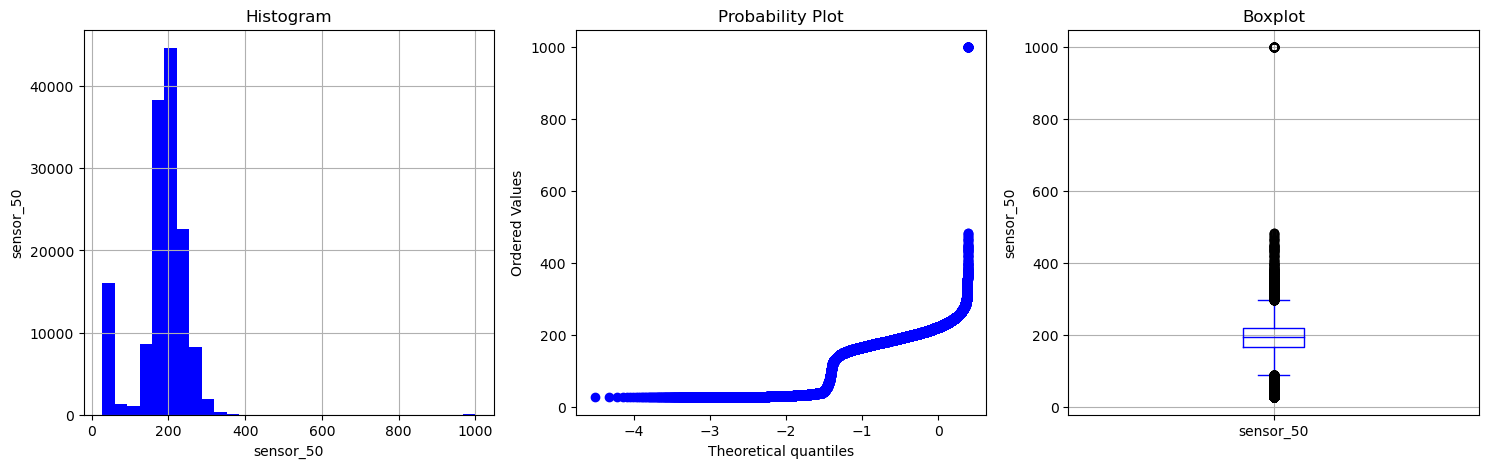

<Figure size 640x480 with 0 Axes>

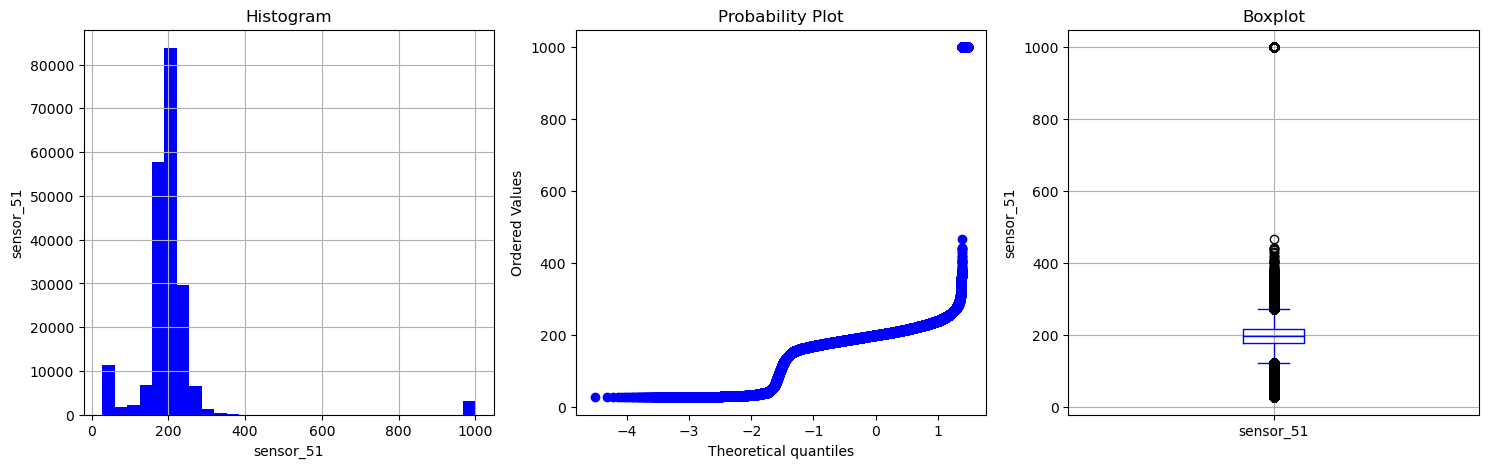

In [16]:
# let's see diagnostic plots
df_plot =  df.iloc[:,2:-1].copy()
for var in df_plot:
    diagnostic_plots(df_plot, var)

We can see that the distribution of variables is skewed, with outliers and no linearity.

<AxesSubplot:>

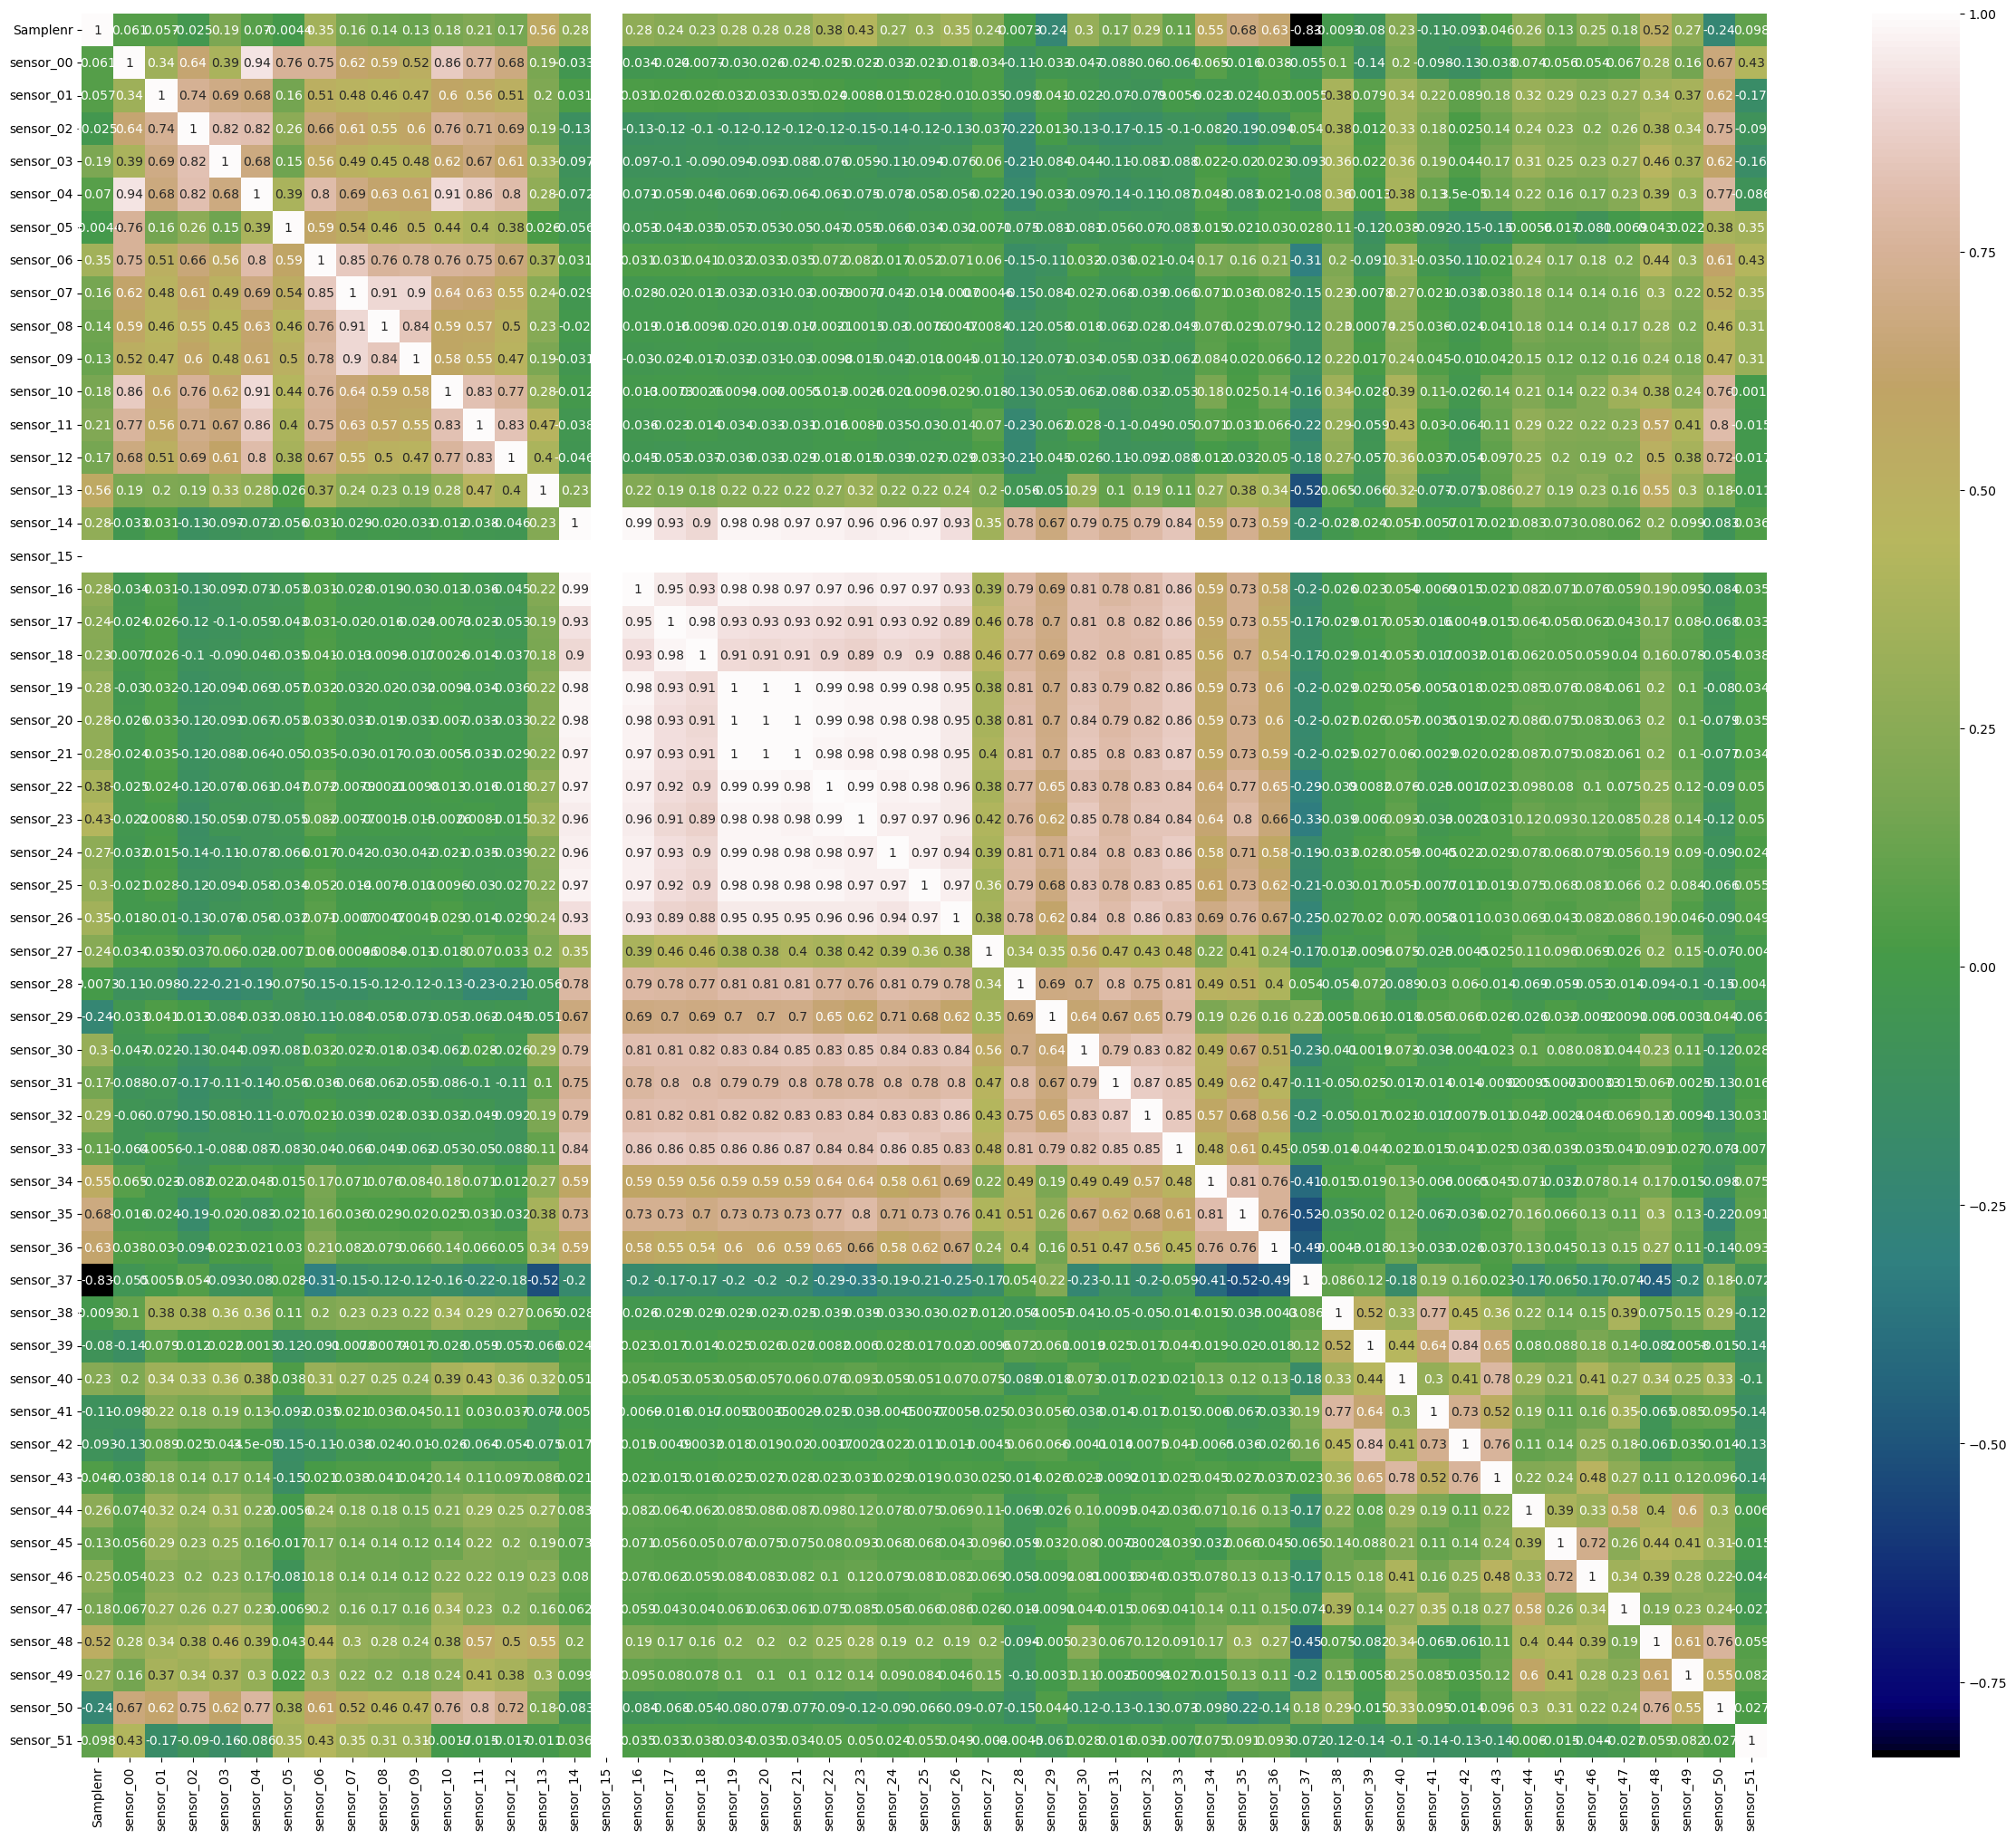

In [17]:
# correlation matrix of the original dataset
plt.figure(figsize = (30,25))
sns.heatmap(df.corr(), annot= True, cmap='gist_earth')

Looking at the correlation matrix, there are empty variable in the data. And there are variables that correlate well with each other, which shows multicollinearity.

## Step #2.2: Analysis Imputation in a Timeseries

features  missing_count  missing_count_percentage
0   sensor_15         220320                 99.950551
1   sensor_50          77017                 34.939595
2   sensor_51          15383                  6.978664
3   sensor_00          10208                  4.630970
4   sensor_07           5451                  2.472905
5   sensor_08           5107                  2.316846
6   sensor_06           4798                  2.176665
7   sensor_09           4595                  2.084571
8   sensor_01            369                  0.167401
9   sensor_30            261                  0.118405
10  sensor_29             72                  0.032664
11  sensor_32             68                  0.030849
12  sensor_18             46                  0.020868
13  sensor_17             46                  0.020868
14  sensor_22             41                  0.018600
15  sensor_25             36                  0.016332
16  sensor_16             31                  0.014063
17  sensor_41             27                  0.012249
18  sensor_39             27                  0.012249
19  sensor_40             27                  0.012249
20  sensor_42             27                  0.012249
21  sensor_38             27                  0.012249
22  sensor_43             27                  0.012249
23  sensor_44             27                  0.012249
24  sensor_45             27                  0.012249
25  sensor_46             27                  0.012249
26  sensor_47             27                  0.012249
27  sensor_48             27                  0.012249
28  sensor_49             27                  0.012249
29  sensor_14             21                  0.009527
30  sensor_26             20                  0.009073
31  sensor_02             19                  0.008620
32  sensor_04             19                  0.008620
33  sensor_10             19                  0.008620
34  sensor_11             19                  0.008620
35  sensor_12             19                  0.008620
36  sensor_13             19                  0.008620
37  sensor_05             19                  0.008620
38  sensor_03             19                  0.008620
39  sensor_33             16                  0.007259
40  sensor_21             16                  0.007259
41  sensor_19             16                  0.007259
42  sensor_20             16                  0.007259
43  sensor_23             16                  0.007259
44  sensor_34             16                  0.007259
45  sensor_24             16                  0.007259
46  sensor_27             16                  0.007259
47  sensor_31             16                  0.007259
48  sensor_37             16                  0.007259
49  sensor_36             16                  0.007259
50  sensor_35             16                  0.007259
51  sensor_28             16                  0.007259

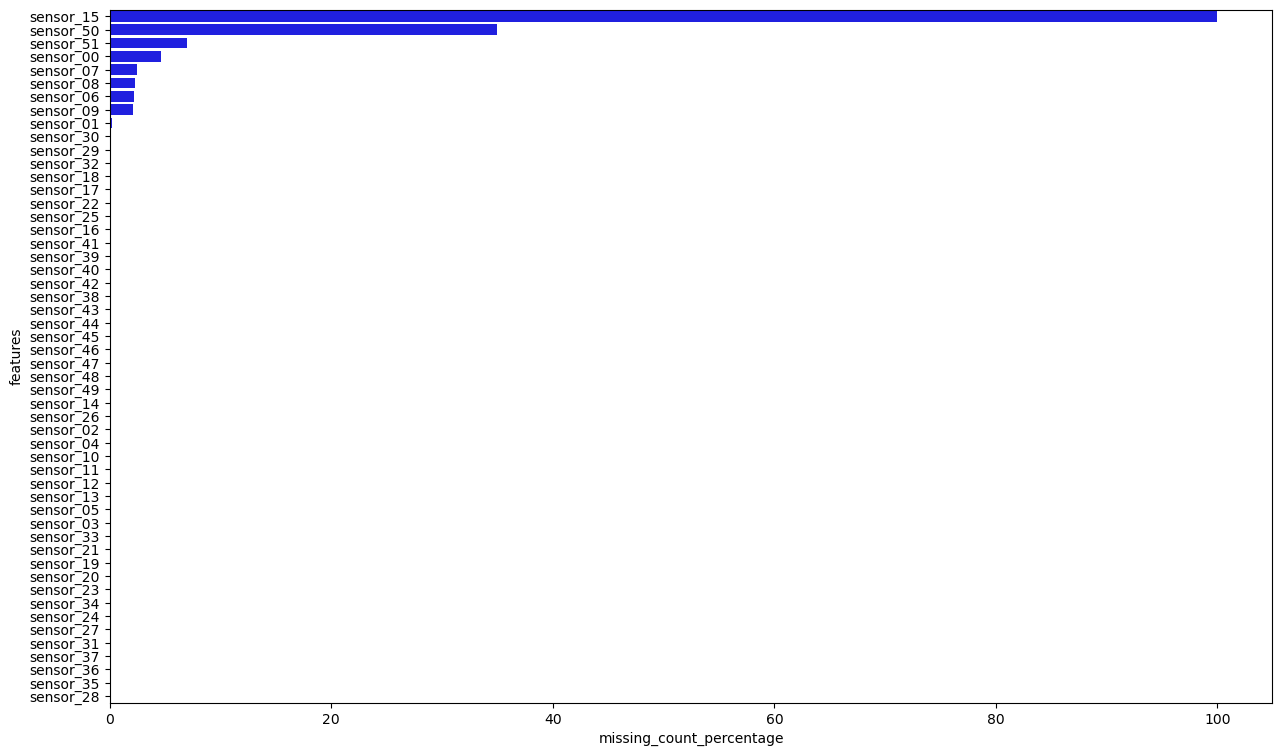

In [18]:
# show missing data in percentage
missing= df.isnull().sum()[df.isnull().sum() !=0].sort_values(ascending=False)
missing=pd.DataFrame(missing.reset_index())
missing.rename(columns={'index':'features',0:'missing_count'},inplace=True)
missing['missing_count_percentage']=((missing['missing_count'])/220429)*100
plt.figure(figsize=(15,9))
sns.barplot(y=missing['features'],x=missing['missing_count_percentage'], color='b')
missing

'sensor_15' variable is missing 99.9% of the data and 7% of the sensors, and the missing data is deleted above.

In [19]:
# delete variables
df=df.drop(['sensor_15','sensor_50','sensor_51','timestamp', 'Samplenr'], axis=1)

In [20]:
# create independent variable X
x = df.drop(['machine_status'], axis=1)
# # encode variable 'machine_status' for vizualization analysis
# label = LabelEncoder() 
# label.fit(df['machine_status'])
# y = label.transform(df['machine_status'])

#### Imputation with Simple Imputer, KNN Imputer, Iterative Imputer

In [21]:
# create copy variable for analysis imputation
x_mean = x.copy()
x_median = x.copy()
x_knn = x.copy()
x_iter = x.copy()

In [22]:
# imputation with Simple Imputer
mean_im= MeanMedianImputer(imputation_method='mean')
mean_im.fit(x_mean)
x_mean[:]= mean_im.transform(x_mean)
# imputation with Simple Imputer
median_im= MeanMedianImputer(imputation_method='median')
median_im.fit(x_median)
x_median[:]= median_im.transform(x_median)

In [23]:
# imputation with KNN Imputer
knn_im=KNNImputer()
knn_im.fit(x_knn)
x_knn[:] = knn_im.transform(x_knn)

In [24]:
# imputation with Iterative Imputater
iter_im= IterativeImputer()
iter_im.fit(x_iter)
x_iter[:]= iter_im.transform(x_iter)

Original variance: 0.169931390067715
Variance after meanmedian_mean imputation: 0.16205798999867313
Variance after meanmedian_median imputation: 0.16237213354072524
Variance after knn imputation: 0.37088393582342527
Variance after iterative imputation: 0.4277615757385836


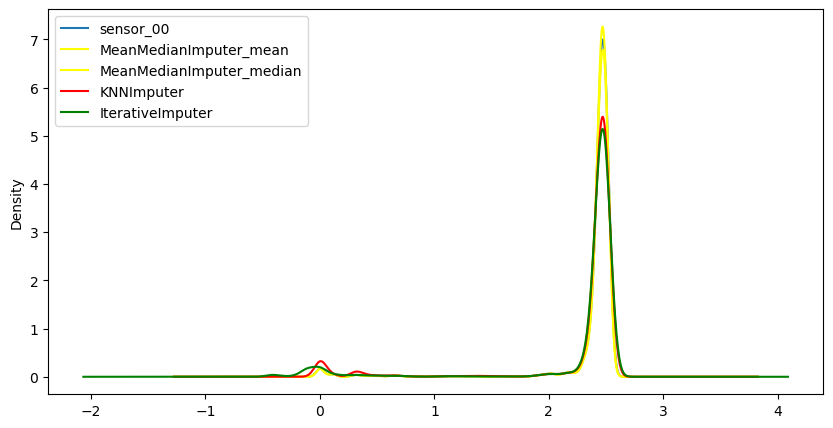

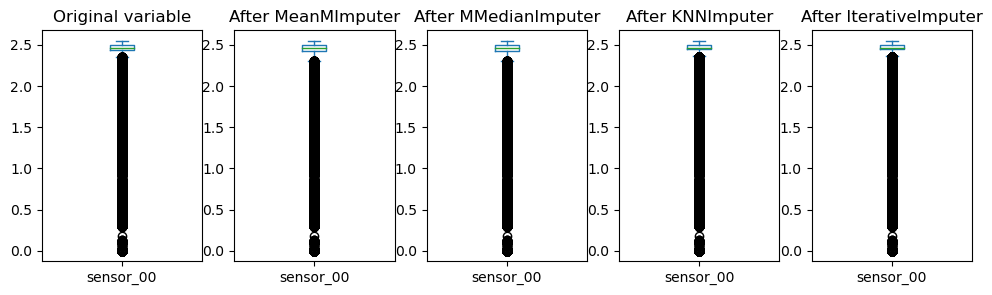

In [25]:
# vizualize after imputation
make_plot(x,x_mean,x_median,x_knn,x_iter,"sensor_00")

The variable's number is less than 0.4%, and each imputer worked well.

## Step #2.3: Scaling Analysis

In [26]:
# imputation missing data
median_im= MeanMedianImputer(imputation_method='median')
median_im.fit(x_median)
x_median[:]= median_im.transform(x_median)

In [27]:
# Scaling with Standard Scaler
stand_scaler = StandardScaler()
stand_scaler.fit(x_median)
x_standScaled= stand_scaler.transform(x_median)
x_standScaled = pd.DataFrame(x_standScaled, columns=x_median.columns)

In [28]:
# MinMax Scaler
mm_scaler = MinMaxScaler()
mm_scaler.fit(x_median)
x_mmScaled = mm_scaler.transform(x_median)
x_mmScaled = pd.DataFrame(x_mmScaled, columns=x_median.columns)

In [29]:
# Robust Scaler
rob_scaler = RobustScaler()
rob_scaler.fit(x_median)
x_robScaled= rob_scaler.transform(x_median)
x_robScaled= pd.DataFrame(x_robScaled, columns=x_median.columns)

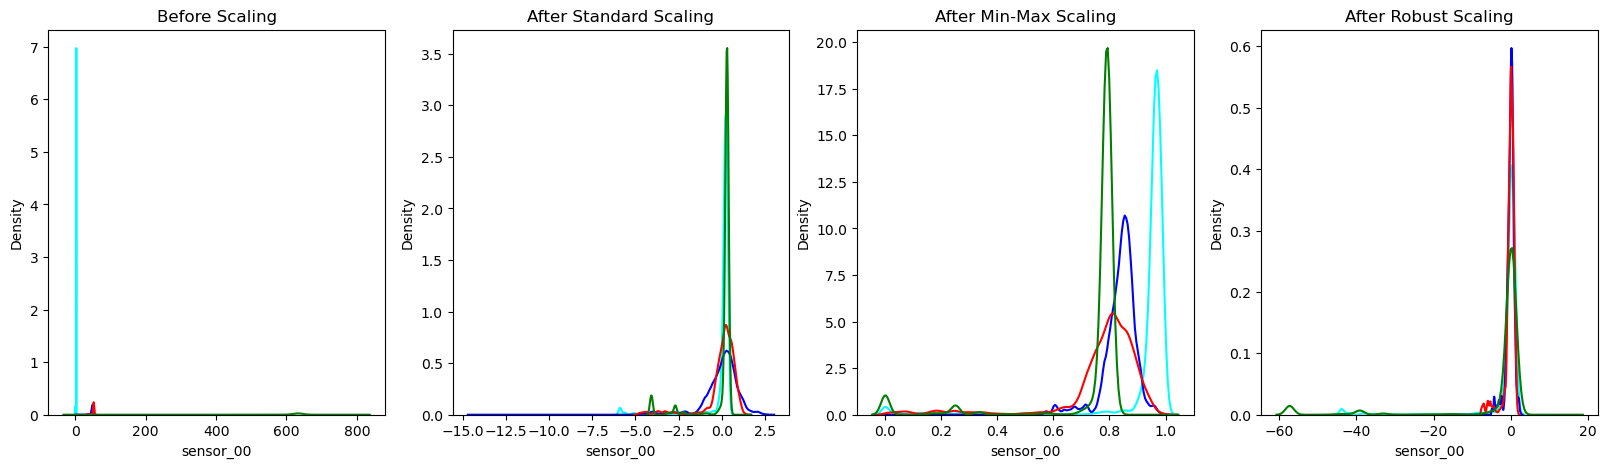

In [30]:
# take random variables
scaling_plot(x, x_standScaled, x_mmScaled, x_robScaled,'sensor_00','sensor_01','sensor_02', 'sensor_04')

We can see that the scaling normalized the range of independent variables.

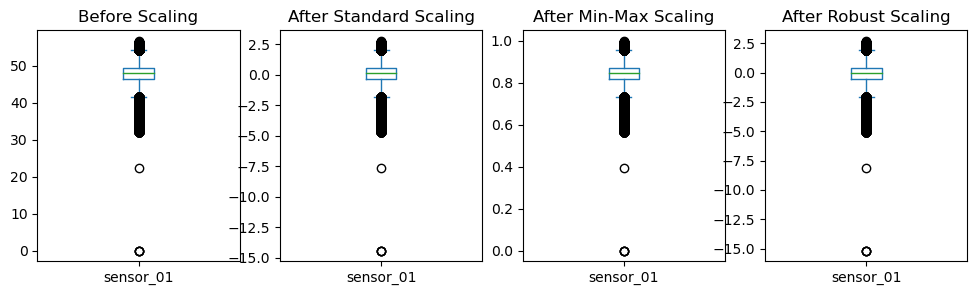

In [31]:
# look at the outliers of some variables after standardization
box_plot(x,x_standScaled,x_mmScaled,x_robScaled,'sensor_01')

After scaling the variables, the outliers were not affected in any way.

## Step #2.4: Analysis delete variables with feature selection

In [32]:
# imputation missing data
median_im= MeanMedianImputer(imputation_method='median')
median_im.fit(x_median)
x_median[:]= median_im.transform(x_median)

In [33]:
# remove correlated, quasi-constant, duplicated and constant variables in Pipeline
pipe = Pipeline([('constant', DropConstantFeatures()),
                 ('quasi-constant', DropConstantFeatures(tol=0.2)),
                 ('duplicated', DropDuplicateFeatures()),
                 ('correlated', SmartCorrelatedSelection(selection_method='cardinality'))])
pipe.fit(x_median)
x_drop = pipe.transform(x_median)

In [34]:
# checking constant features
len(pipe.named_steps['constant'].features_to_drop_)

0

In [35]:
# checking quasi-constant features
len(pipe.named_steps['quasi-constant'].features_to_drop_)

1

In [36]:
# checking duplicated features
len(pipe.named_steps['duplicated'].features_to_drop_)

0

In [37]:
# checking correlated features
len(pipe.named_steps['correlated'].features_to_drop_)

19

In [38]:
# how many columns are left after feature selection
x_drop.shape

(220320, 29)

# Step #3: Data Preparation

In [39]:
# create pipeline
pipe = Pipeline([
                 ('imputer', MeanMedianImputer(imputation_method='median')),
                 ('quasi-constant', DropConstantFeatures(tol=0.2)),
                 ('correlated', SmartCorrelatedSelection(selection_method='cardinality')),
                 ('scaler', MinMaxScaler())
                 ])
pipe.fit(x)
x = pipe.transform(x)

In [40]:
# prepare data for creating a window
nr_examples_to_prepare = 5000

window_width_input_minutes = 60
window_width_output_minutes = 60*60*5

start_minute = 0
a_single_input_window = x[start_minute: start_minute + window_width_input_minutes]
a_single_input_window
# total number of variables per minute
a_single_input_window.shape

(60, 29)

In [41]:
# convert to vector
a_single_input_vector = a_single_input_window.flatten()
a_single_input_vector.shape

(1740,)

In [42]:
# function check pump failures
def check_for_pump_failures(start, stop):
    for minute in range(start, stop):
        machine_state_in_this_minute = df['machine_status'].iloc[minute]
        if machine_state_in_this_minute in ['BROKEN', 'RECOVERING']:
            return 1
        return 0

In [43]:
nr_rows_total = df.shape[0]
nr_rows_total

220320

In [44]:
max_row_nr = nr_rows_total - window_width_input_minutes - window_width_output_minutes

In [45]:
# create window for time series
max_row_nr = nr_rows_total - window_width_input_minutes - window_width_output_minutes

training_pairs=[]
for example_nr in range(0, nr_examples_to_prepare):
    if example_nr % 100 == 0:
        print('Collected examples so far:', example_nr)
  
    found_example_where_pump_worked_in_input_window = False

    while not found_example_where_pump_worked_in_input_window:
        
        rnd_minute = np.random.randint(0, max_row_nr)

        start = rnd_minute

        stop = start + window_width_input_minutes

        if check_for_pump_failures(start, stop)==0:
            found_example_where_pump_worked_in_input_window=True

    a_single_input_window = x[rnd_minute: rnd_minute+window_width_input_minutes]

    a_single_input_vector = a_single_input_window.flatten()

    start = rnd_minute + window_width_input_minutes

    stop = rnd_minute + window_width_input_minutes + window_width_output_minutes

    output_value = check_for_pump_failures(start, stop)

    training_pairs.append((a_single_input_vector, output_value))

Collected examples so far: 0
Collected examples so far: 100
Collected examples so far: 200
Collected examples so far: 300
Collected examples so far: 400
Collected examples so far: 500
Collected examples so far: 600
Collected examples so far: 700
Collected examples so far: 800
Collected examples so far: 900
Collected examples so far: 1000
Collected examples so far: 1100
Collected examples so far: 1200
Collected examples so far: 1300
Collected examples so far: 1400
Collected examples so far: 1500
Collected examples so far: 1600
Collected examples so far: 1700
Collected examples so far: 1800
Collected examples so far: 1900
Collected examples so far: 2000
Collected examples so far: 2100
Collected examples so far: 2200
Collected examples so far: 2300
Collected examples so far: 2400
Collected examples so far: 2500
Collected examples so far: 2600
Collected examples so far: 2700
Collected examples so far: 2800
Collected examples so far: 2900
Collected examples so far: 3000
Collected examples s

In [46]:
# create the length of the input and output vectors
input_vec_len = training_pairs[0][0].shape[0]
output_vec_len =1

In [47]:
# create a matrix with 0 
D = np.zeros((nr_examples_to_prepare, input_vec_len + output_vec_len))

print('Shape of D is', D.shape)

Shape of D is (5000, 1741)


In [48]:
# splitting on train and test 
for nr in range(0, nr_examples_to_prepare):    
    
    (x, y) = training_pairs[nr]
    
    D[nr, 0:input_vec_len] = x
    D[nr, input_vec_len] = y
    
nr_train_samples = int(nr_examples_to_prepare/2)

x_train = D[0:nr_train_samples, 0:input_vec_len]
y_train = D[0:nr_train_samples, input_vec_len]

x_test = D[nr_train_samples:, 0:input_vec_len]
y_test = D[nr_train_samples:, input_vec_len]

x_train.shape, y_train.shape

((2500, 1740), (2500,))

# Step #4: Model building
## Step #4.1: MultinomialNB

In [49]:
# training the model using Naive Bayes classifier with Grid Search
NB_classifier = MultinomialNB()
NB_classifier.fit(x_train, y_train)

params_NB= {'alpha': [1, 2]}

NB_gridSearch = GridSearchCV(NB_classifier, params_NB, cv = 6, n_jobs = -1, scoring = 'accuracy')
NB_gridSearch.fit(x_train, y_train)

GridSearchCV(cv=6, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [1, 2]}, scoring='accuracy')

In [50]:
# selection of the best parameters
NB_gridSearch.best_params_

{'alpha': 2}

In [51]:
# prediction
y_pred_train_NB = NB_gridSearch.predict(x_train)
y_pred_test_NB = NB_gridSearch.predict(x_test)

Train: 
accuracy 0.9936
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2494
         1.0       0.08      0.17      0.11         6

    accuracy                           0.99      2500
   macro avg       0.54      0.58      0.55      2500
weighted avg       1.00      0.99      0.99      2500

------------------------------------------------------
Test: 
accuracy 0.994
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2496
         1.0       0.18      0.75      0.29         4

    accuracy                           0.99      2500
   macro avg       0.59      0.87      0.64      2500
weighted avg       1.00      0.99      1.00      2500



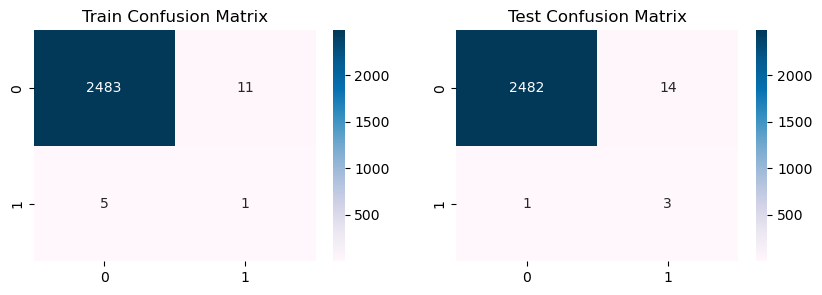

In [52]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_NB,y_pred_test_NB)

 We observe overfitting on the test set. The model correctly predicted don't failure 2482 times and water pump failure 3 times. However, the model made a false positive error 14 times and a false negative error 1 times.

### Step#4.2: Random Forest Classifier

In [53]:
# training the model using Random Forest Classifier with Grid Search
RF_classifier = RandomForestClassifier(class_weight='balanced')
RF_classifier.fit(x_train,y_train)

params_RF= {'n_estimators': [10,20,30],
             'criterion': ['gini','entropy','log_loss'],
             'max_depth': [4,5,6],
             'max_features': ['sqrt', 'log2', None],
             'n_jobs': [-1]
            }

RF_gridSearch = GridSearchCV(RF_classifier, params_RF, cv = 6, n_jobs = -1, scoring = 'accuracy')
RF_gridSearch.fit(x_train, y_train)

GridSearchCV(cv=6, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [4, 5, 6],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 20, 30], 'n_jobs': [-1]},
             scoring='accuracy')

In [54]:
# selection of the best parameters
RF_gridSearch.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'n_estimators': 10,
 'n_jobs': -1}

In [55]:
# prediction
y_pred_train_RF = RF_gridSearch.predict(x_train)
y_pred_test_RF = RF_gridSearch.predict(x_test)

Train: 
accuracy 0.9992
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2494
         1.0       1.00      0.67      0.80         6

    accuracy                           1.00      2500
   macro avg       1.00      0.83      0.90      2500
weighted avg       1.00      1.00      1.00      2500

------------------------------------------------------
Test: 
accuracy 0.9988
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2496
         1.0       1.00      0.25      0.40         4

    accuracy                           1.00      2500
   macro avg       1.00      0.62      0.70      2500
weighted avg       1.00      1.00      1.00      2500



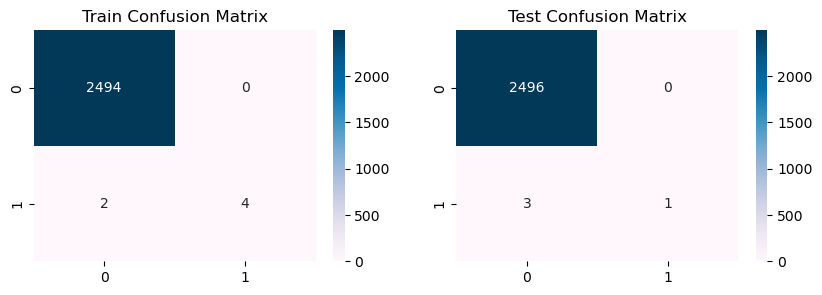

In [56]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_RF,y_pred_test_RF)

 We observe overfitting on the test set. The model correctly predicted don't failure 2495 times and water pump failure 1 times. However, the model made a false positive error 0 times and a false negative error 3 times.

### Step#4.3: K-Nearest Neighbor Classifier

In [57]:
# training the model using K-Nearest Neighbor Classifier with Grid Search
KN_classifier = KNeighborsClassifier()
KN_classifier.fit(x_train, y_train)

params_KN = {'n_neighbors': [1,2,3],
              'p':[1,2,3]
             }
                   
KN_gridSearch = GridSearchCV(KN_classifier, params_KN, cv = 6, n_jobs = -1, scoring ='accuracy')
KN_gridSearch.fit(x_train, y_train)

GridSearchCV(cv=6, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3], 'p': [1, 2, 3]},
             scoring='accuracy')

In [58]:
# selection of the best parameters
KN_gridSearch.best_params_

{'n_neighbors': 1, 'p': 1}

In [59]:
# prediction
y_pred_train_KN = KN_gridSearch.predict(x_train)
y_pred_test_KN = KN_gridSearch.predict(x_test)

Train: 
accuracy 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2494
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

------------------------------------------------------
Test: 
accuracy 0.9992
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2496
         1.0       0.75      0.75      0.75         4

    accuracy                           1.00      2500
   macro avg       0.87      0.87      0.87      2500
weighted avg       1.00      1.00      1.00      2500



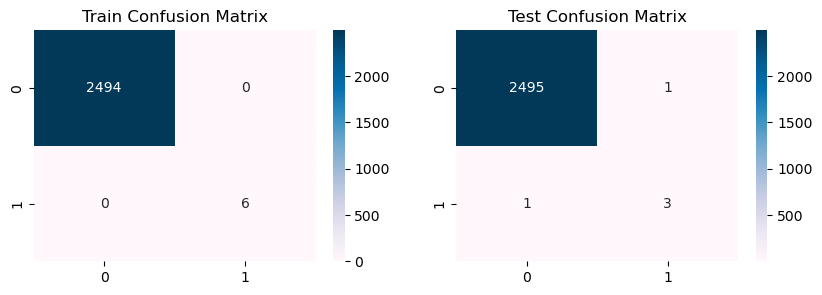

In [60]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_KN,y_pred_test_KN)

 We observe overfitting on the test set. The model correctly predicted don't failure 2495 times and water pump failure 3 times. However, the model made a false positive error 1 times and a false negative error 1 times.

### Step#4.4: Support Vector Classifier

In [61]:
# training the model using Support Vector Classifier with Grid Search
SVC_classifier = SVC(class_weight= 'balanced')
SVC_classifier.fit(x_train, y_train)

params_SVC= {'C': [1.0,2],
             'kernel': ['rbf', 'poly']
            }

SVC_gridSearch = GridSearchCV(SVC_classifier, params_SVC, cv = 6, n_jobs = -1, scoring = 'accuracy')
SVC_gridSearch.fit(x_train, y_train)

GridSearchCV(cv=6, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [1.0, 2], 'kernel': ['rbf', 'poly']},
             scoring='accuracy')

In [62]:
# selection of the best parameters
SVC_gridSearch.best_params_

{'C': 2, 'kernel': 'poly'}

In [63]:
# prediction 
y_pred_train_SVC = SVC_gridSearch.predict(x_train)
y_pred_test_SVC = SVC_gridSearch.predict(x_test)

Train: 
accuracy 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2494
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

------------------------------------------------------
Test: 
accuracy 0.9996
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2496
         1.0       0.80      1.00      0.89         4

    accuracy                           1.00      2500
   macro avg       0.90      1.00      0.94      2500
weighted avg       1.00      1.00      1.00      2500



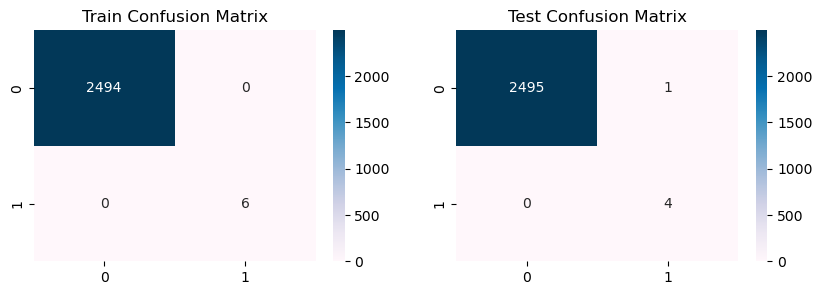

In [64]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_SVC,y_pred_test_SVC)

 We observe overfitting on the test set. The model correctly predicted don't failure 2495 times and water pump failure 4 times. However, the model made a false positive error 1 times and a false negative error 0 times.

### Step#4.5: SGDClassifier

In [65]:
# training the model using SGD Classifier with Grid Search
SGD_classifier = SGDClassifier(class_weight='balanced')
SGD_classifier.fit(x_train, y_train)

params_SGD= {'loss': ['hinge', 'log_loss', 'log'],
             'penalty': ['l2', 'l1', 'elasticnet'],             
             'alpha': [40,50,60] 
             }

SGD_gridSearch = GridSearchCV(SGD_classifier, params_SGD, cv = 6, n_jobs = -1, scoring = 'accuracy')
SGD_gridSearch.fit(x_train, y_train)

GridSearchCV(cv=6, estimator=SGDClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'alpha': [40, 50, 60],
                         'loss': ['hinge', 'log_loss', 'log'],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='accuracy')

In [66]:
# selection of the best parameters
SGD_gridSearch.best_params_

{'alpha': 40, 'loss': 'hinge', 'penalty': 'l2'}

In [67]:
# prediction 
y_pred_train_SGD = SGD_gridSearch.predict(x_train)
y_pred_test_SGD = SGD_gridSearch.predict(x_test)

Train: 
accuracy 0.9976
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2494
         1.0       0.00      0.00      0.00         6

    accuracy                           1.00      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       1.00      1.00      1.00      2500

------------------------------------------------------
Test: 
accuracy 0.9984
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2496
         1.0       0.00      0.00      0.00         4

    accuracy                           1.00      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       1.00      1.00      1.00      2500



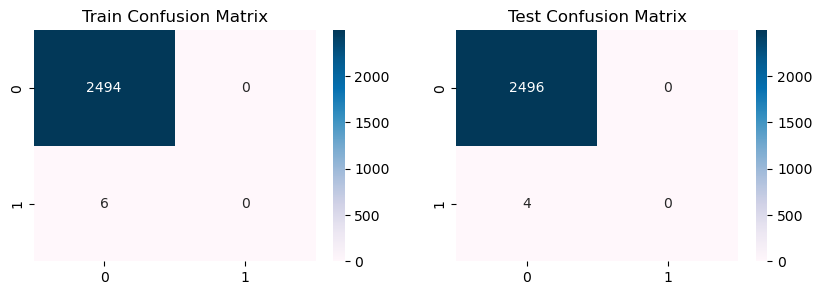

In [68]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_SGD,y_pred_test_SGD)

 We observe overfitting on the test set. The model correctly predicted don't failure 2496 times and water pump failure 0 times. However, the model made a false positive error 0 times and a false negative error 4 times.

### Step#4.6: XGBClassifier

In [69]:
# training the model using XGB Classifier with Grid Search
XGB_classifier = XGBClassifier()
XGB_classifier.fit(x_train, y_train)

params_XGB= {'n_estimators': [100,200,50], 
             'max_depth': [10,20,12]           
             }

XGB_gridSearch = GridSearchCV(XGB_classifier, params_XGB, cv = 6, n_jobs = -1, scoring = 'accuracy')
XGB_gridSearch.fit(x_train, y_train)

GridSearchCV(cv=6,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1, ...),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 12],
                         'n_estimators': [100, 200, 50]},
             scoring='accuracy')

In [70]:
# selection of the best parameters
XGB_gridSearch.best_params_

{'max_depth': 10, 'n_estimators': 100}

In [71]:
# prediction 
y_pred_train_XGB = XGB_gridSearch.predict(x_train)
y_pred_test_XGB = XGB_gridSearch.predict(x_test)

Train: 
accuracy 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2494
         1.0       1.00      1.00      1.00         6

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500

------------------------------------------------------
Test: 
accuracy 0.9988
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2496
         1.0       0.67      0.50      0.57         4

    accuracy                           1.00      2500
   macro avg       0.83      0.75      0.79      2500
weighted avg       1.00      1.00      1.00      2500



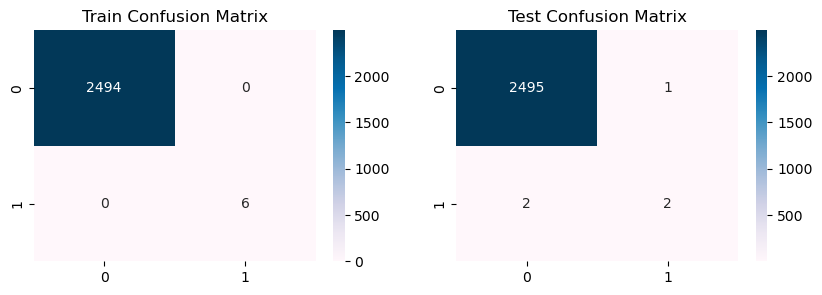

In [72]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,y_pred_train_XGB,y_pred_test_XGB)

 We observe overfitting on the test set. The model correctly predicted don't failure 2495 times and water pump failure 2 times. However, the model made a false positive error 1times and a false negative error 2 times.

### Step#4.7: ANN

In [101]:
model_ann = Sequential()
model_ann.add(Dense(200, activation='relu',input_shape = (input_vec_len,)))
model_ann.add(Dropout(0.2))
model_ann.add(BatchNormalization())
model_ann.add(Dense(40, activation='relu'))
model_ann.add(Dropout(0.2))
# model_ann.add(BatchNormalization())
model_ann.add(Dense(1, activation='sigmoid'))
model_ann.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = 'accuracy')
model_ann.build()
# summary of the model
model_ann.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 200)               348200    
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 40)                8040      
                                                                 
 dropout_7 (Dropout)         (None, 40)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 41        
                                                      

In [102]:
# checkpointer to monitor accuracy and preventing overfit
earlystopping = EarlyStopping(monitor = 'val_loss',mode = 'min',verbose = 1,patience = 20)

In [103]:
history_ann = model_ann.fit(x_train,
                    y_train,
                    epochs = 500,
                    batch_size = 100,
                    validation_split = 0.3,
                    verbose = 1,
                    callbacks = earlystopping)

Epoch 1/500
18/18 [==============================] - 2s 18ms/step - loss: 0.3594 - accuracy: 0.8560 - val_loss: 0.1122 - val_accuracy: 0.9987
Epoch 2/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0900 - accuracy: 0.9920 - val_loss: 0.0596 - val_accuracy: 0.9987
Epoch 3/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0417 - accuracy: 0.9971 - val_loss: 0.0326 - val_accuracy: 0.9987
Epoch 4/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0260 - accuracy: 0.9971 - val_loss: 0.0139 - val_accuracy: 0.9987
Epoch 5/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0238 - accuracy: 0.9971 - val_loss: 0.0130 - val_accuracy: 0.9987
Epoch 6/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0234 - accuracy: 0.9966 - val_loss: 0.0105 - val_accuracy: 0.9987
Epoch 7/500
18/18 [==============================] - 0s 7ms/step - loss: 0.0182 - accuracy: 0.9971 - val_loss: 0.0102 - val_accuracy: 0.9987
Epoch 8/500


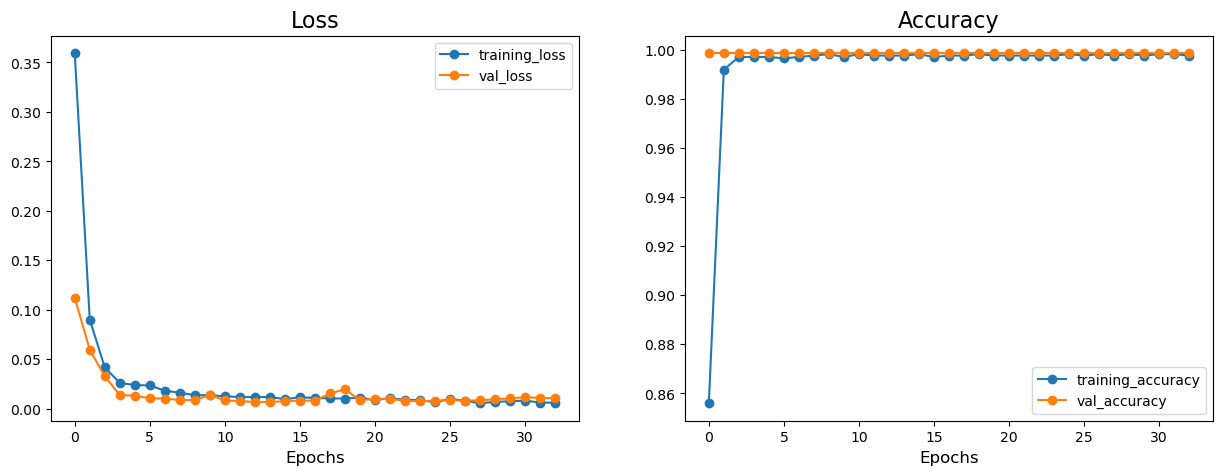

In [104]:
history_plot(history_ann)

In [105]:
preds_train = model_ann.predict(x_train)
preds_train = np.where(preds_train > 0.5, 1, 0)

79/79 [==============================] - 0s 2ms/step


In [106]:
preds = model_ann.predict(x_test)
preds = np.where(preds > 0.5, 1, 0)

79/79 [==============================] - 0s 2ms/step


In [107]:
print('Accuracy : {}'.format(model_ann.evaluate(x_test,y_test,verbose = 1,batch_size = 2)[1]))

1250/1250 [==============================] - 2s 2ms/step - loss: 0.0056 - accuracy: 0.9992
Accuracy : 0.9991999864578247


Train: 
accuracy 0.9984
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2494
         1.0       1.00      0.33      0.50         6

    accuracy                           1.00      2500
   macro avg       1.00      0.67      0.75      2500
weighted avg       1.00      1.00      1.00      2500

------------------------------------------------------
Test: 
accuracy 0.9992
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2496
         1.0       1.00      0.50      0.67         4

    accuracy                           1.00      2500
   macro avg       1.00      0.75      0.83      2500
weighted avg       1.00      1.00      1.00      2500



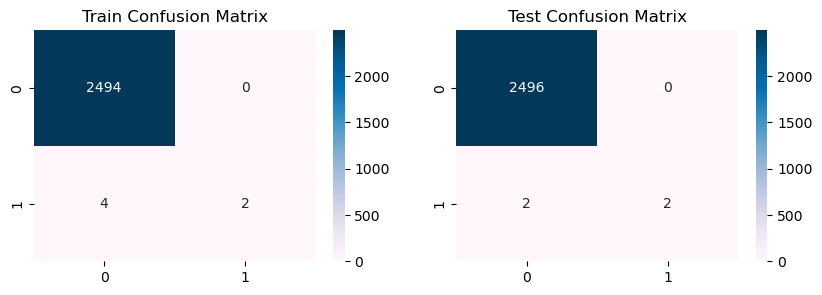

In [108]:
# let's have a look at the classification report and confution matrix
score_show(y_train, y_test,preds_train,preds)

 We observe overfitting on the test set. The model correctly predicted don't failure 2490 times and water pump failure 2 times. However, the model made a false positive error 0 times and a false negative error 2 times.

## Step #5: Record Classification Metrics

In [109]:
# let's record the classification metrics from the report for each model.
def generate_scores(y_true, y_pred):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 4)
    model_rocauc = round(roc_auc_score(y_true,y_pred), 4)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    preformance_scores = {'accuracy_score': model_accuracy,
                          'roc_auc_score' : model_rocauc,
                          'precision_score': model_precision,
                          'recall_score': model_recall,
                          'f1_score': model_f1}
    return preformance_scores

In [110]:
# with generate_scores function evaluate models
NB_performance = generate_scores(y_test, y_pred_test_NB)
RF_performance = generate_scores(y_test, y_pred_test_RF)
KN_performance = generate_scores(y_test, y_pred_test_KN)
SVC_performance = generate_scores(y_test, y_pred_test_SVC)
SGD_performance = generate_scores(y_test, y_pred_test_SGD)
XGB_performance = generate_scores(y_test, y_pred_test_XGB)
ANN_performance = generate_scores(y_test, preds)

In [111]:
# call columns in DataFrame
performace_df = pd.DataFrame({
    'MultinomialNB': NB_performance,
    'RandomForestClassifier': RF_performance,
    'KNeighborsClassifier': KN_performance,
    'SVC': SVC_performance,
    'SGDClassifier': SGD_performance,
    'XGBClassifier': XGB_performance,
    'ANN': ANN_performance
}).T
performace_df.sort_values(by =['accuracy_score', 'roc_auc_score', 'precision_score','recall_score','f1_score'], 
                          ascending = False)

accuracy_score  roc_auc_score  precision_score  \
SVC                             0.9996         0.9998         0.999680   
KNeighborsClassifier            0.9992         0.8748         0.999200   
ANN                             0.9992         0.7500         0.999201   
XGBClassifier                   0.9988         0.7498         0.998667   
RandomForestClassifier          0.9988         0.6250         0.998801   
SGDClassifier                   0.9984         0.5000         0.996803   
MultinomialNB                   0.9940         0.8722         0.998280   

                        recall_score  f1_score  
SVC                           0.9996  0.999622  
KNeighborsClassifier          0.9992  0.999200  
ANN                           0.9992  0.999067  
XGBClassifier                 0.9988  0.998714  
RandomForestClassifier        0.9988  0.998440  
SGDClassifier                 0.9984  0.997601  
MultinomialNB                 0.9940  0.995849

## Conclusion
We tried to build a model to predict the next failure before it happens.
* The distribution of classes in the dependent variable is imbalanced. In total 7 are broken, 14477 are recovering  and 205836 are normal.
*  After analyzing the dataset, we saw that the distribution of variables is skewed, that there are outliers, and that there is no linearity. We analyzed the variables for missing data, and because the variables there are missing less than 0.4% data, each imputer worked well. We also analyzed scaling.
* We removed empty variable and variables that correlate well with feature selection and 7% of the sensors above are missing data. Also, 'timestamp' and 'Samplenr' variables were deleted.
* We prepared data and created a window for time series.
* Trained the model with various hyperparameters, metrics and found that the best model is Support Vector Classifier.
* The worst model is MultinomialNB.
